In [1]:
import numpy as np
import random
from enum import IntEnum
from copy import deepcopy
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-notebook')
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
class Action(IntEnum):
    up = 0
    right = 1
    down = 2
    left = 3

action_to_str = {
    Action.up : "up",
    Action.right : "right",
    Action.down : "down",
    Action.left : "left",
}

In [ ]:
class GridWorld:

    def __init__(self, height, width, start, goal, goal_value=1.0, danger=[], danger_value=-1.0, blocked=[], noise=0.0, episode_limit=30):
        """
        Initialize the GridWorld environment.
        Creates a gridworld like MDP
         - height (int): Number of rows
         - width (int): Number of columns
         - goal (int): Index number of goal cell
         - goal_value (float): Reward given for goal cell
         - danger (list of int): Indices of cells marked as danger
         - danger_value (float): Reward given for danger cell
         - blocked (list of int): Indices of cells marked as blocked (can't enter)
         - noise (float): probability of resulting state not being what was expected
        """

        self._width = width
        self._height = height
        self._num_states = height * width
        self._num_actions = len(Action)

        # Initialize Values
        self._grid_values = [0 for _ in range(self._num_states)] # Initialize state values.
        self._goal_value = goal_value
        self._danger_value = danger_value

        self._goal_cell = goal
        self._start_cell = start
        self._danger_cells = danger
        self._blocked_cells = blocked

        self._noise = noise # Noise level in the environment.
        assert noise >= 0 and noise < 1 # Ensure valid noise value.

        self._episode_limit = episode_limit


    def reset(self):
        """
        Reset the state values to their initial state.
        """
        self._grid_values = [0 for _ in range(self._height * self._width)]
        self.create_next_values()

    def _inbounds(self, state):
        """
        Check if a state index is within the grid boundaries.
        """
        return state >= 0 and state < self._width * self._height

    def _state_from_action(self, state, action):
        """
        Gets the state as a result of applying the given action
        """
        # The state passed must be valid to start with
        assert self._inbounds(state)
        # Get the index of the new state given an action
        match action:
            case Action.up:
                new_state = state - self._width
                if not self._inbounds(new_state): # Bounce off the top wall
                    return state
            case Action.down:
                new_state = state + self._width
                if not self._inbounds(new_state): # Bounce off the bottom wall
                    return state
            case Action.left:
                new_state = state - 1
                if new_state % self._width == self._width - 1: # Bounce off left wall
                    return state
            case Action.right:
                new_state = state + 1
                if new_state % self._width == 0: # Bounce off right wall
                    return state
        
        if new_state in self._blocked_cells: # Bounce off blocked cells
            return state
        
        return new_state

    def is_terminal(self, state):
        """
        Returns true if a state is terminal (goal, or danger)
        """
        # There is only one goal state, many danger states in list
        if state == self._goal_cell or state in self._danger_cells:
            return True

    def get_states(self):
        """
        Gets all non-terminal states in the environment
        """
        self._num_states = self._width * self._height

        non_terminal_states = []
        for state in range(self._num_states):
            if not self.is_terminal(state):
                non_terminal_states.append(state)
        
        return non_terminal_states

    def get_actions(self, state):
        """
        Returns a list of valid actions given the current state
        """
        # The state passed must be valid to start with
        assert self._inbounds(state)

        ## Don't count bouncing off the wall a valid action (test code):
        # valid_actions = []
        # for action in Action:
        #     new_state = self._state_from_action(state, action)
        #     if new_state != state:
        #         valid_actions.append(action)
        # return valid_actions

        # All actions are considered valid, doesnt mean that they are all transitory (s' neq s | action)!
        return [action for action in Action]

    def get_reward(self, state):
        """
        Get the reward for being in the current state
        """
        # The state passed must be valid to start with
        assert self._inbounds(state)
        # Reward is non-zero for danger or goal
        if state == self._goal_cell:
            return self._goal_value
        elif state in self._danger_cells:
            return self._danger_value
        
        return -0.1 # Default reward for being in a non-terminal state

    def get_transitions(self, state, action, deterministic=True):
        """
        Get a list of transitions as a result of attempting the action in the current state
        Each item in the list is a tuple, containing the probability of reaching that state and the state itself
        """

        # The state passed must be valid to start with
        assert self._inbounds(state)

        # Find possible next actions
        possible_actions = self.get_actions(state)

        # Selecting an action isnt noisy, meaning there is no exploration
        if not deterministic: 
            p_desired_action = 1 - self._noise
            p_undesired_action = (self._noise) / (len(possible_actions) - 1)
            # The probability of choosing a different action is (1 - probability of choosing the desired action)
            # divided by the number of undesired possible actions

            transition_list = []
            for possible_action in possible_actions:
                if possible_action == action:
                    transition_list.append(
                        (self._state_from_action(state, action), p_desired_action)
                    )
                else:
                    transition_list.append(
                        (self._state_from_action(state, possible_action), p_undesired_action)
                    )

            # Since all actions are possible, the return will always look like this:
            # [
            #     (new_state, p(new_state|action_1)), # Chosen action (passed argument)
            #     (new_state, p(new_state|action_2)), # Noisy action
            #     (new_state, p(new_state|action_3)), # Noisy action
            #     (new_state, p(new_state|action_4))  # Noisy action
            # ]
            return transition_list

        # Deterministic transition probability. The action will always take you to the next cell,
        # Unless you hit a wall, which will result in you being in the same state. Happens with p(1).
        return [(self._state_from_action(state, action), 1)]

    def get_value(self, state):
        """
        Get the current value of the state
        """
        assert self._inbounds(state)
        return self._grid_values[state]

    def create_next_values(self):
        """
        Creates a temporary storage for state value updating
        If this is not used, then asynchronous updating may result in unexpected results
        To use properly, run this at the start of each iteration
        """
        return deepcopy(self._grid_values)

    def set_next_values(self, new_values):
        """
        Set the state values from the temporary copied values
        To use properly, run this at the end of each iteration
        """
        self._grid_values = deepcopy(new_values)

    def set_value(self, state, value):
        """
        Set the value of the state into the temporary copy
        This value will not update into main storage until self.set_next_values() is called.
        """
        assert self._inbounds(state)
        self._next_values[state] = value

    # ----------------------------
    # Policy Evaluation
    # ----------------------------

    def solve_linear_system(self, discount_factor=1.0):
        """
        Solve the GridWorld using a system of linear equations corresponding to:

            V^π(s) = Σ_a π(a|s) Σ_{s',r} p(s', r | s, a) [r + γ V^π(s')]

        for all non-terminal states s.

        Parameters:
        -----------
        discount_factor : float
            The discount factor (γ) for future rewards.
        """


        # Initialize matrix A to ones, vector b to solve A * V = b for the value vector V = [V(s_0), ..., V(self._num_states)].
        A = [[0.0 for _ in range(self._num_states)] for _ in range(self._num_states)]
        b = [0.0 for _ in range(self._num_states)]


        # Loop over all states in self._grid_values
        for state in range(self._num_states):
            A[state][state] = 1.0 # Set the diagonal to 1 to isolate V(s) on the left-hand side. For terminal states, this yields V(s) = R(s).
            b[state] = self.get_reward(state) # Set reward of the state

            # If 's' is terminal, V(s) = R(s) since we don't transition anywhere after.
            # So the row is simply:  A[s][s] = 1,  b[s] = R(s).
            if self.is_terminal(state):
                continue


            # Sum up all transitions from s under each action a.
            actions = self.get_actions(state) # All the actions which can be taken from a state
            pi_sa = 1.0/len(actions)  # π(a|s) = 1/4 since all action probabilities are uniformly distributed

            for possible_action in actions:

                # transitions = iterator through dicts of {next_state, probability_of_next_state}
                transitions = self.get_transitions(state, possible_action)

                # For each possible next state s_next and its corresponding transition prob p_s_next, incorporate the reward + γ V^π(s').
                # In the determinitic case, we will always transition to the intended next state with p(1) unless we hit a wall, in which case
                # we stay in the same state.
                for s_next, p_s_next in transitions:
                    r_snext = self.get_reward(s_next) # The reward of being in next state.

                    # Add the reward of s_next to b[state].
                    # b[s] accumulates: Σ_{a} π(a|s) Σ_{s'} p(s'|s,a) * R(s')
                    # summation(actions for loop):
                    #   1/len(actions) * summation(transitions for loop): 
                    #       Transition probability from state to s_next (1 in this deterministic case) * reward of being in s_next
                    b[state] += pi_sa * p_s_next * r_snext

                    # Subtract the discounted transition from A[s][s_next].
                    # A[s][s_next] accumulates: - γ * π(a|s) * p(s'|s,a)
                    # summation(actions for loop):
                    #   summation(transitions for loop): 
                    #       negative discount factor * p(selecting this possible_action) * p(s_next given possible_action and state)
                    # This accumulation accounts for all actions and transitions from state 'state' that lead to s_next.
                    A[state][s_next] += -1 * discount_factor * pi_sa * p_s_next

        # Convert to numpy array and solve
        # print(f"MATRIX:\n{A}")
        A = np.array(A)
        b = np.array(b)
        V_solution = np.linalg.solve(A, b)

        # Store the resulting values back into self._grid_values.
        self._grid_values = V_solution.tolist()

        # Each V(s) now satisfies Bellman Eq: V^π(s) = Σ_a π(a|s) Σ_{s'} p(s'|s,a) [ R(s') + γ V^π(s') ]

    
    # All the following control algorithms will be implemented on every visit
    
    
    # ----------------------------
    # On-Policy Montecarlo Control
    # ----------------------------
    def on_policy_montecarlo_control(self, num_episodes, discount_factor=1.0, epsilon=0.1):
        """
        On-Policy Montecarlo Control Algorithm
        Following the psuedocode in textbook chapter 5.4 page 101
        """

        # Number of states and actions

        # State-action value function Q(s, a)
        Q = [[0.0 for _ in range(self._num_actions)] for _ in range(self._num_states)]  # Q(s, a)

        # State-action rewards function R(s, a)
        R = [[[] for _ in range(self._num_actions)] for _ in range(self._num_states)]  # R(s, a)
        
        # Initialize the policy π(s) so each action is equally probable in every state
        policy = [[1/self._num_actions for _ in range(self._num_actions)] for _ in range(self._num_states)] # π(s)

        iteration_info = [] # Holds information about each iteration in the optimization
        iteration_count = 0


        # Generate an episode using the current policy and e-soft exploration
        for _ in range(num_episodes):
            episode = [] # The episode is a list of tuples (state, action, reward)
            delta = 0.0 # Keep track of the maximum difference between a state and its update, for all states in the episode
            visited_states = set()

            # Generate an episode using the current policy π:

            curr_state = self._start_cell # Start from the start state
            # Loop until we reach a terminal state or the episode length limit
            while not self.is_terminal(curr_state) and len(episode) < self._episode_limit:
                # Sample an action from the policy, accounting for probability
                action = np.random.choice(self._num_actions, p=policy[curr_state])
                
                # Take the action to get to the next state
                next_state = self._state_from_action(curr_state, action)
                
                # Get the reward for the next state
                reward = self.get_reward(next_state)

                # Record the tuple (state, action, reward) in episode
                episode.append((curr_state, action, reward))

                # Record that we vitited the state
                visited_states.add(curr_state)
            
                # Move to the next state
                curr_state = next_state
        
    
            # For each state-action pair in the episode, update the state-action value function Q.
            for t, (state, action, reward) in enumerate(episode):
                # Calculate the accumulated reward for this step. The accumulated reward is the
                # current reward, plus the discounted reward for the next steps
                accumulated_reward = reward

                next_steps = episode[t + 1:]
                for t_i, (_, _, reward_t_i) in enumerate(next_steps, start=1):
                    accumulated_reward += discount_factor**(t_i) * reward_t_i
            
                # Append the accumulated reward to this State-Action pair
                R[state][action].append(accumulated_reward)

                # Incrementally update Q(s,a) by averaging the accumulated reward:
                
                # Number of times we visited this state action pair
                n_sa = len(R[state][action])
                # What is the average accumulated reward from this state action pair
                avg_accumulated_reward_sa = sum(R[state][action])/n_sa
                
                # Update Q
                Q[state][action] = avg_accumulated_reward_sa


            # After the episode, policy improvement:
            for state in visited_states:
                # First, update the value of the state:
                old_state_value = self._grid_values[state]
                new_state_value = max(Q[state]) # Value of state is the value of taking the best action
                # Keep track of the biggest change in state value in the episode
                delta = max(delta, abs(old_state_value - new_state_value))
                self._grid_values[state] = new_state_value # Update

                # Next, update the policy to be epislon-soft with respect to the state-action value function Q
                best_action = np.argmax(Q[state])
                for possible_action in range(self._num_actions):
                    if possible_action == best_action:
                        policy[state][possible_action] = 1 - epsilon + (epsilon / self._num_actions)
                    else:
                        policy[state][possible_action] = epsilon / self._num_actions


            # Record this iteration's information for later analysis:

            # Compute the ideal policy for tracking purposes. For each
            # state, select the action with the highest probability:
            ideal_policy = [action_to_str[Action(np.argmax(state_policy))] for state_policy in policy]
            iteration_info.append({
                'episode': episode,
                'iteration': iteration_count,
                'delta': delta,
                'policy': ideal_policy.copy(), # Copy of the current policy.
                'grid_values': self._grid_values.copy() # Copy of state values for this iteration.
            })
            iteration_count += 1

        return iteration_info
            
    # -----------------------------
    # Off-Policy Montecarlo Control
    # -----------------------------
    def off_policy_montecarlo_control(self, num_episodes, discount_factor=1.0):
        """
        Off-Policy Monte Carlo Control using Ordinary Importance Sampling.
        This method uses a fixed behavior policy to generate episodes and then updates the Q-values
        and state values based on the returns from those episodes. Follows the psuedocode on page 111
        of the textbook.
        """
        # Initialize state-action value function Q(s,a)
        Q = [[0.0 for _ in range(self._num_actions)] for _ in range(self._num_states)]
        
        # Initialize cumulative importance-sampling weights C(s,a)
        C = [[0.0 for _ in range(self._num_actions)] for _ in range(self._num_states)]
        
        # Initialize the target policy π(s) as action 0 for every state
        target_policy = [0 for _ in range(self._num_states)]
        
        # Behavior policy: I chose a fixed policy, weighting the up and right actions
        # more heavily than down and left since I can see the goal is right and up of the agent. 
        # [up, right, down, left]:
        behavior_policy = [0.4, 0.4, 0.1, 0.1]
        
        iteration_info = []  # To track info for each episode
        iteration_count = 0

        for _ in range(num_episodes):
            episode = [] # The episode is a list of tuples (state, action, reward)
            delta = 0.0 # Keep track of the maximum difference between a state and its update, for all states in the episode
            visited_states = set()
            
            # Generate an episode using the fixed behavior policy
            curr_state = self._start_cell # Start from the start state
            # Loop until we reach a terminal state or the episode length limit
            while (not self.is_terminal(curr_state)) and (len(episode) < self._episode_limit):
                # Sample an action from the policy, accounting for probability
                action = np.random.choice(len(Action), p=behavior_policy)
                
                # Take the action to get to the next state
                next_state = self._state_from_action(curr_state, action)
                
                # Get the reward for the next state
                reward = self.get_reward(next_state)

                # Record the tuple (state, action, reward) in episode
                episode.append((curr_state, action, reward))

                # Record that we vitited the state
                visited_states.add(curr_state)
            
                # Move to the next state
                curr_state = next_state

            # Initialize the return and cumulative importance weight.
            G = 0.0
            W = 1.0
            
            # Process the episode in reverse (from last time step to first)
            for t in reversed(range(len(episode))):

                state, action, reward = episode[t]

                G = discount_factor * G + reward
                
                # Update the cumulative weight and Q using the incremental formula:
                C[state][action] += W

                # Update Q(s,a) using the weighted average of the returns
                Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
                
                # Update the state value as the max over Q(s,a)
                old_state_value = self._grid_values[state]
                new_state_value = max(Q[state])
                self._grid_values[state] = new_state_value
                delta = max(delta, abs(new_state_value - old_state_value))
                
                # Update the target (greedy) policy for this state
                best_action = np.argmax(Q[state])
                target_policy[state] = best_action
                
                # If the action taken in the episode is not the greedy action, break.
                if action != best_action:
                    break
                
                # Update the cumulative importance ratio.
                # Since the target policy is deterministic (greedy), π(a|s)=1 for a=best_action, and 0 otherwise.
                # So, W multiplies by 1/b(a|s) for the action that was actually taken.
                W *= (1.0 / behavior_policy[action])



            # Record this iteration's information for later analysis:

            # Construct an ideal policy
            ideal_policy = [
                action_to_str[Action(target_policy[s])]
                for s in range(self._num_states)
            ]   
            # Record iteration information
            iteration_info.append({
                'episode': episode,
                'iteration': iteration_count,
                'delta': delta,
                'policy': ideal_policy.copy(),
                'grid_values': self._grid_values.copy() # Copy of state values for this iteration.
            })
            iteration_count += 1

        return iteration_info


    # ----------------------------
    # On-Policy TD Control
    # ----------------------------
    def on_policy_td_control(self, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.1):
        """
        On-Policy Temporal Difference Control Algorithm (SARSA).
        Follows the pseudocode from textbook page 130.
        """

        # Initialize state-action value function Q(s,a)
        Q = [[0.0 for _ in range(self._num_actions)] for _ in range(self._num_states)]

        # Initialize the policy π(s) so each action is equally probable in every state
        policy = [[1/self._num_actions for _ in range(self._num_actions)] for _ in range(self._num_states)] # π(s)

        iteration_info = [] # Holds information about each iteration in the optimization
        iteration_count = 0

        # Generate an episode using the current policy
        for _ in range(num_episodes):
            episode = []        # Will store (state, action, reward) for this episode
            delta = 0.0         # Track the maximum change in state-value for this episode
            visited_states = set()

            
            # Generate an episode using the current policy π:

            curr_state = self._start_cell # Start from the start state

            # Choose A from S using ε-greedy policy derived from Q
            curr_action = np.random.choice(self._num_actions, p=policy[curr_state])

            # Loop until we reach a terminal state or the episode length limit
            while not self.is_terminal(curr_state) and len(episode) < self._episode_limit:
                # Take action A, observe R and S'
                next_state = self._state_from_action(curr_state, curr_action)
                reward = self.get_reward(next_state)

                # Record (S, A, R) in the episode
                episode.append((curr_state, curr_action, reward))
                visited_states.add(curr_state)

                # If S' is terminal, then A' = None
                if self.is_terminal(next_state):
                    next_action = None
                else:
                    # Choose A' from S' using ε-greedy policy derived from Q
                    next_action = np.random.choice(self._num_actions, p=policy[next_state])

                # TD update:
                old_q = Q[curr_state][curr_action]
                future_q = 0.0 if (next_action is None) else Q[next_state][next_action]
                td_target = reward + discount_factor * future_q
                Q[curr_state][curr_action] += alpha * (td_target - old_q)

                # Track the max change in Q to help measure convergence
                delta = max(delta, abs(Q[curr_state][curr_action] - old_q))

                # Update the current state
                curr_state = next_state
                # Update the current action
                curr_action = next_action 

            # After the episode, policy improvement:
            for state in visited_states:
                # First, update the value of the state
                old_value = self._grid_values[state]
                new_state_value = max(Q[state]) # Value of state is the value of taking the best action
                # Keep track of the biggest change in state value in the episode
                delta = max(delta, abs(new_state_value - old_value))
                self._grid_values[state] = new_state_value  # Update

                # Next, update the policy to be epislon-greedy with respect to the state-action value function Q
                best_action = np.argmax(Q[state])
                for a in range(self._num_actions):
                    if a == best_action:
                        policy[state][a] = 1 - epsilon + (epsilon / self._num_actions)
                    else:
                        policy[state][a] = epsilon / self._num_actions

            
            # Record this iteration's information for later analysis:

            # Compute the ideal policy for tracking purposes. For each
            # state, select the action with the highest probability:

            # Construct the ideal (greedy) policy for visualization
            ideal_policy = [
                action_to_str[Action(np.argmax(Q[s]))] for s in range(self._num_states)
            ]

            # Store iteration info for analysis
            iteration_info.append({
                'episode': episode,
                'iteration': iteration_count,
                'delta': delta,
                'policy': ideal_policy.copy(),
                'grid_values': self._grid_values.copy()
            })
            iteration_count += 1

        return iteration_info


    # -----------------------------
    # Off-Policy TD Control
    # -----------------------------


    def off_policy_td_control(self, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.1):
        """
        Off-Policy Temporal Difference Control Algorithm (Q-learning).
        Follows the pseudocode from textbook page 131.
        """

        # Initialize state-action value function Q(s,a)
        Q = [[0.0 for _ in range(self._num_actions)] for _ in range(self._num_states)]

        # Initialize the policy π(s) so each action is equally probable in every state
        policy = [[1/self._num_actions for _ in range(self._num_actions)] for _ in range(self._num_states)] # π(s)

        iteration_info = [] # Holds information about each iteration in the optimization
        iteration_count = 0

                # Generate an episode using the current policy
        for _ in range(num_episodes):
            episode = []        # Will store (state, action, reward) for this episode
            delta = 0.0         # Track the maximum change in state-value for this episode
            visited_states = set()


            # Generate an episode using the current policy π:
            curr_state = self._start_cell # Start from the start state

            # Loop until we reach a terminal state or the episode length limit
            while not self.is_terminal(curr_state) and len(episode) < self._episode_limit:
                # Choose A from S using ε-greedy policy derived from Q
                curr_action = np.random.choice(self._num_actions, p=policy[curr_state])

                # Take action A, observe R and S'
                next_state = self._state_from_action(curr_state, curr_action)
                reward = self.get_reward(next_state)

                # Record (S, A, R) in the episode
                episode.append((curr_state, curr_action, reward))
                visited_states.add(curr_state)

                # Q-learning Update off policy
                old_q = Q[curr_state][curr_action]
                max_q_next = 0.0 if self.is_terminal(next_state) else max(Q[next_state])
                td_target = reward + discount_factor * max_q_next
                Q[curr_state][curr_action] += alpha * (td_target - old_q)

                # Track the max change in Q to help measure convergence
                delta = max(delta, abs(Q[curr_state][curr_action] - old_q))

                # Move on to next state
                curr_state = next_state

            # After the episode, policy improvement:
            for state in visited_states:
                # First, update the value of the state
                old_value = self._grid_values[state]
                new_state_value = max(Q[state]) # Value of state is the value of taking the best action
                # Keep track of the biggest change in state value in the episode
                delta = max(delta, abs(new_state_value - old_value))
                self._grid_values[state] = new_state_value  # Update

                # Next, update the policy to be epislon-greedy with respect to the state-action value function Q
                best_action = np.argmax(Q[state])
                for a in range(self._num_actions):
                    if a == best_action:
                        policy[state][a] = 1 - epsilon + (epsilon / self._num_actions)
                    else:
                        policy[state][a] = epsilon / self._num_actions

            # Construct the ideal (greedy) policy for visualization
            ideal_policy = [
                action_to_str[Action(np.argmax(Q[s]))] for s in range(self._num_states)
            ]

            # Store iteration info for analysis
            iteration_info.append({
                'episode': episode,
                'iteration': iteration_count,
                'delta': delta,
                'policy': ideal_policy.copy(),
                'grid_values': self._grid_values.copy()
            })
            iteration_count += 1

        return iteration_info


    # -----------------------------
    # Value Iteration
    # -----------------------------

    def value_iteration(self, discount_factor=1.0, tolerance=0.1, deterministic=True):

        # Lets start with no specific policy. In reality, its a random policy at this point.
        policy = [None for state in self._grid_values]
        
        # Holds information about each iteration in the optimization
        iteration_info = []
        iteration_count = 0

        # Improve the policy until the change in expected value for any state accross updates stabilizes < tolerance
        while True:
            # Two copies of the state-value space are required to preform updates. Update with new EV at end of iteration
            curr_grid_values = self.create_next_values()

            delta = 0.0 # Keep track of the maximum difference between a state and its update, for all states in the episode

            for state in range(len(curr_grid_values)):
                # Terminal states have a static value, so skip value calculation for them
                if self.is_terminal(state):
                    # V(s) = R(s) for all terminal states
                    curr_grid_values[state] = self.get_reward(state)
                    continue

                v_state_curr = self.get_value(state=state) # Value of current state before update
                possible_actions = self.get_actions(state) # Actions that we can take from current state
                best_action_ev = float('-inf')   # Holds the expected return Q(s, a) of the best possible action in this state
                
                # Iterate through all the possible actions from the current state.
                for possible_action in possible_actions:
                    # Each of these actions will have a chance of completing, moving to s' successfully with p(1-noise),
                    # otherwise, it will be a random other action which is gaurnteed to go where it should. 
                    action_transitions = self.get_transitions(state=state, action=possible_action, deterministic=deterministic)

                    # Holds current Action's EV, comparing to best_action_ev for constructing the optimal policy
                    current_action_ev = 0.0

                    for next_state, p_next_state in action_transitions:
                        next_state_reward = self.get_reward(next_state) # Reward of being in next state
                        next_state_value = self.get_value(next_state)   # Value from next_state before current update

                        # Accumulate the expected value of this possible_action across the action_transitions
                        # For this action, add the contribution of transitioning to 'next_state'
                        # with probability 'p_next_state'. The total contribution is the immediate
                        # reward 'next_state_reward' plus the discounted future value from 'next_state'
                        # (discount_factor * next_state_value).
                        current_action_ev += p_next_state * (next_state_reward + (discount_factor * next_state_value))

                    # EV of taking this action from the state is higher than what we've seen so far, so lets update the policy
                    if current_action_ev > best_action_ev:
                        best_action_ev = current_action_ev  # Update the max EV for actions from the state
                        policy[state] = action_to_str[possible_action]  # Update the policy for the current state to the best action sofar


                # Update the value of the current state with the highest action EV found.
                curr_grid_values[state] = best_action_ev

                # Update delta with the maximum change observed across states.
                delta = max(delta, abs(v_state_curr - best_action_ev))

            # After processing all states, update the grid values with the newly computed values.
            self.set_next_values(curr_grid_values)

            # Record this iteration's information for later analysis.
            iteration_info.append({
                'iteration': iteration_count,
                'delta': delta,
                'policy': policy.copy(), # Copy of the current policy.
                'grid_values': self._grid_values.copy() # Copy of state values for this iteration.
            })
            iteration_count += 1

            # If the maximum change (delta) is less than the tolerance, the value function has converged.
            if delta < tolerance:
                break
        return iteration_info


    def __str__(self):
        """
        Pretty print the state values
        """
        print("V(GOAL) = +1, V(FIRE) = -1")
        out_str = ""
        for r in range(self._height):
            for c in range(self._width):
                cell = r * self._width + c
                if cell in self._blocked_cells:
                    out_str += "{:>6}".format("----")
                elif cell == self._goal_cell:
                    out_str += "{:>6}".format("GOAL")
                elif cell in self._danger_cells:
                    out_str += "{:>6}".format("FIRE")
                else:
                    out_str += "{:>6.2f}".format(self._grid_values[cell])
                out_str += " "
            out_str += "\n"
        return out_str


## Program 1: Linear Solver for Deterministic Case

In [4]:
# # Simple GW has determinstic transitions according to assignment description, so no noise.
# print("Preparing Deterministic Gridworld...\n")
# simple_p1 = GridWorld(start=8, height=3, width=4, goal=3, danger=[7], blocked=[5])

# discount_factor_tests = [0.95, 0.75]

# for discount_factor in discount_factor_tests:
#     print(f"Linear Solution with discount factor {discount_factor}:")
#     simple_p1.solve_linear_system(discount_factor=discount_factor)
#     print(simple_p1)

#     print("Gridworld Reset...\n")
#     simple_p1.reset()


## Program 2: Value Iteration

In [5]:
# # Deterministic Case:
# discount_factor_tests = [0.95, 0.75]

# print("Preparing Determinstic Gridworld...\n")
# simple_p2 = GridWorld(start=8, height=3, width=4, goal=3, danger=[7], blocked=[5])

# for discount_factor in discount_factor_tests:
#     print("\n----------------------------\n")
#     print(f"Value iteration with discount factor {discount_factor}, tolerance 0.1:")
#     iteration_info = simple_p2.value_iteration(discount_factor=0.95, tolerance=0.1, deterministic=True)
#     print(simple_p2)
#     print(f"Found policy:\n{iteration_info[-1]['policy']}")
#     experiments.append((deepcopy(simple_p2), deepcopy(iteration_info), {'discount_factor': discount_factor, 'tolerance': 0.1, 'noise': 0.0}))

#     print("\nGridworld Reset...\n")
#     simple_p2.reset()


# # Non-Deterministic Case:
# print("Preparing Noisy Gridworld...\n")
# noisy_p2 = GridWorld(start=8, height=3, width=4, goal=3, danger=[7], blocked=[5], noise=0.1)

# for discount_factor in discount_factor_tests:
#     print("\n----------------------------\n")
#     print(f"Value iteration with discount factor {discount_factor}, tolerance 0.1, noise 0.1:")
#     iteration_info = noisy_p2.value_iteration(discount_factor=0.95, tolerance=0.1, deterministic=False)
#     print(noisy_p2)
#     print(f"Found policy:\n{iteration_info[-1]['policy']}")
#     experiments.append((deepcopy(noisy_p2), deepcopy(iteration_info), {'discount_factor': discount_factor, 'tolerance': 0.1, 'noise': 0.1}))

#     print("\nGridworld Reset...\n")
#     noisy_p2.reset()

In [6]:
# Experiments store each run for analysis later
experiments = [] # (gridworld copy, iteration_info copy, setup parameters dictionary)

# Program 3: Every-Visit Epsilon-Soft On-Policy MonteCarlo Control

In [7]:
discount_factor_tests = [0.99, 0.95]
num_episodes_test = [1000, 10000]
epsilon_test = [0.05, 0.1]


print("Preparing Determinstic Gridworld...\n")
simple_p3 = GridWorld(start=8, height=3, width=4, goal=3, danger=[7], blocked=[5])

for epsilon in epsilon_test:
    for discount_factor in discount_factor_tests:
        for num_episodes in num_episodes_test:
            print("\n----------------------------\n")
            print(f"On-policy epsilon-soft every-visit Monte-carlo with discount factor {discount_factor}, num_episodes {num_episodes}, epsilon {epsilon}")
            iteration_info = simple_p3.on_policy_montecarlo_control(num_episodes, discount_factor=discount_factor, epsilon=epsilon)

            print(simple_p3)
            print(f"Found policy:\n{iteration_info[-1]['policy']}")
            experiments.append((deepcopy(simple_p3), deepcopy(iteration_info), {'discount_factor': discount_factor, 'num_episodes': num_episodes, 'epsilon': epsilon}))

Preparing Determinstic Gridworld...


----------------------------

On-policy epsilon-soft every-visit Monte-carlo with discount factor 0.99, num_episodes 1000, epsilon 0.05
V(GOAL) = +1, V(FIRE) = -1
  0.77   0.88   1.00   GOAL 
  0.65   ----   0.89   FIRE 
  0.54   0.37   0.25   0.00 

Found policy:
['right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'up', 'left', 'left', 'up']

----------------------------

On-policy epsilon-soft every-visit Monte-carlo with discount factor 0.99, num_episodes 10000, epsilon 0.05
V(GOAL) = +1, V(FIRE) = -1
  0.77   0.88   1.00   GOAL 
  0.65   ----   0.88   FIRE 
  0.54   0.59   0.73   0.67 

Found policy:
['right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'up', 'right', 'up', 'left']

----------------------------

On-policy epsilon-soft every-visit Monte-carlo with discount factor 0.95, num_episodes 1000, epsilon 0.05
V(GOAL) = +1, V(FIRE) = -1
 -0.82   0.57   1.00   GOAL 
 -0.55   ----   0.84   FIRE 
  0.37   0.51   0.66   0.57 

Found

# Program 4: Every-Visit Off-Policy MonteCarlo

In [8]:
discount_factor_tests = [0.99, 0.95]
num_episodes_test = [1000, 10000]


print("Preparing Determinstic Gridworld...\n")
simple_p3 = GridWorld(start=8, height=3, width=4, goal=3, danger=[7], blocked=[5])

for discount_factor in discount_factor_tests:
    for num_episodes in num_episodes_test:
        print("\n----------------------------\n")
        print(f"Off-policy every-visit Monte-carlo with discount factor {discount_factor}, num_episodes {num_episodes}")
        iteration_info = simple_p3.off_policy_montecarlo_control(num_episodes, discount_factor=discount_factor)

        print(simple_p3)
        print(f"Found policy:\n{iteration_info[-1]['policy']}")
        experiments.append((deepcopy(simple_p3), deepcopy(iteration_info), {'discount_factor': discount_factor, 'num_episodes': num_episodes}))

Preparing Determinstic Gridworld...


----------------------------

Off-policy every-visit Monte-carlo with discount factor 0.99, num_episodes 1000
V(GOAL) = +1, V(FIRE) = -1
  0.78   0.89   1.00   GOAL 
  0.67   ----   0.89   FIRE 
  0.57   0.67   0.78   0.67 

Found policy:
['right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'up', 'right', 'up', 'left']

----------------------------

Off-policy every-visit Monte-carlo with discount factor 0.99, num_episodes 10000
V(GOAL) = +1, V(FIRE) = -1
  0.78   0.89   1.00   GOAL 
  0.67   ----   0.89   FIRE 
  0.57   0.67   0.78   0.67 

Found policy:
['right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'right', 'right', 'up', 'left']

----------------------------

Off-policy every-visit Monte-carlo with discount factor 0.95, num_episodes 1000
V(GOAL) = +1, V(FIRE) = -1
  0.70   0.85   1.00   GOAL 
  0.57   ----   0.85   FIRE 
  0.44   0.57   0.71   0.57 

Found policy:
['right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'up', '

# Program 5: On-Policy TD Control (SARSA)

In [9]:
discount_factor_tests = [0.99, 0.95]
num_episodes_test = [1000, 10000]
alpha_test = [0.1, 0.2]
epsilon_test = [0.05, 0.1]

print("Preparing Deterministic Gridworld...\n")
simple_p3 = GridWorld(start=8, height=3, width=4, goal=3, danger=[7], blocked=[5])

for alpha in alpha_test:
    for epsilon in epsilon_test:
        for discount_factor in discount_factor_tests:
            for num_episodes in num_episodes_test:
                print("\n----------------------------\n")
                print(f"On-policy TD SARSA with discount factor {discount_factor}, "
                      f"num_episodes {num_episodes}, alpha {alpha}, epsilon {epsilon}")
                iteration_info = simple_p3.on_policy_td_control(
                    num_episodes,
                    discount_factor=discount_factor,
                    alpha=alpha,
                    epsilon=epsilon
                )

                print(simple_p3)
                print(f"Found policy:\n{iteration_info[-1]['policy']}")
                experiments.append((deepcopy(simple_p3), deepcopy(iteration_info),
                                    {'discount_factor': discount_factor,
                                     'num_episodes': num_episodes,
                                     'alpha': alpha,
                                     'epsilon': epsilon}))

Preparing Deterministic Gridworld...


----------------------------

On-policy TD SARSA with discount factor 0.99, num_episodes 1000, alpha 0.1, epsilon 0.05
V(GOAL) = +1, V(FIRE) = -1
  0.73   0.83   1.00   GOAL 
  0.64   ----   0.73   FIRE 
  0.53  -0.14   0.18  -0.10 

Found policy:
['right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'up', 'right', 'up', 'up']

----------------------------

On-policy TD SARSA with discount factor 0.99, num_episodes 10000, alpha 0.1, epsilon 0.05
V(GOAL) = +1, V(FIRE) = -1
  0.76   0.88   1.00   GOAL 
  0.64   ----   0.87   FIRE 
  0.53   0.65   0.76   0.43 

Found policy:
['right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'up', 'right', 'up', 'left']

----------------------------

On-policy TD SARSA with discount factor 0.95, num_episodes 1000, alpha 0.1, epsilon 0.05
V(GOAL) = +1, V(FIRE) = -1
  0.30   0.78   1.00   GOAL 
 -0.04   ----   0.84   FIRE 
  0.41   0.51   0.67   0.27 

Found policy:
['right', 'right', 'right', 'up', 'up', 'u

# Program 6: Off-Policy TD Control (Q-Learning)

In [10]:
discount_factor_tests = [0.99, 0.95]
num_episodes_test = [1000, 10000]
alpha_test = [0.1, 0.2]
epsilon_test = [0.05, 0.1, 0.2]

print("Preparing Deterministic Gridworld...\n")
simple_p3 = GridWorld(start=8, height=3, width=4, goal=3, danger=[7], blocked=[5])

for alpha in alpha_test:
    for epsilon in epsilon_test:
        for discount_factor in discount_factor_tests:
            for num_episodes in num_episodes_test:
                print("\n----------------------------\n")
                print(f"Off-policy TD Q-Learning with discount factor {discount_factor}, "
                      f"num_episodes {num_episodes}, alpha {alpha}, epsilon {epsilon}")
                iteration_info = simple_p3.on_policy_td_control(
                    num_episodes,
                    discount_factor=discount_factor,
                    alpha=alpha,
                    epsilon=epsilon
                )

                print(simple_p3)
                print(f"Found policy:\n{iteration_info[-1]['policy']}")
                experiments.append((deepcopy(simple_p3), deepcopy(iteration_info),
                                    {'discount_factor': discount_factor,
                                     'num_episodes': num_episodes,
                                     'alpha': alpha,
                                     'epsilon': epsilon}))

Preparing Deterministic Gridworld...


----------------------------

Off-policy TD Q-Learning with discount factor 0.99, num_episodes 1000, alpha 0.1, epsilon 0.05
V(GOAL) = +1, V(FIRE) = -1
  0.30   0.74   1.00   GOAL 
 -0.05   ----   0.87   FIRE 
  0.49   0.61   0.73   0.42 

Found policy:
['right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'right', 'right', 'up', 'left']

----------------------------

Off-policy TD Q-Learning with discount factor 0.99, num_episodes 10000, alpha 0.1, epsilon 0.05
V(GOAL) = +1, V(FIRE) = -1
  0.77   0.88   1.00   GOAL 
  0.66   ----   0.89   FIRE 
  0.55   0.58   0.71   0.61 

Found policy:
['right', 'right', 'right', 'up', 'up', 'up', 'up', 'up', 'up', 'right', 'up', 'left']

----------------------------

Off-policy TD Q-Learning with discount factor 0.95, num_episodes 1000, alpha 0.1, epsilon 0.05
V(GOAL) = +1, V(FIRE) = -1
  0.66   0.85   1.00   GOAL 
  0.55   ----   0.82   FIRE 
  0.40   0.04   0.43  -0.09 

Found policy:
['right', 'right', 

---
---

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.05
  Num_Episodes: 1000
Displaying convergence curve, heatmap of final values, and final policy...



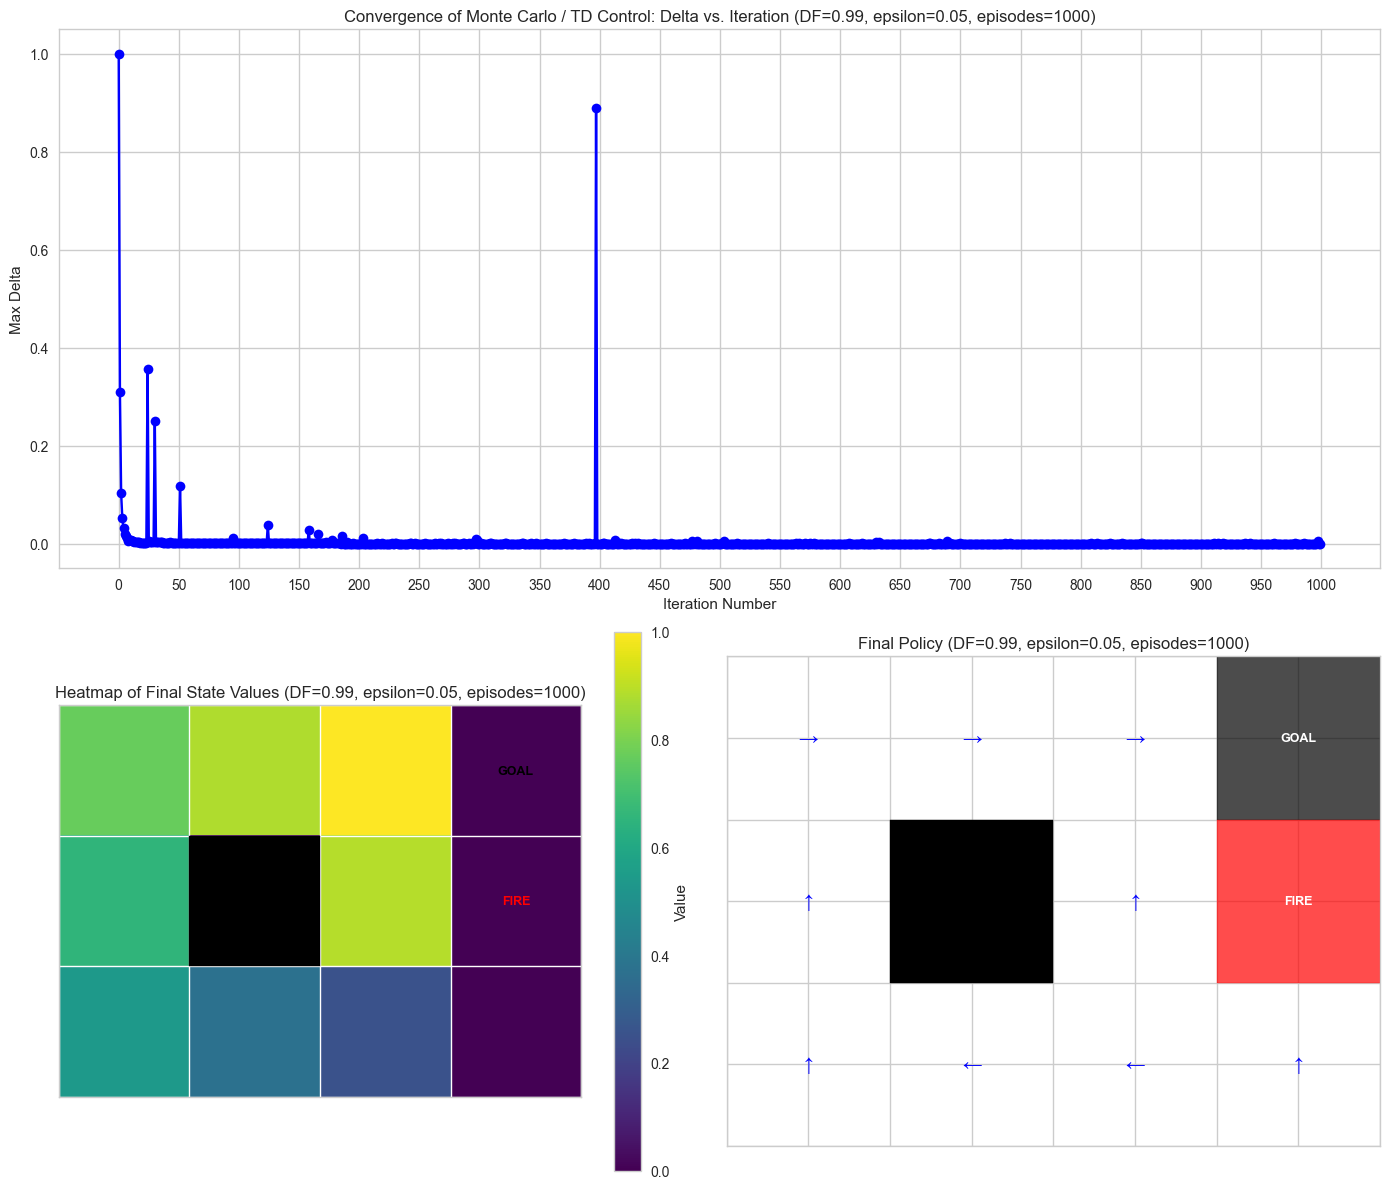

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.05
  Num_Episodes: 10000
Displaying convergence curve, heatmap of final values, and final policy...



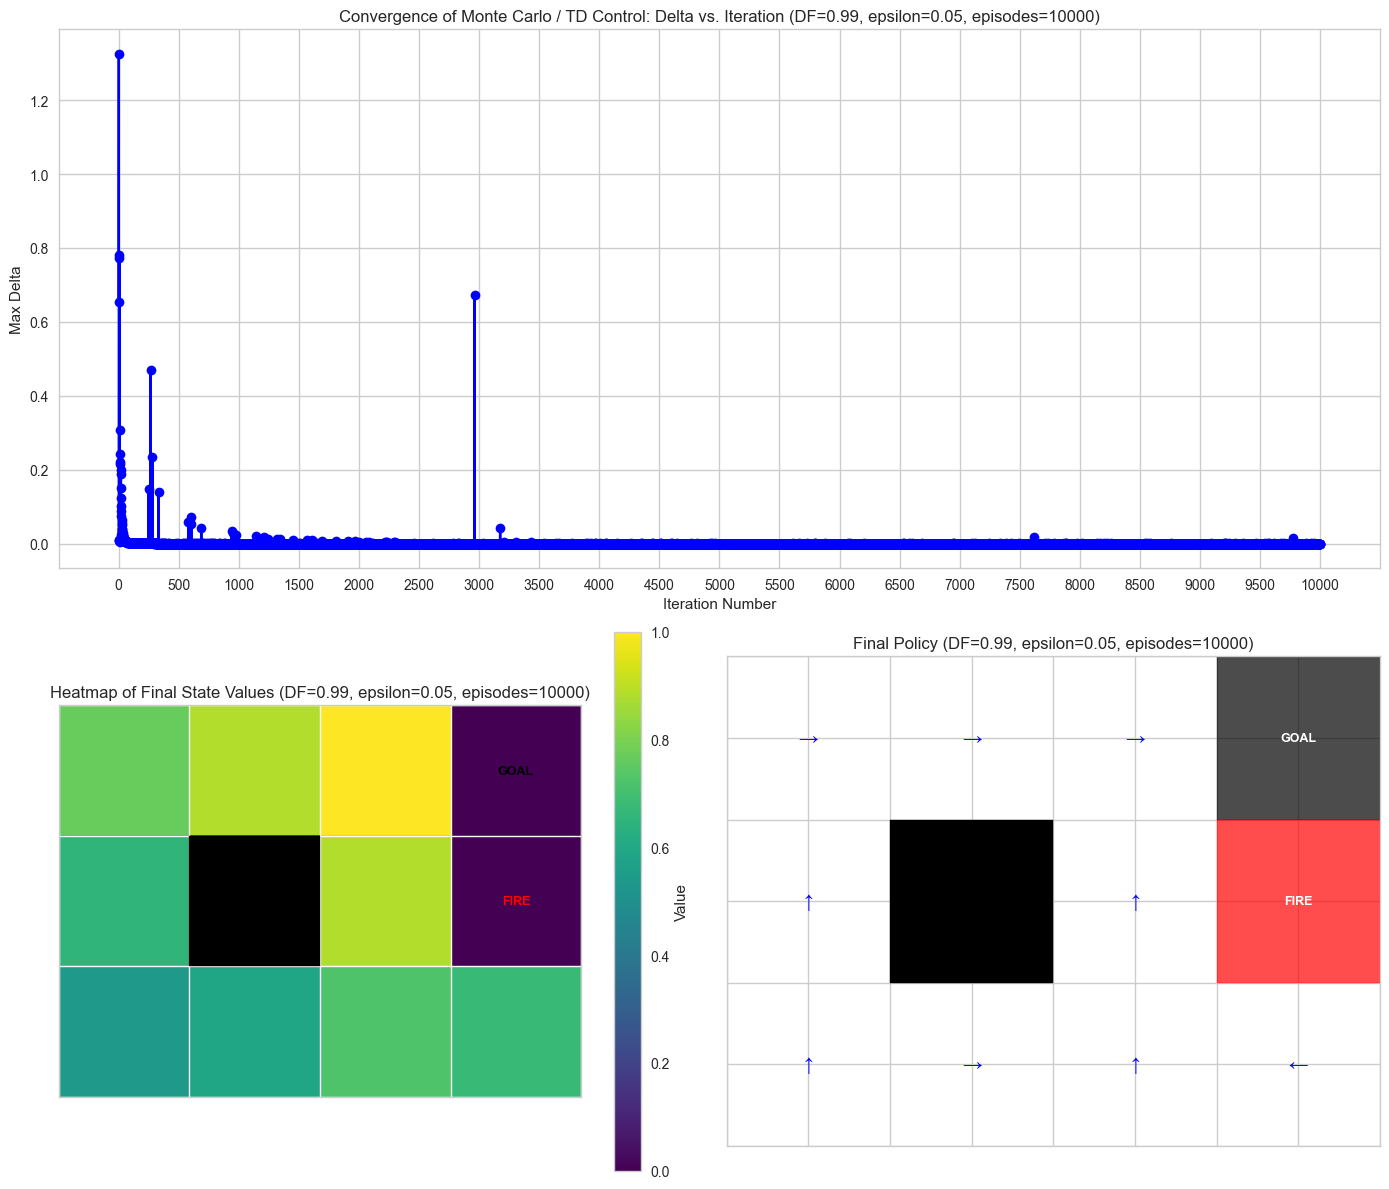

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.05
  Num_Episodes: 1000
Displaying convergence curve, heatmap of final values, and final policy...



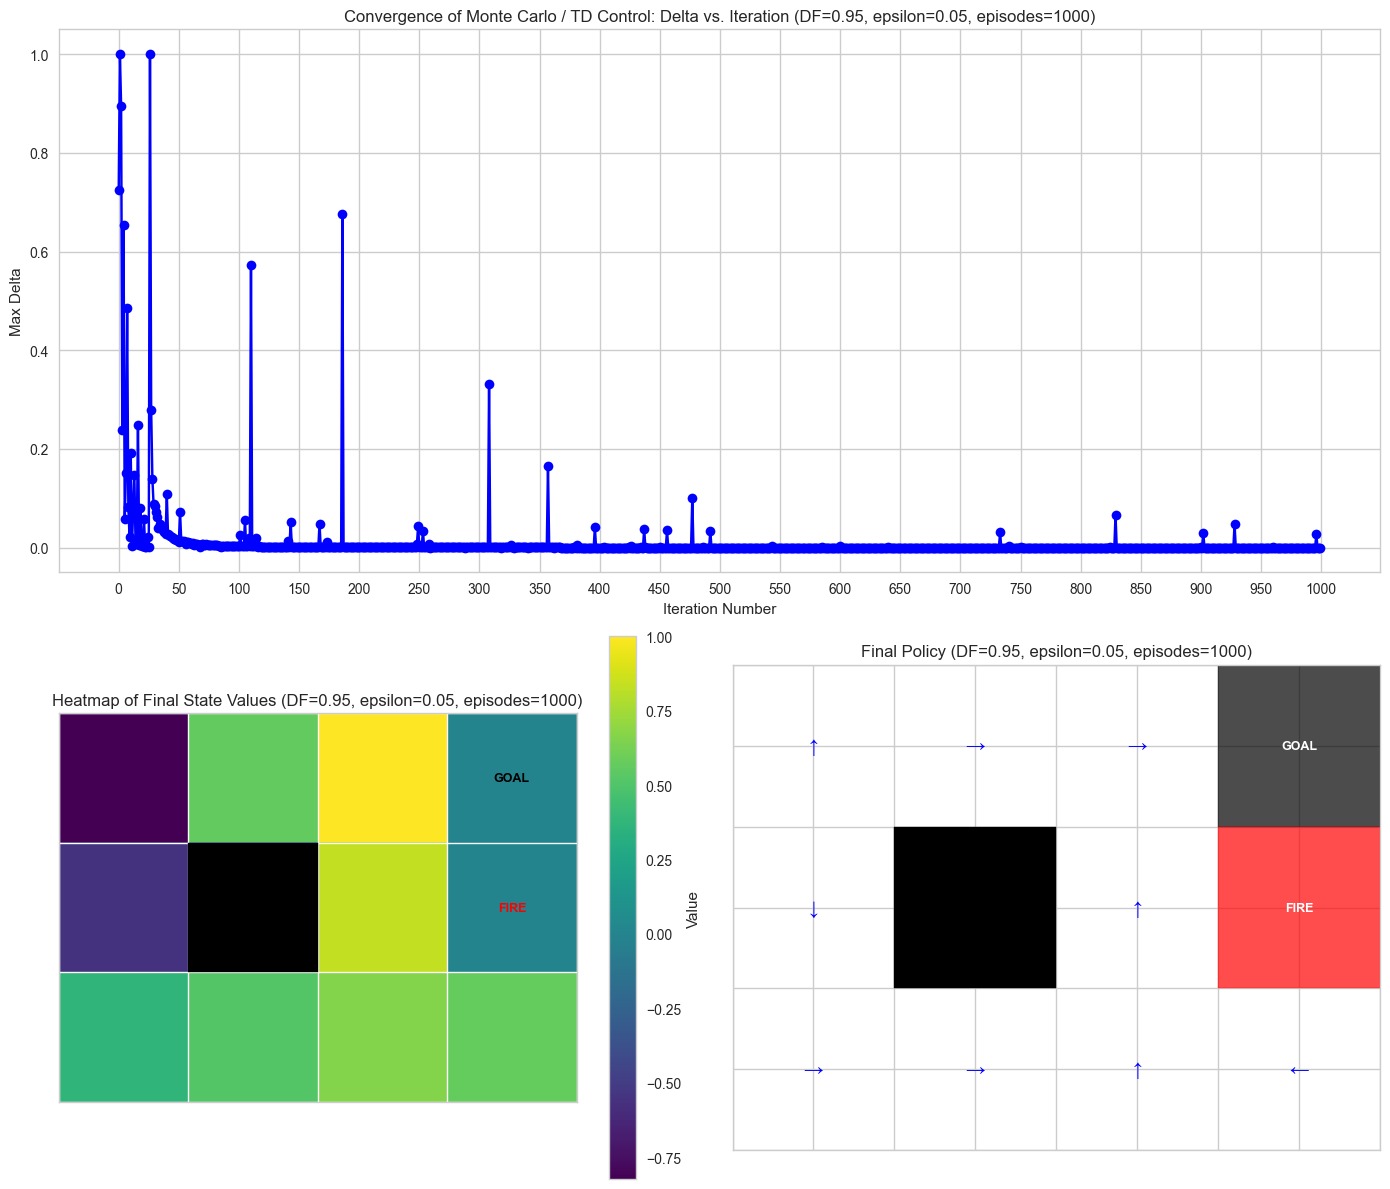

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.05
  Num_Episodes: 10000
Displaying convergence curve, heatmap of final values, and final policy...



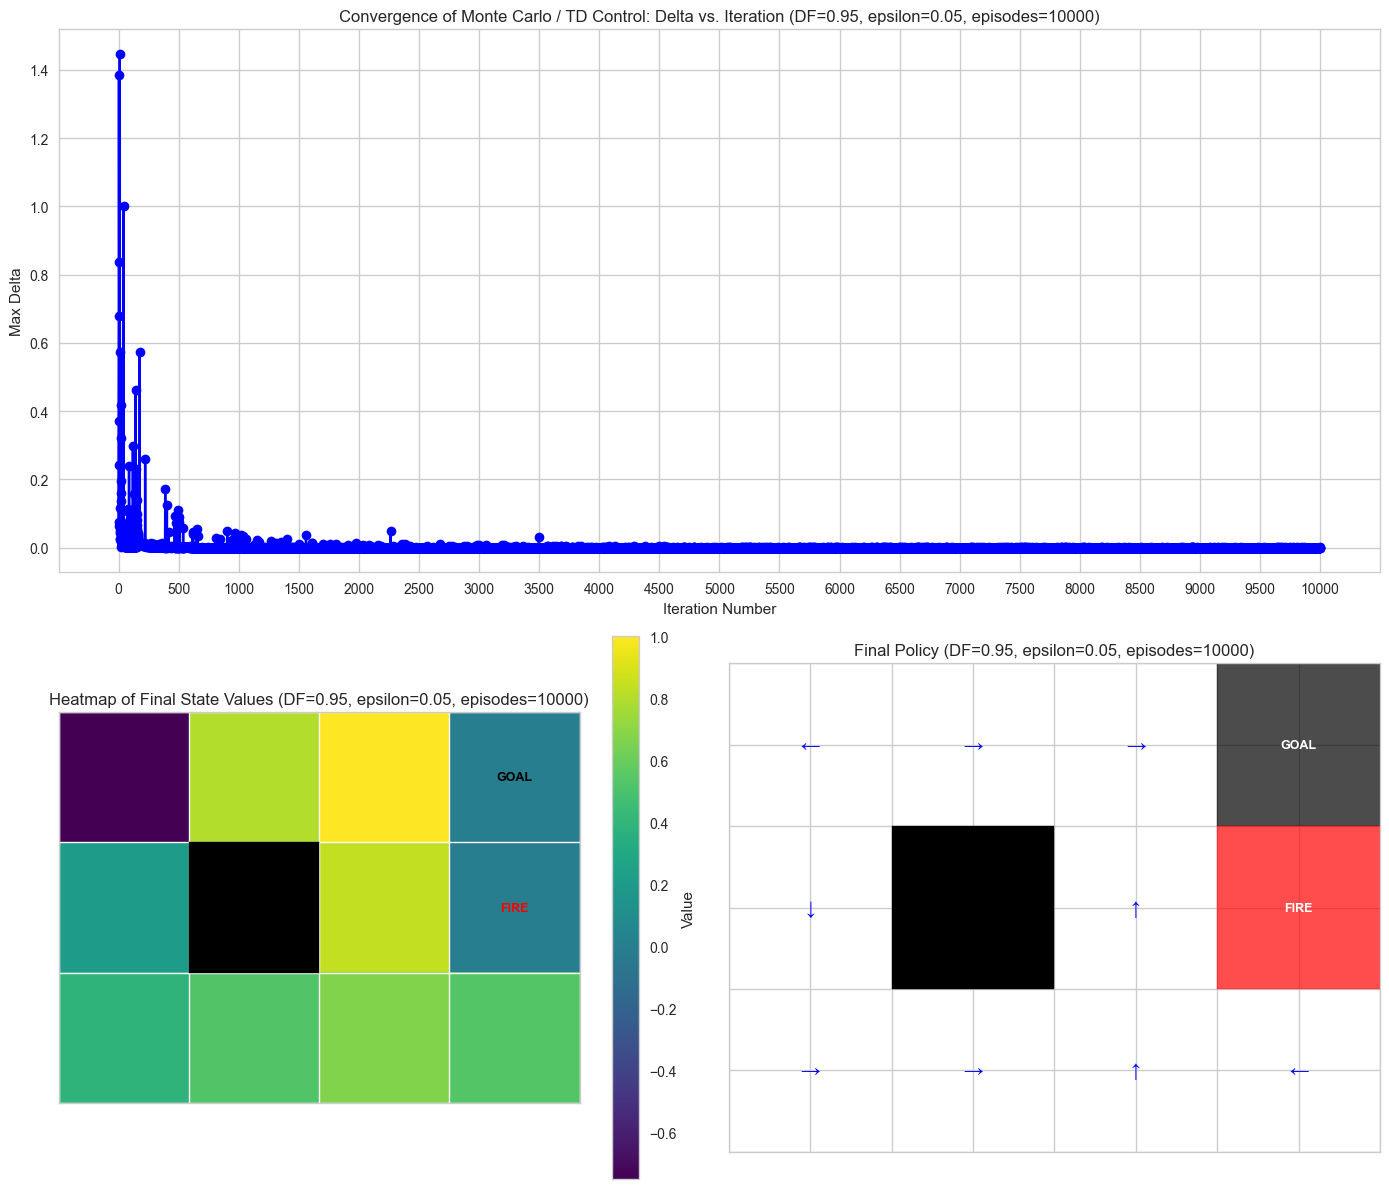

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.1
  Num_Episodes: 1000
Displaying convergence curve, heatmap of final values, and final policy...



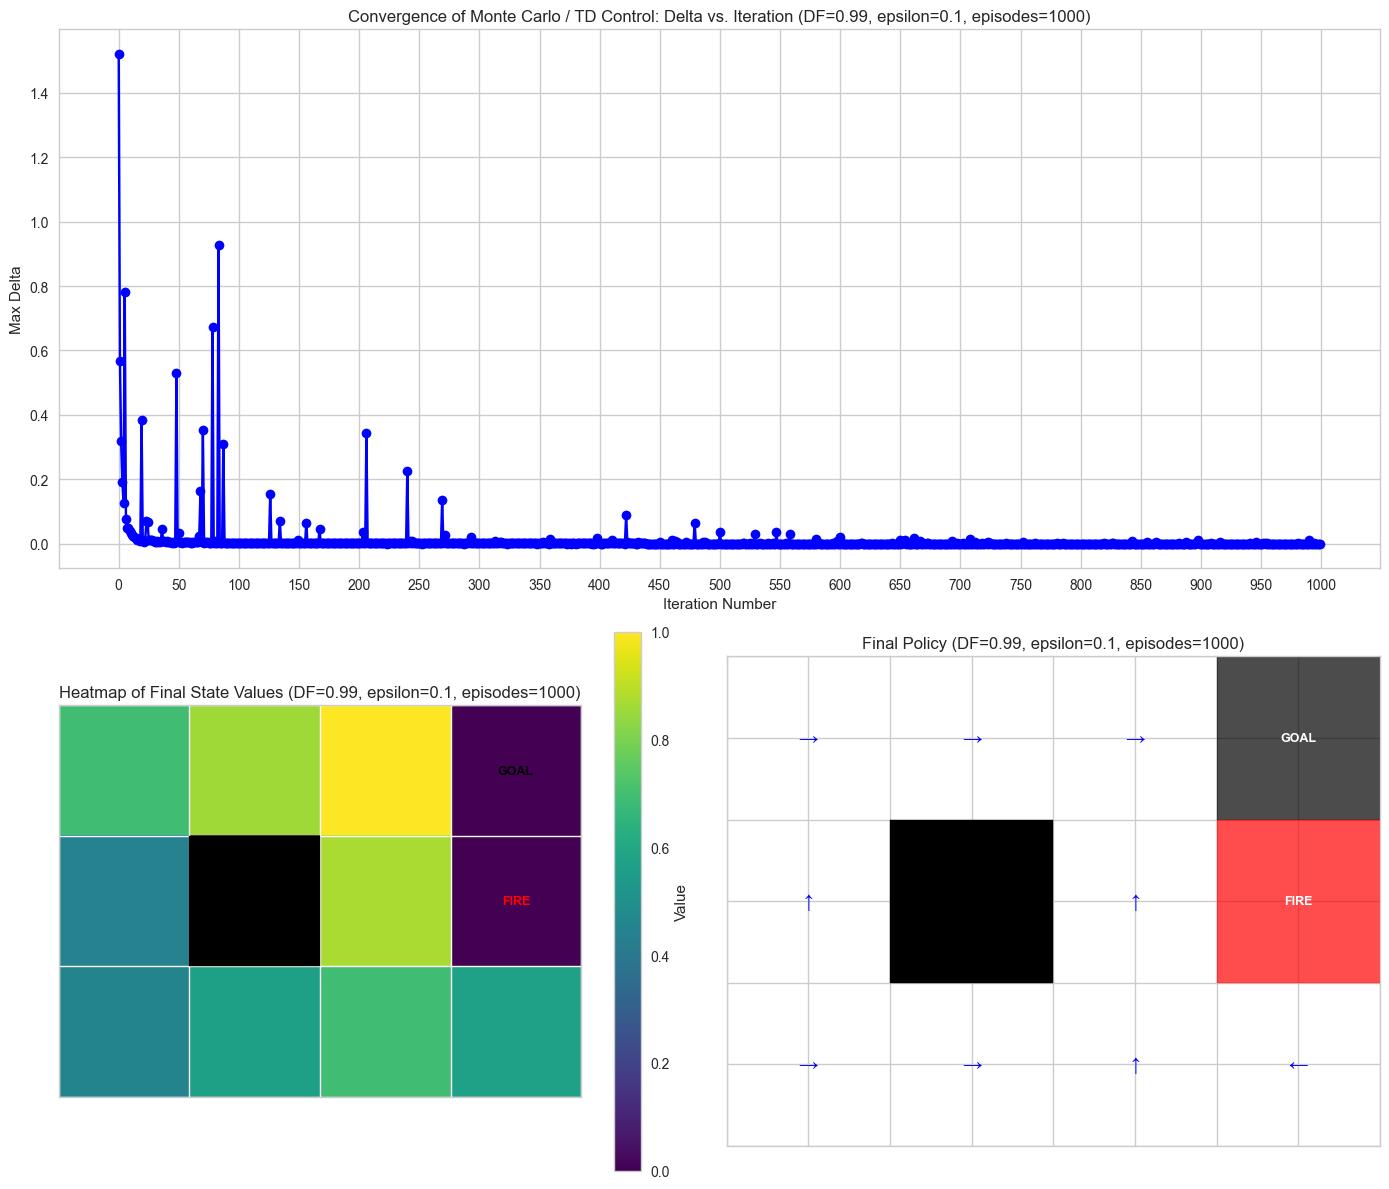

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.1
  Num_Episodes: 10000
Displaying convergence curve, heatmap of final values, and final policy...



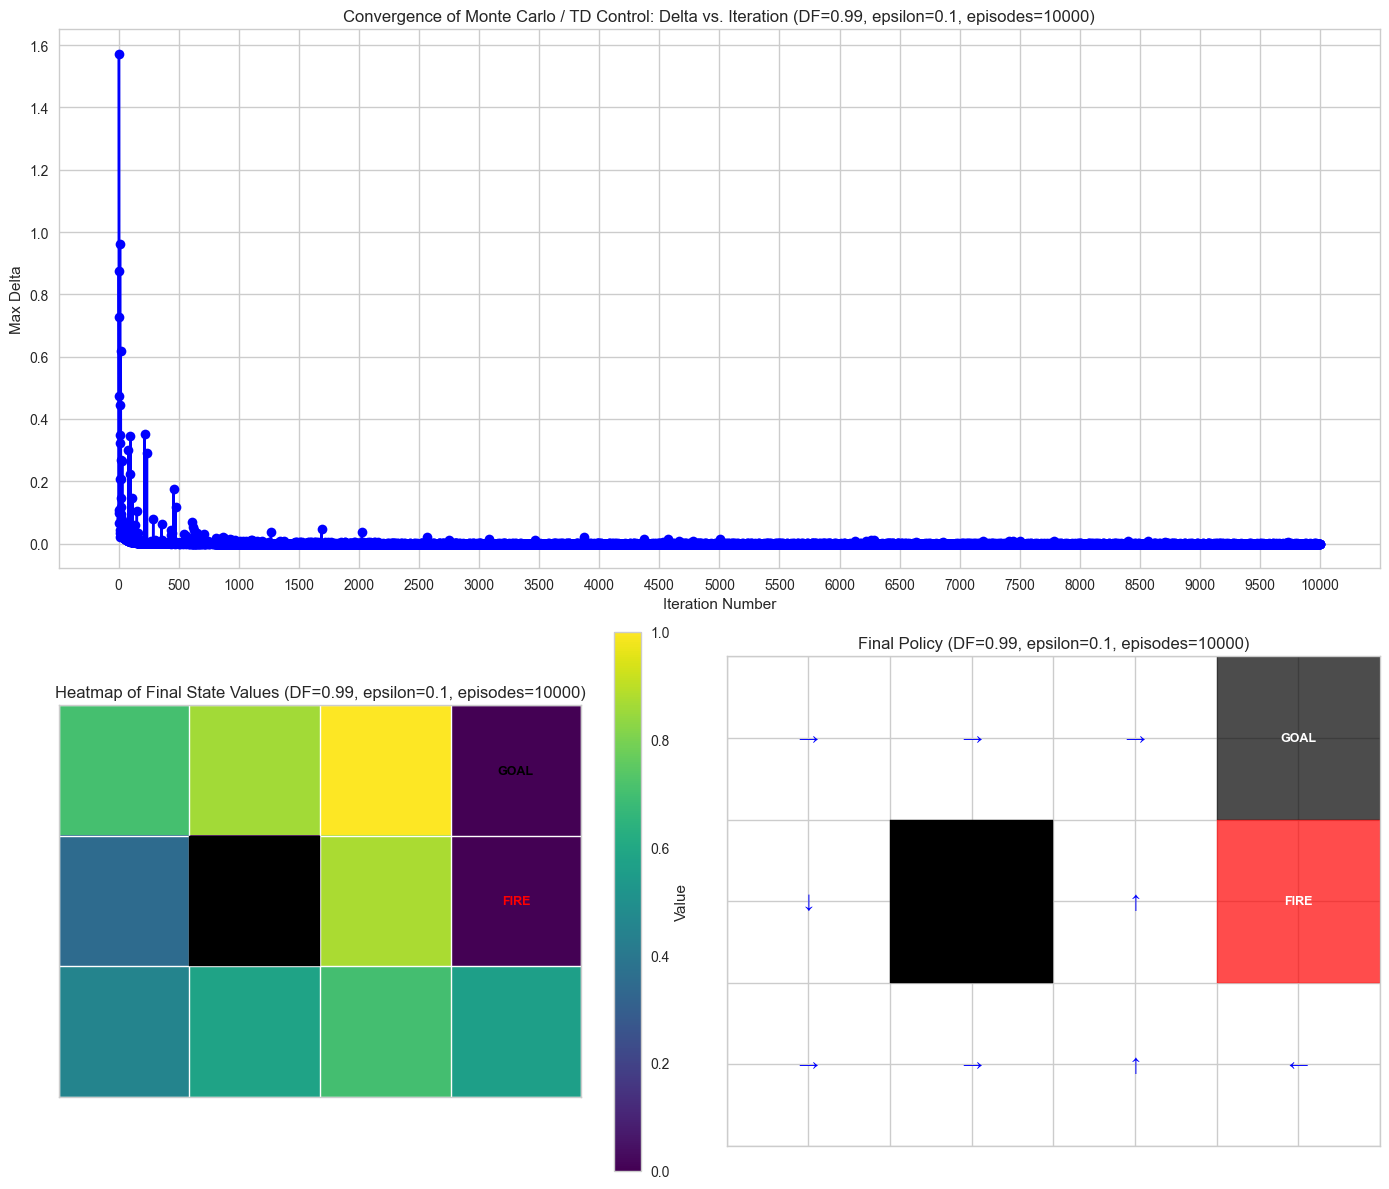

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.1
  Num_Episodes: 1000
Displaying convergence curve, heatmap of final values, and final policy...



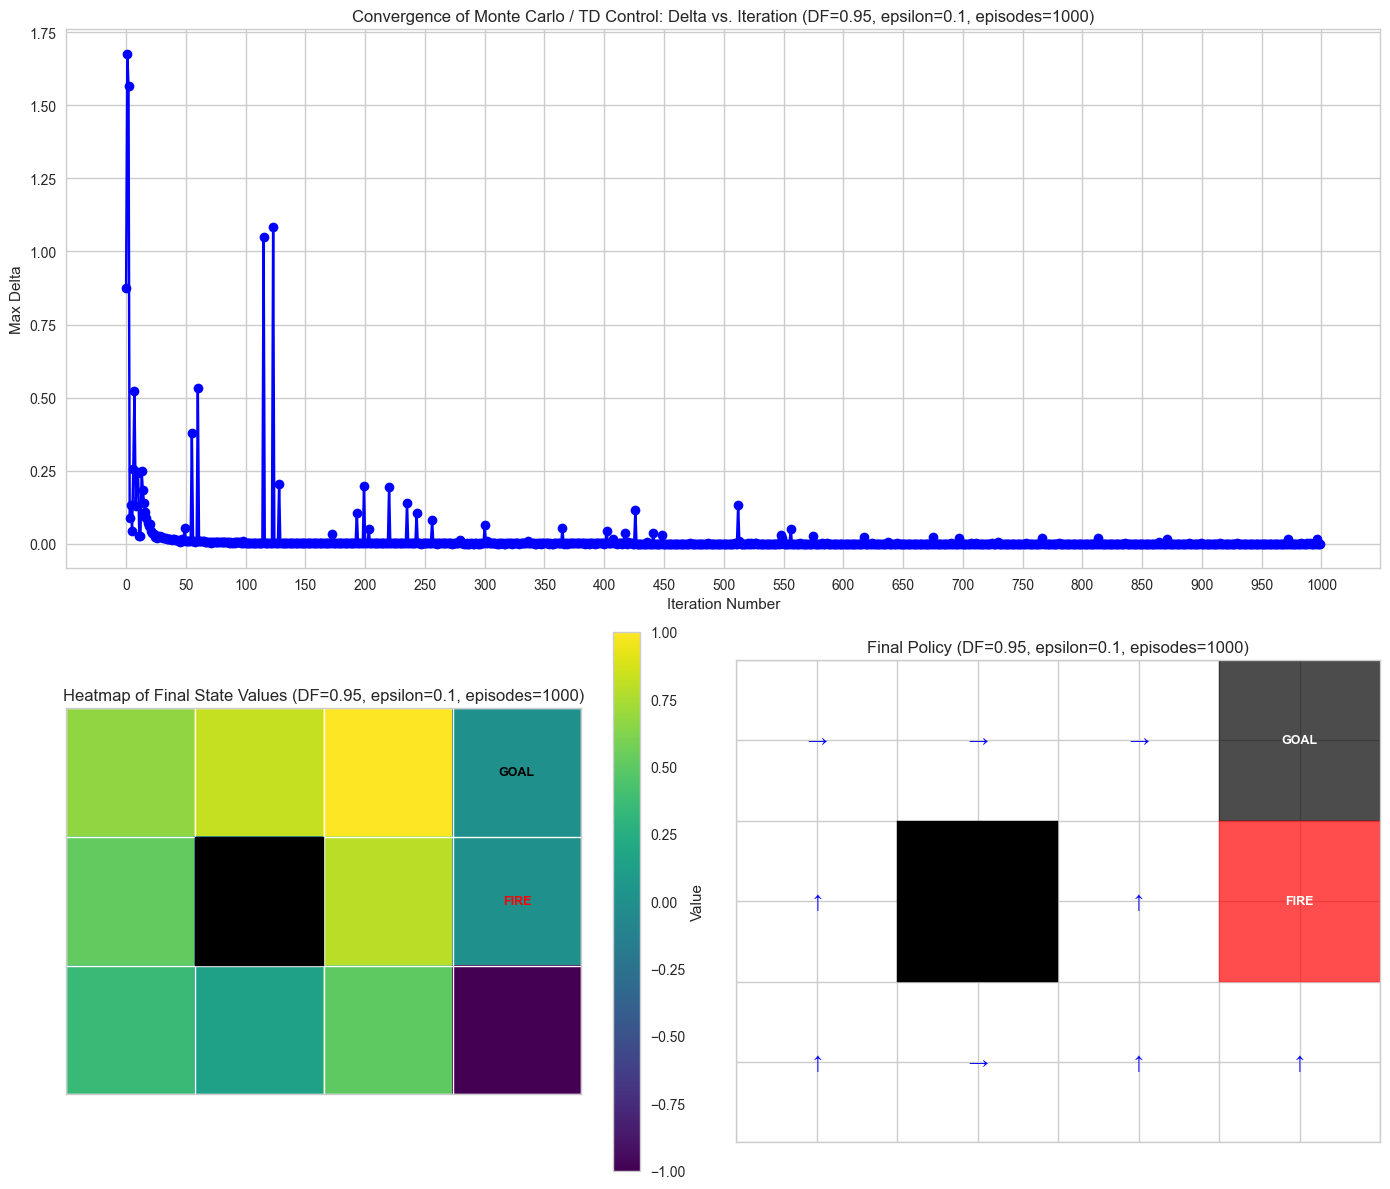

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.1
  Num_Episodes: 10000
Displaying convergence curve, heatmap of final values, and final policy...



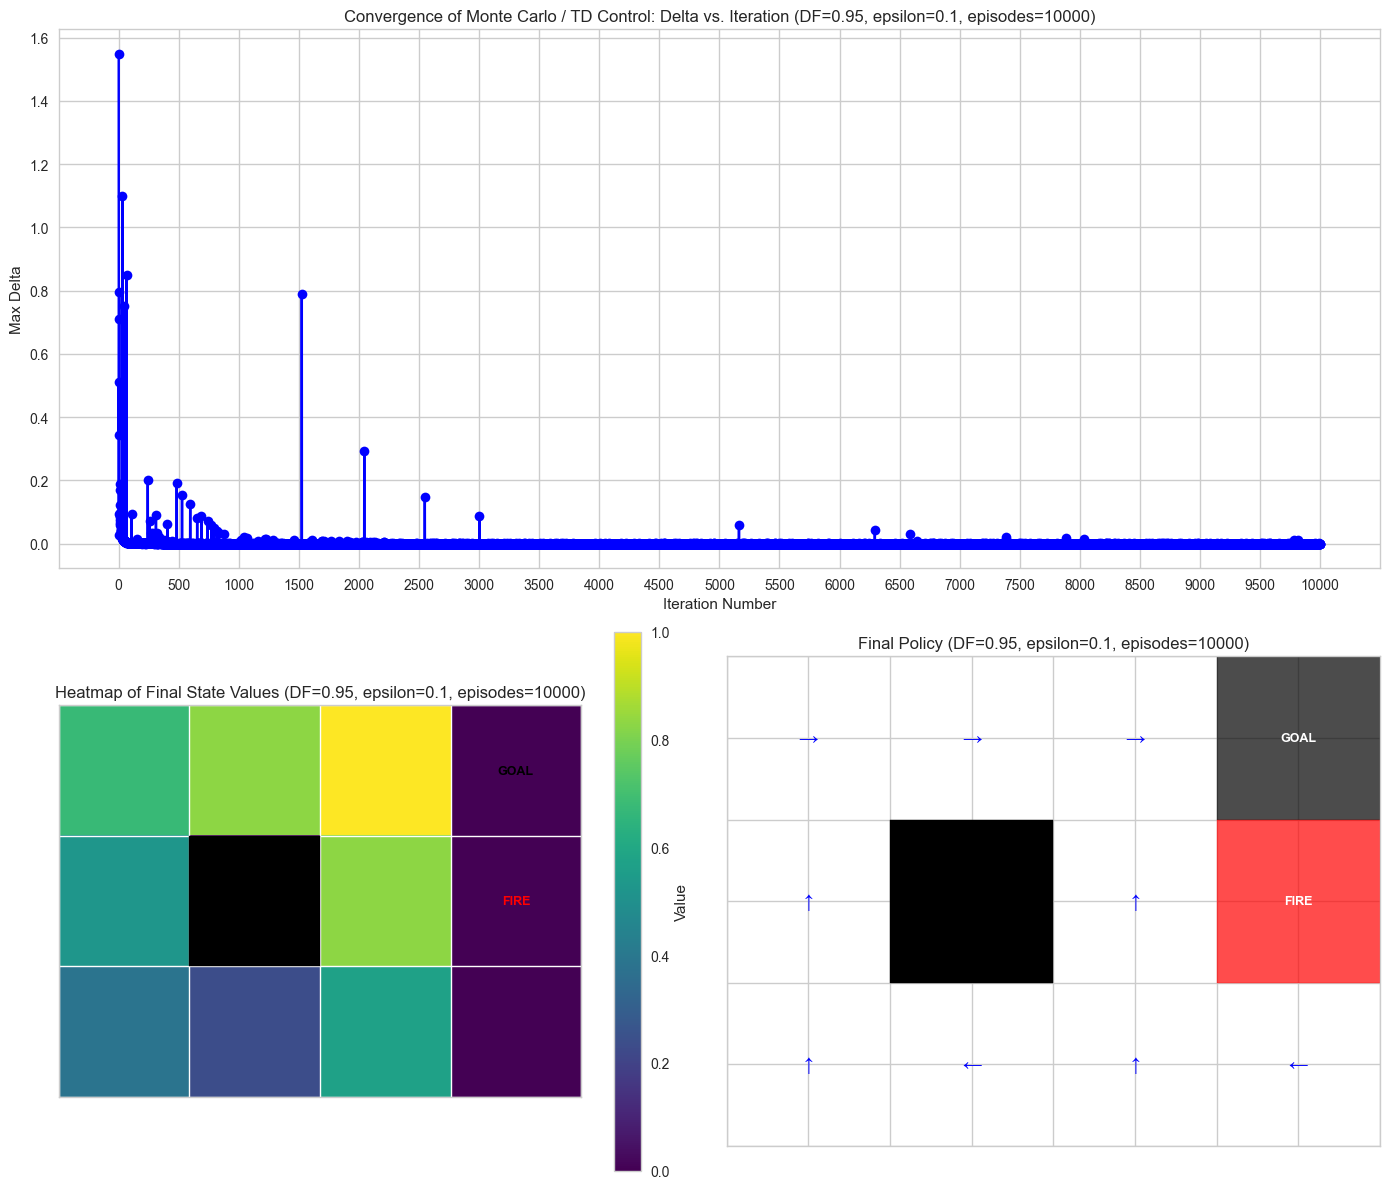

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Num_Episodes: 1000
Displaying convergence curve, heatmap of final values, and final policy...



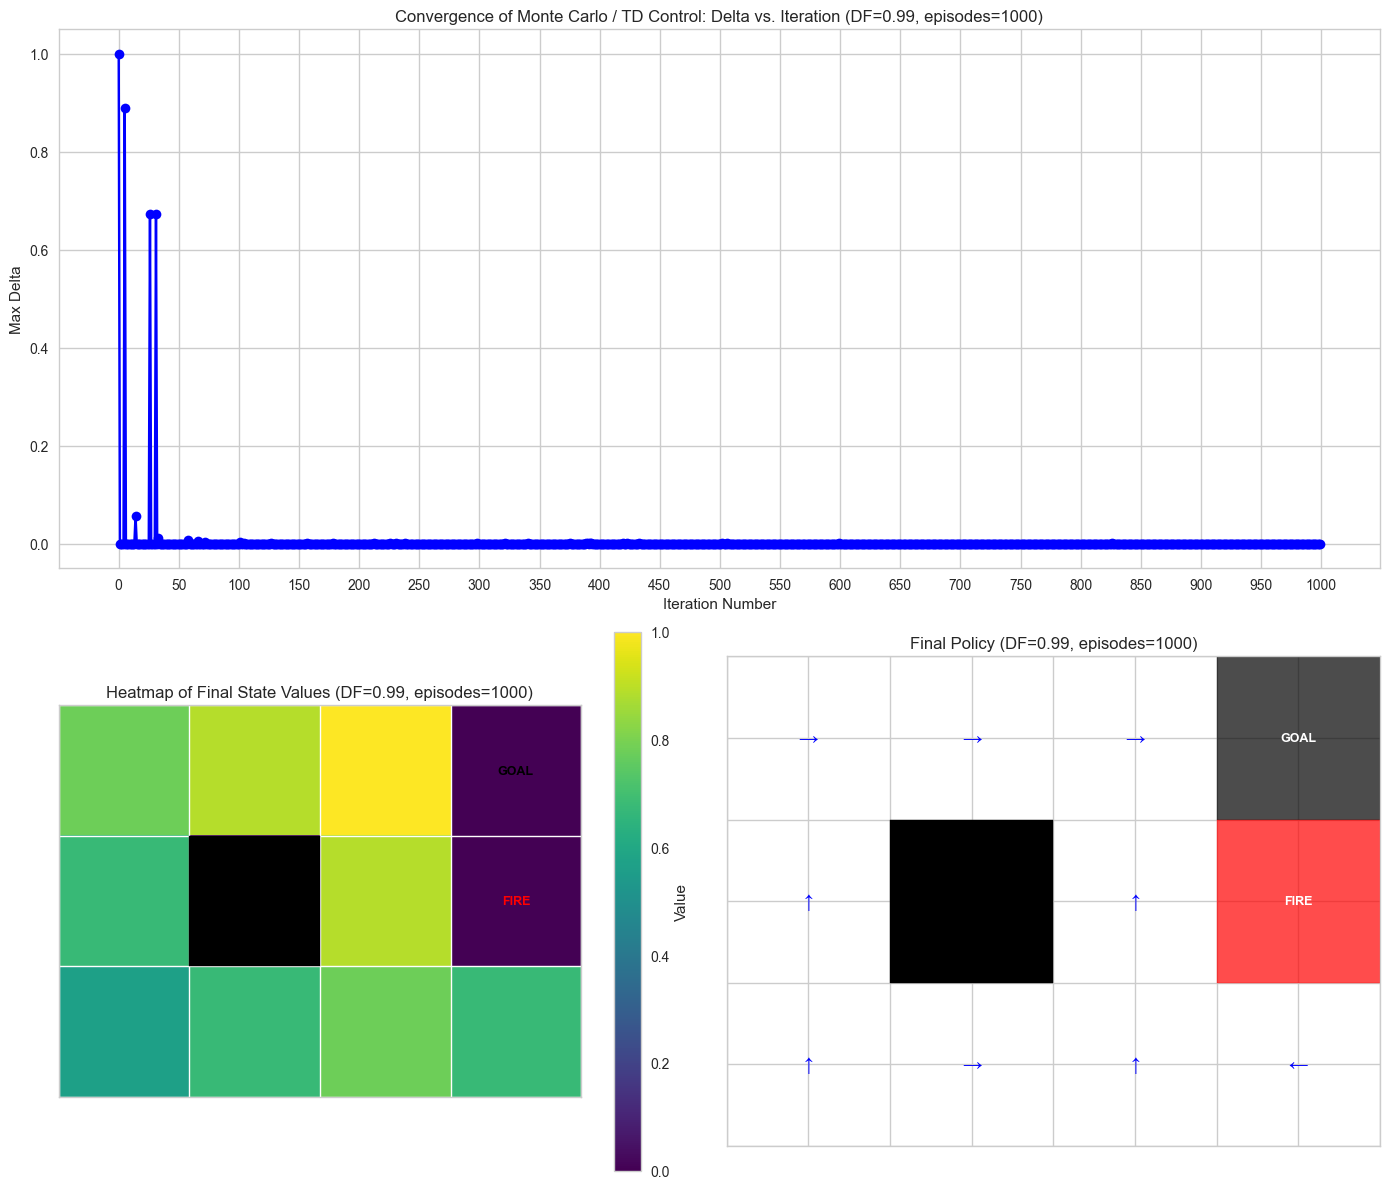

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Num_Episodes: 10000
Displaying convergence curve, heatmap of final values, and final policy...



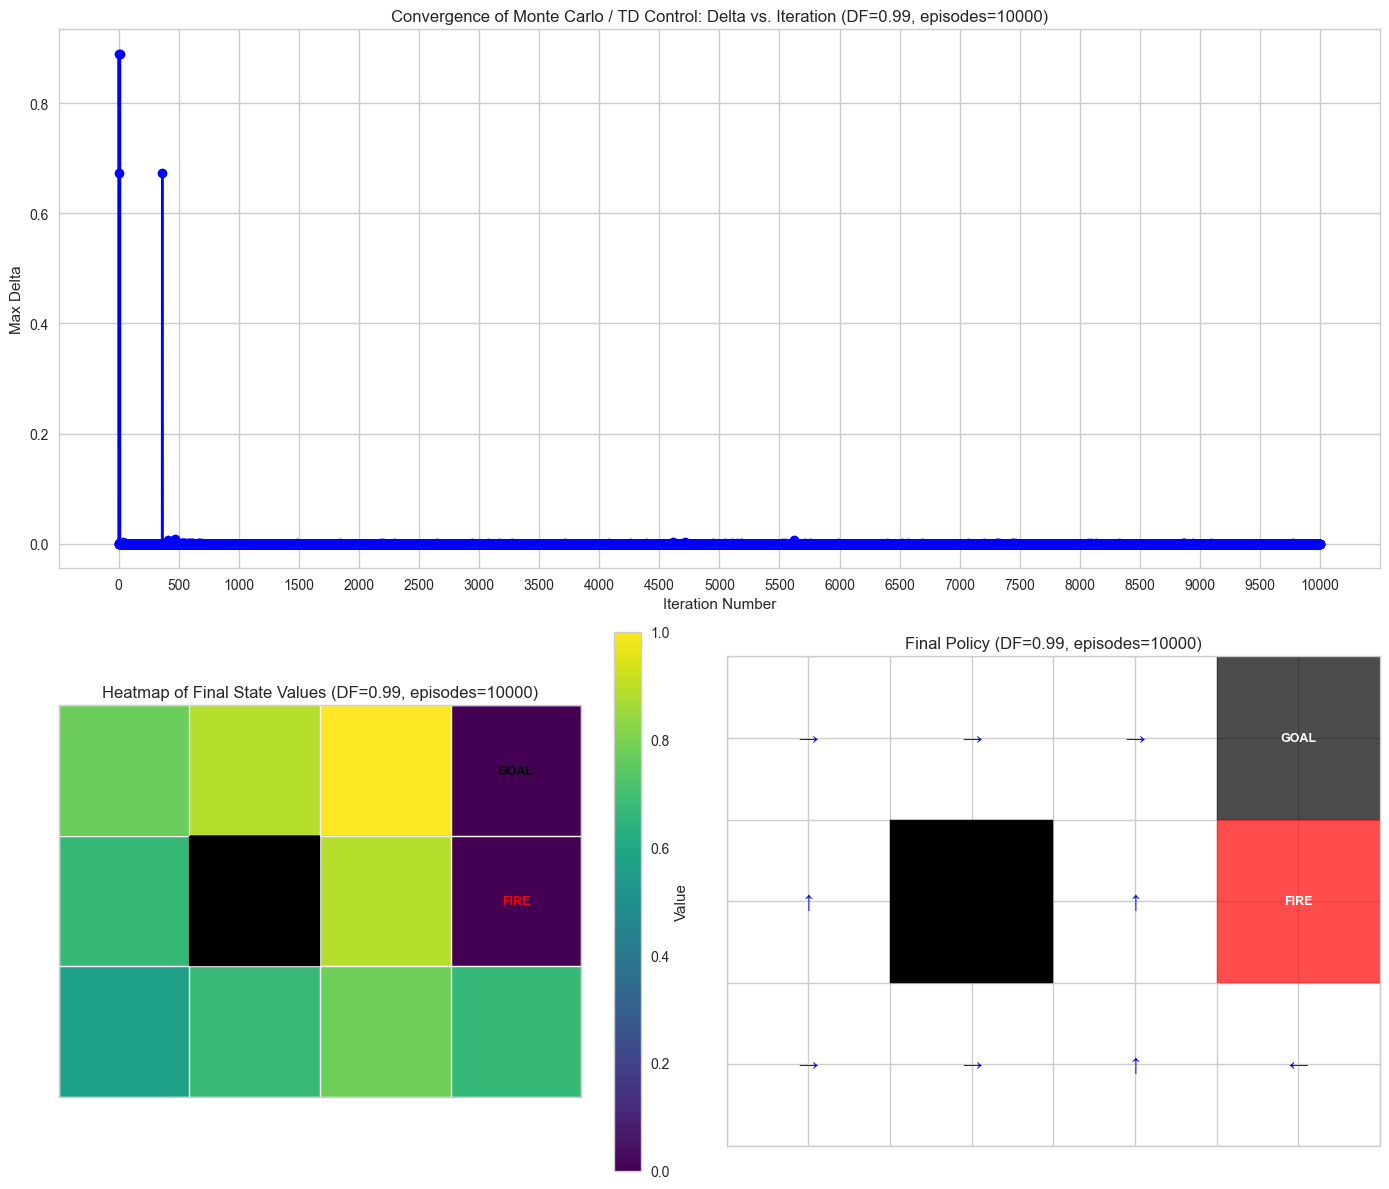

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Num_Episodes: 1000
Displaying convergence curve, heatmap of final values, and final policy...



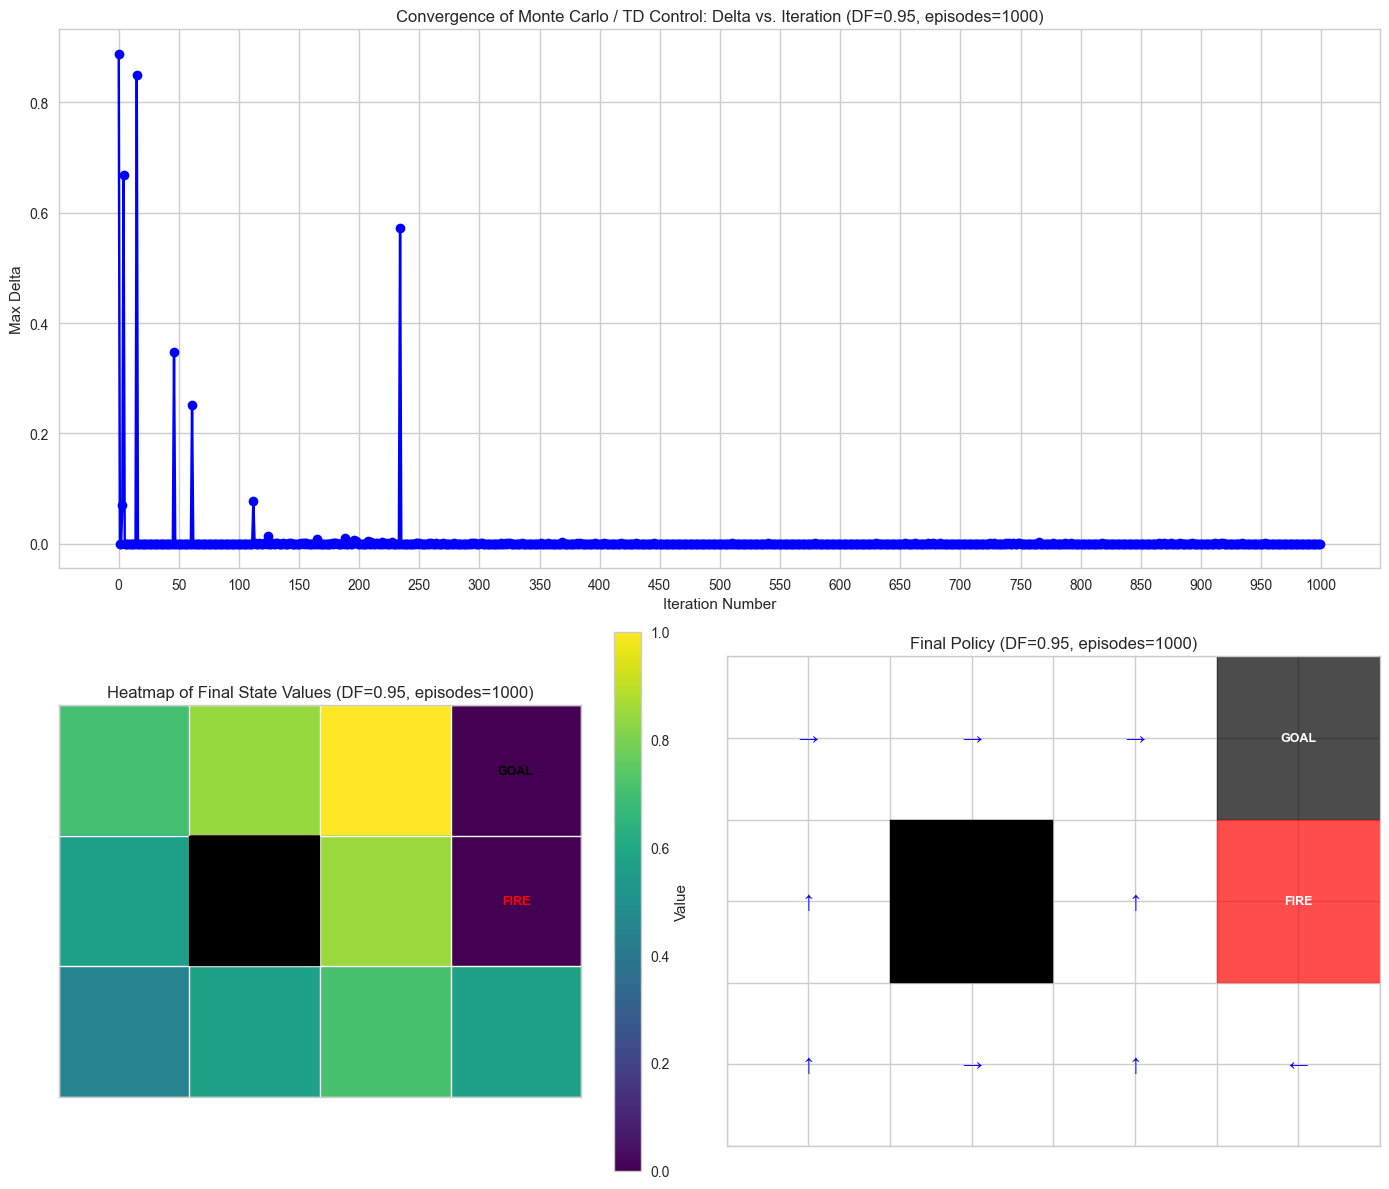

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Num_Episodes: 10000
Displaying convergence curve, heatmap of final values, and final policy...



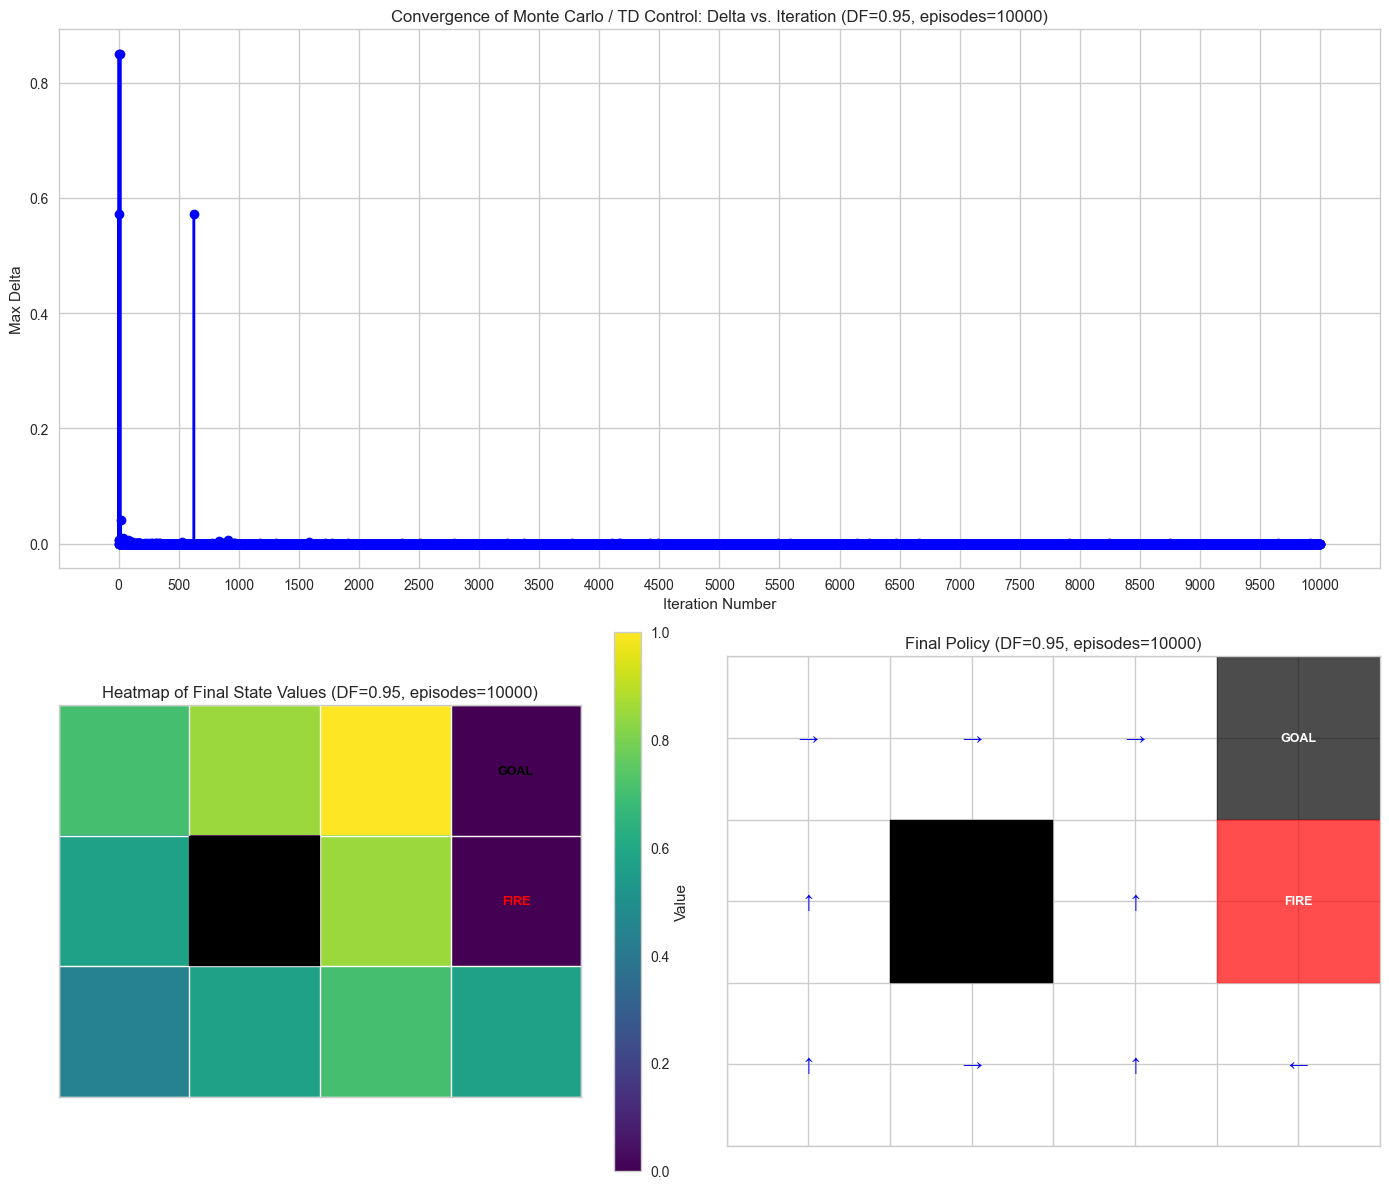

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.05
  Num_Episodes: 1000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



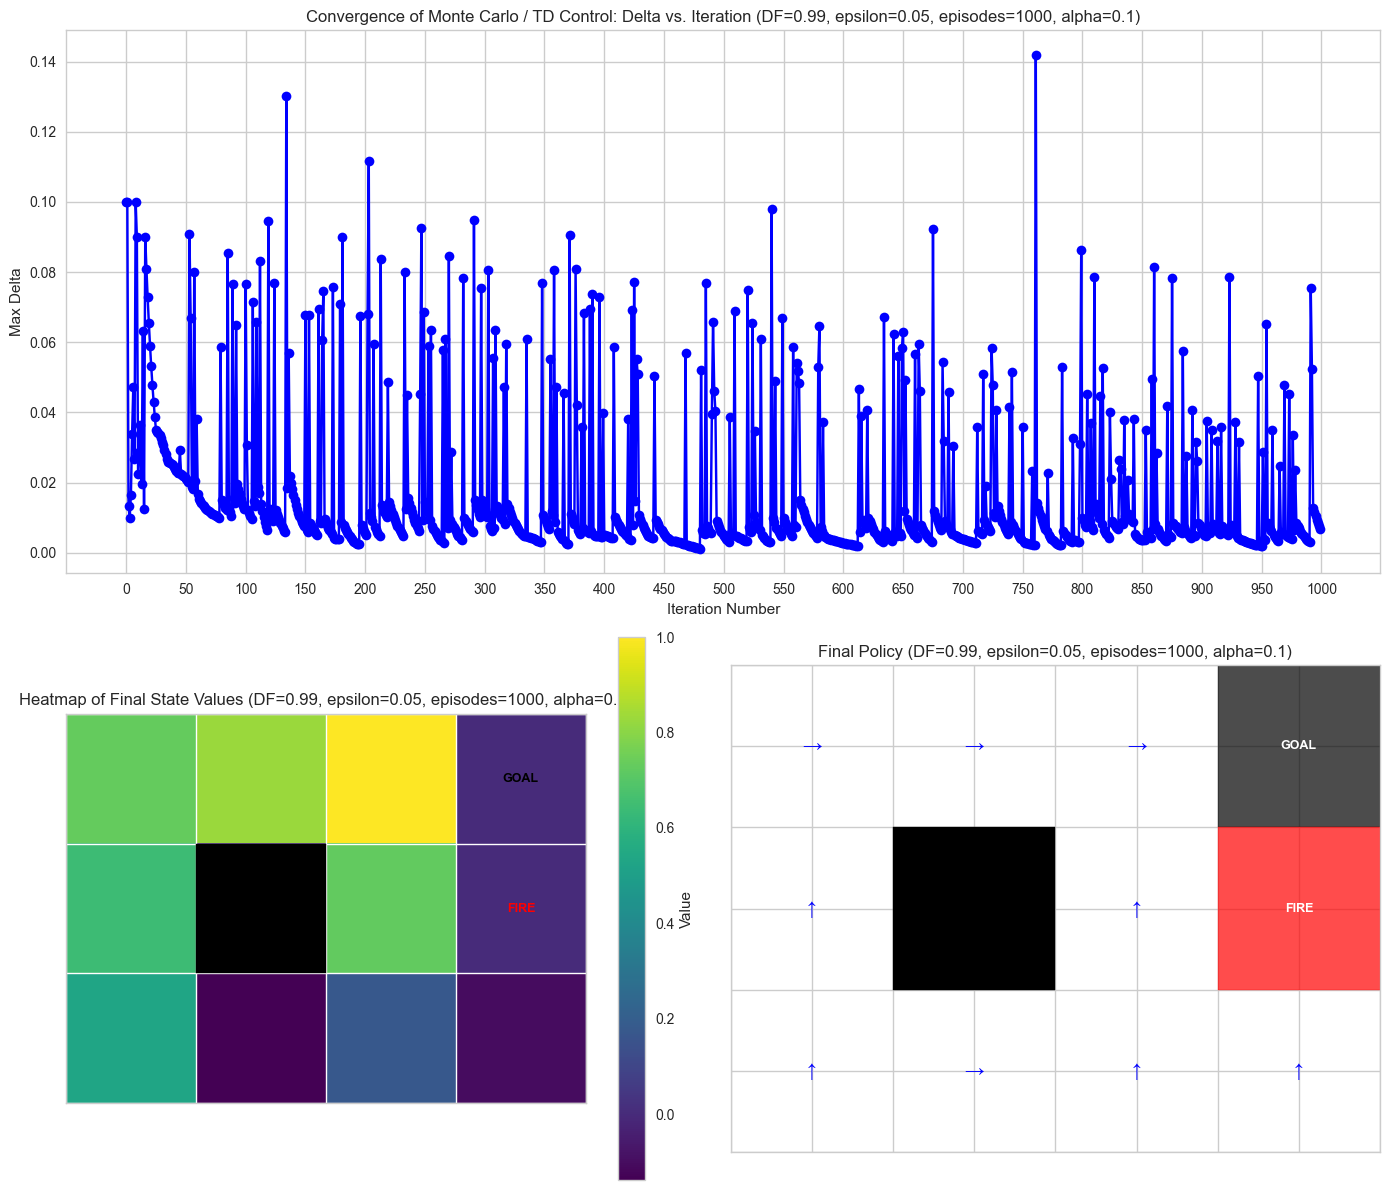

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.05
  Num_Episodes: 10000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



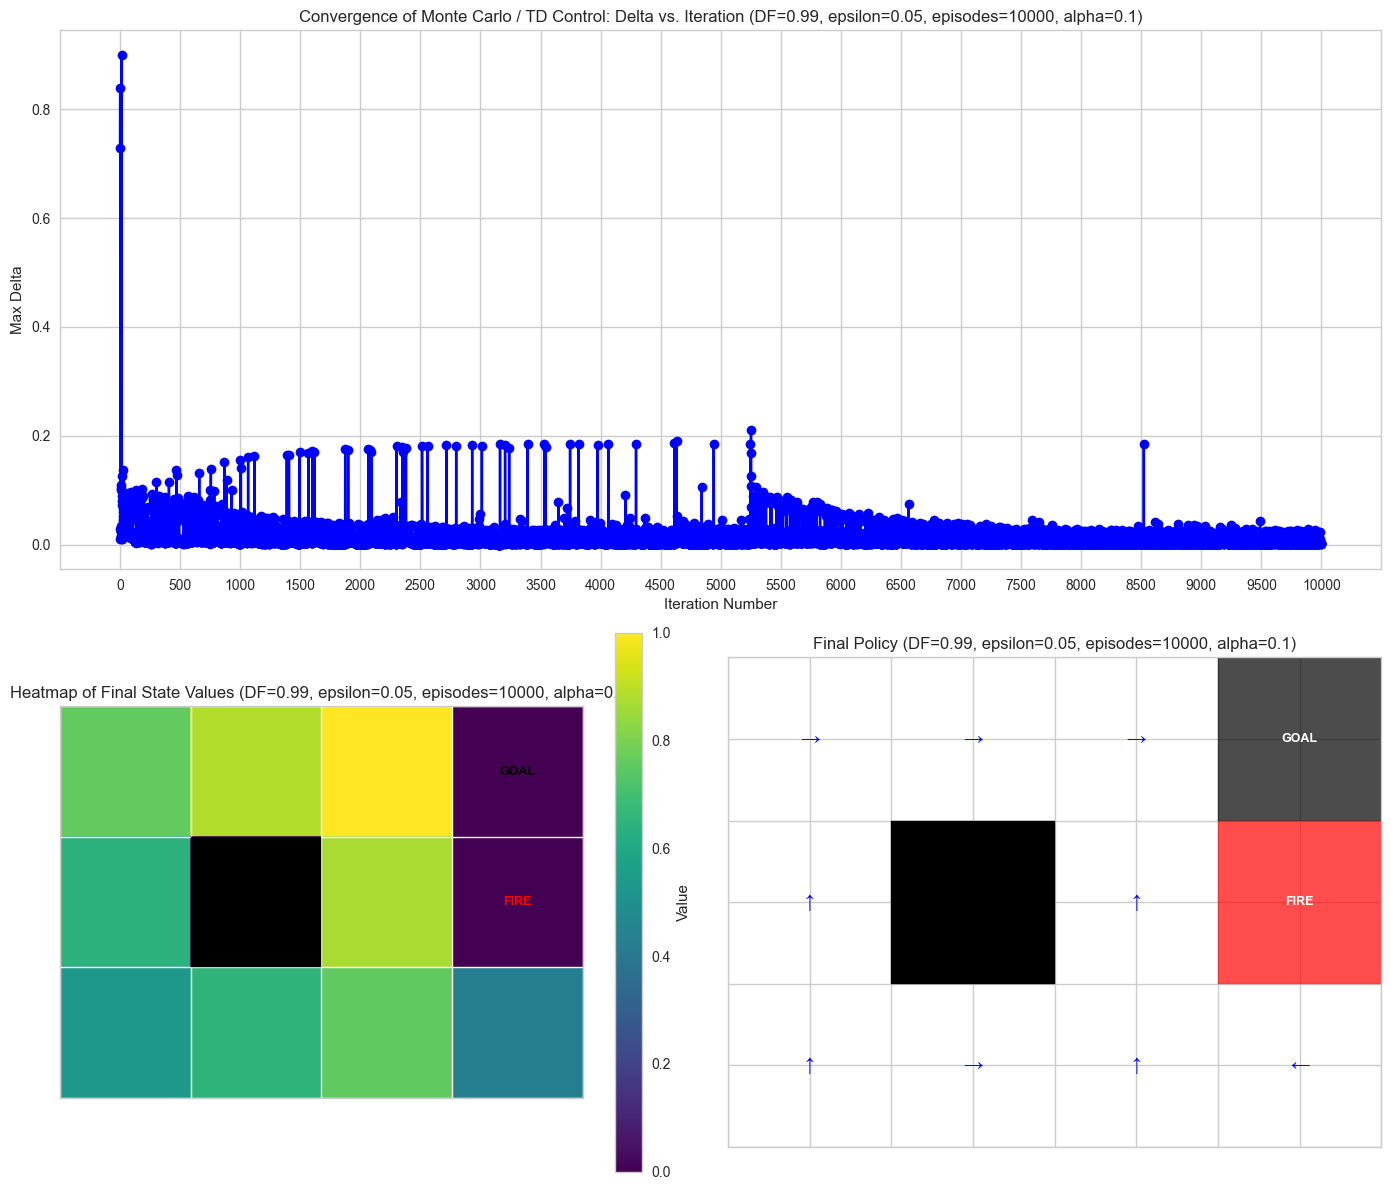

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.05
  Num_Episodes: 1000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



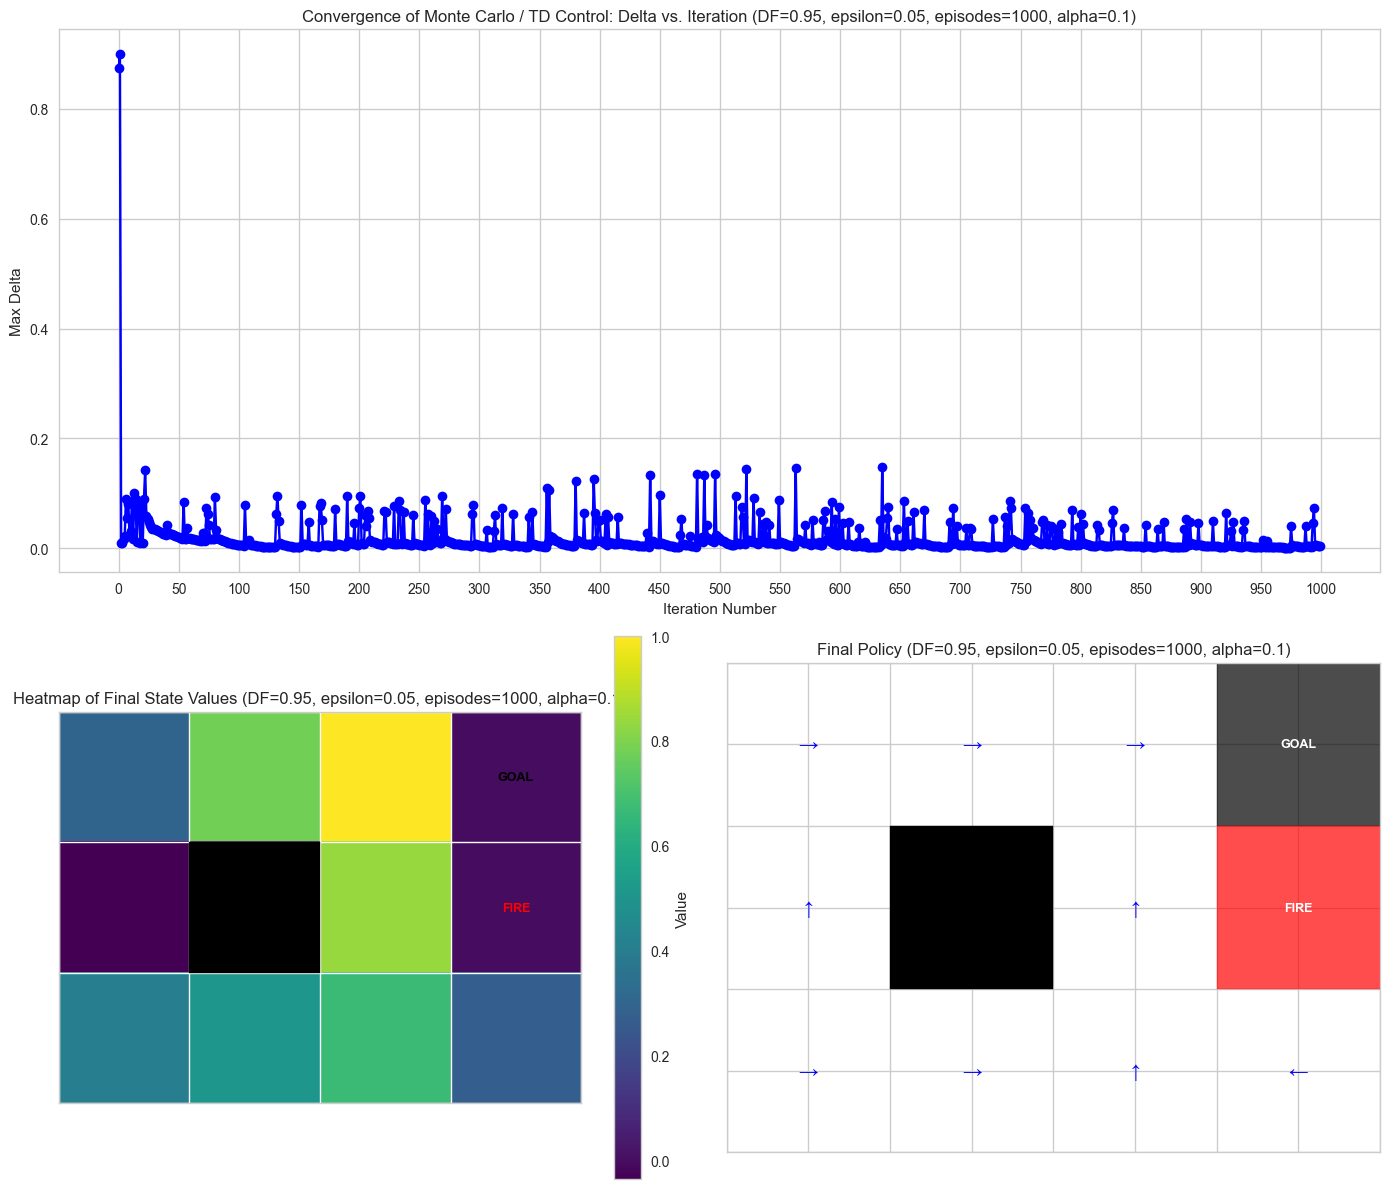

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.05
  Num_Episodes: 10000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



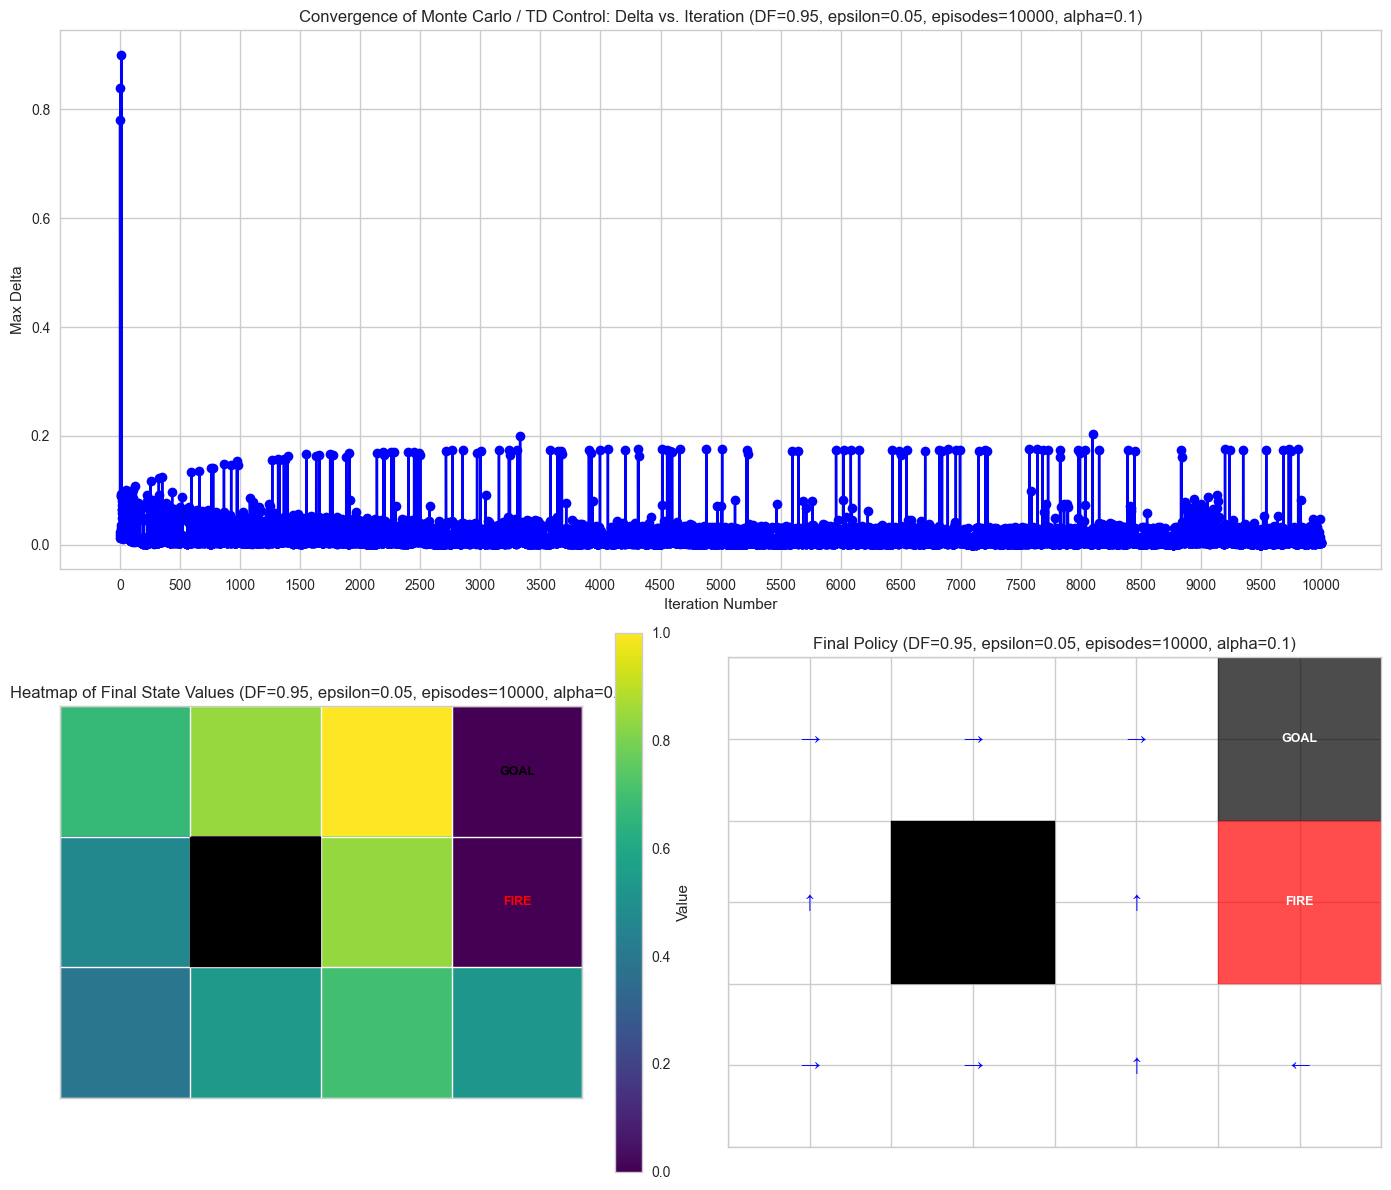

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.1
  Num_Episodes: 1000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



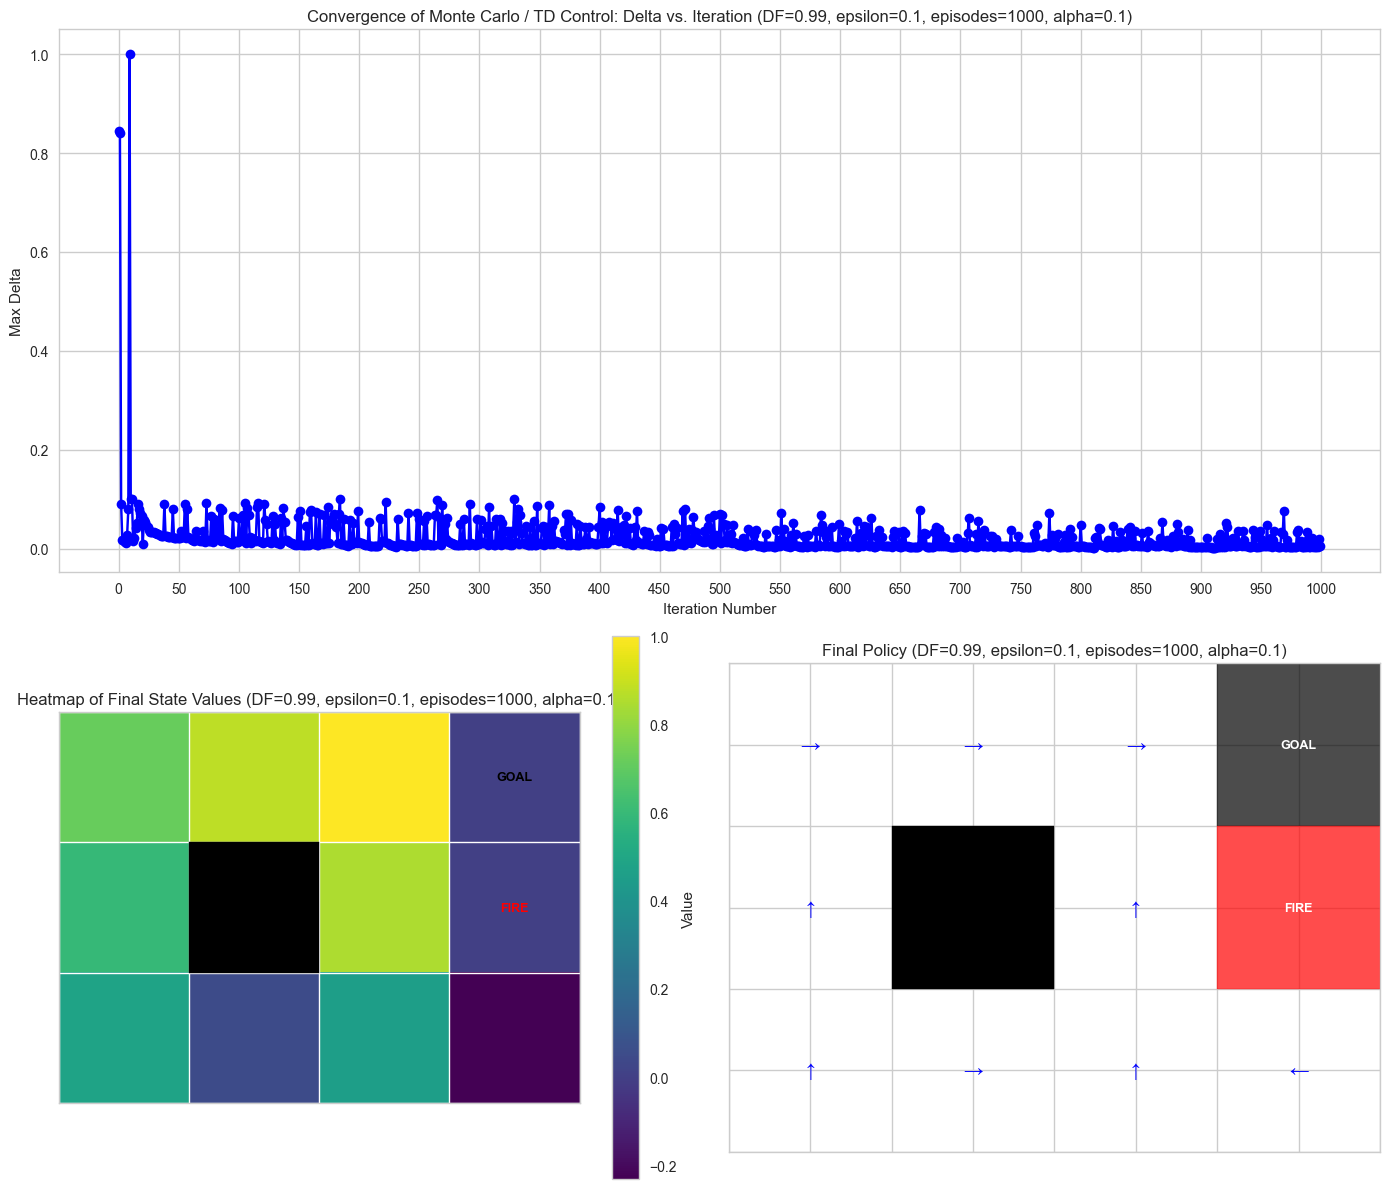

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.1
  Num_Episodes: 10000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



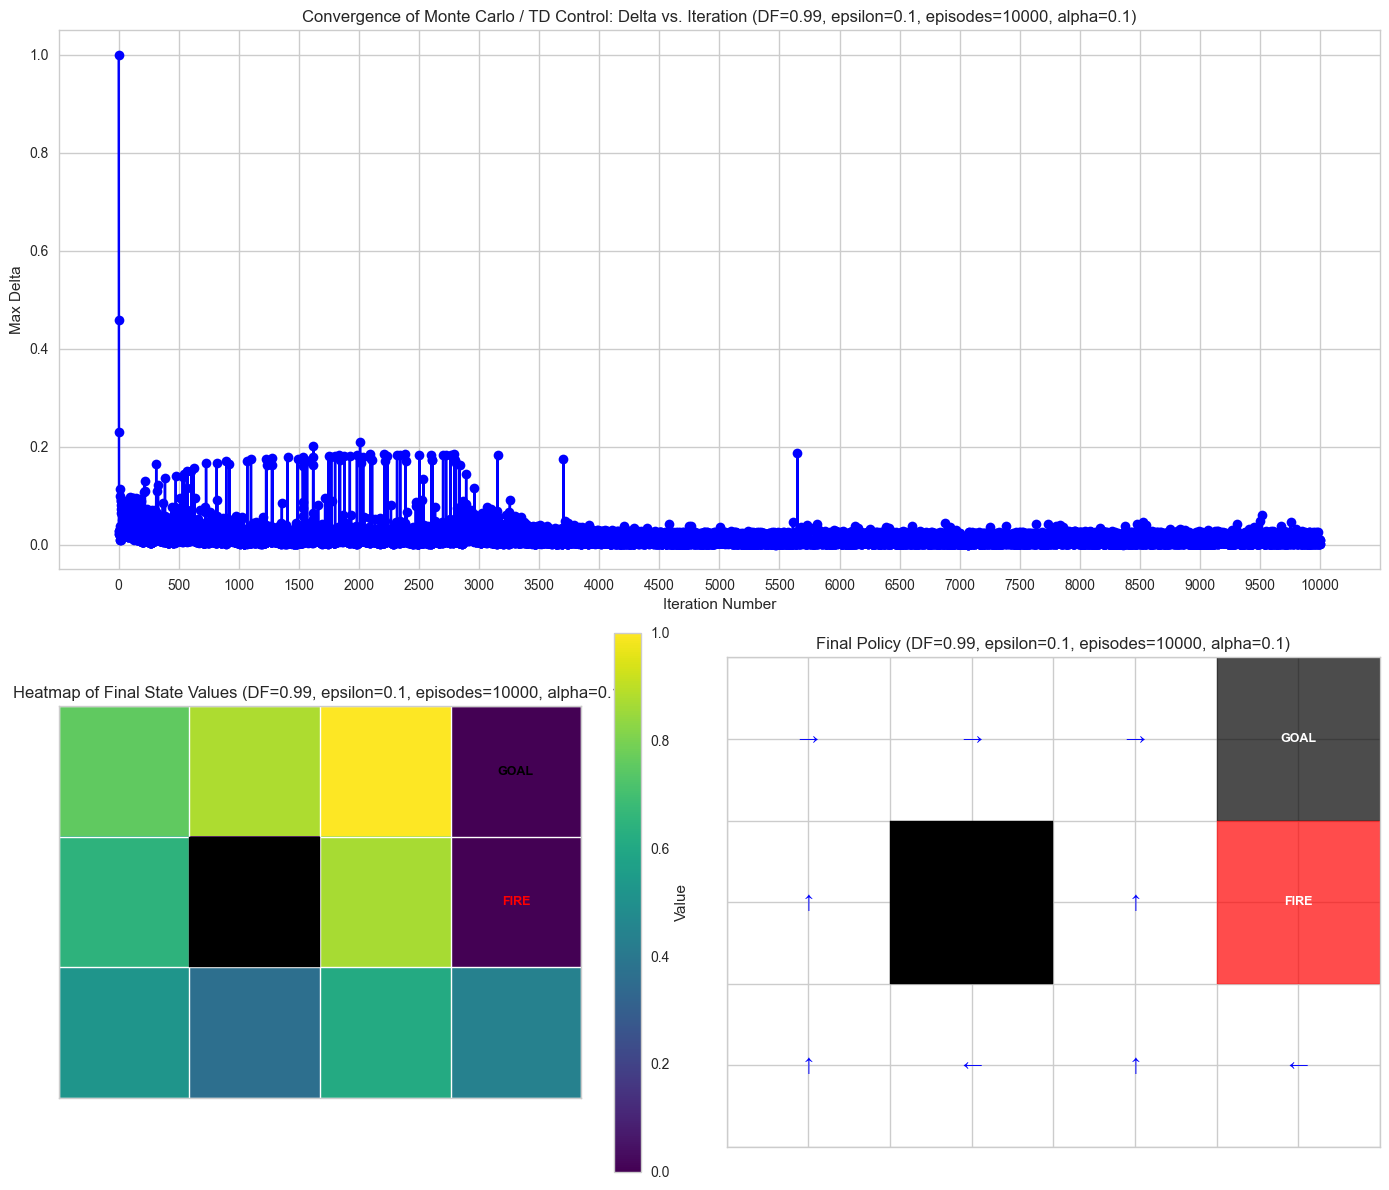

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.1
  Num_Episodes: 1000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



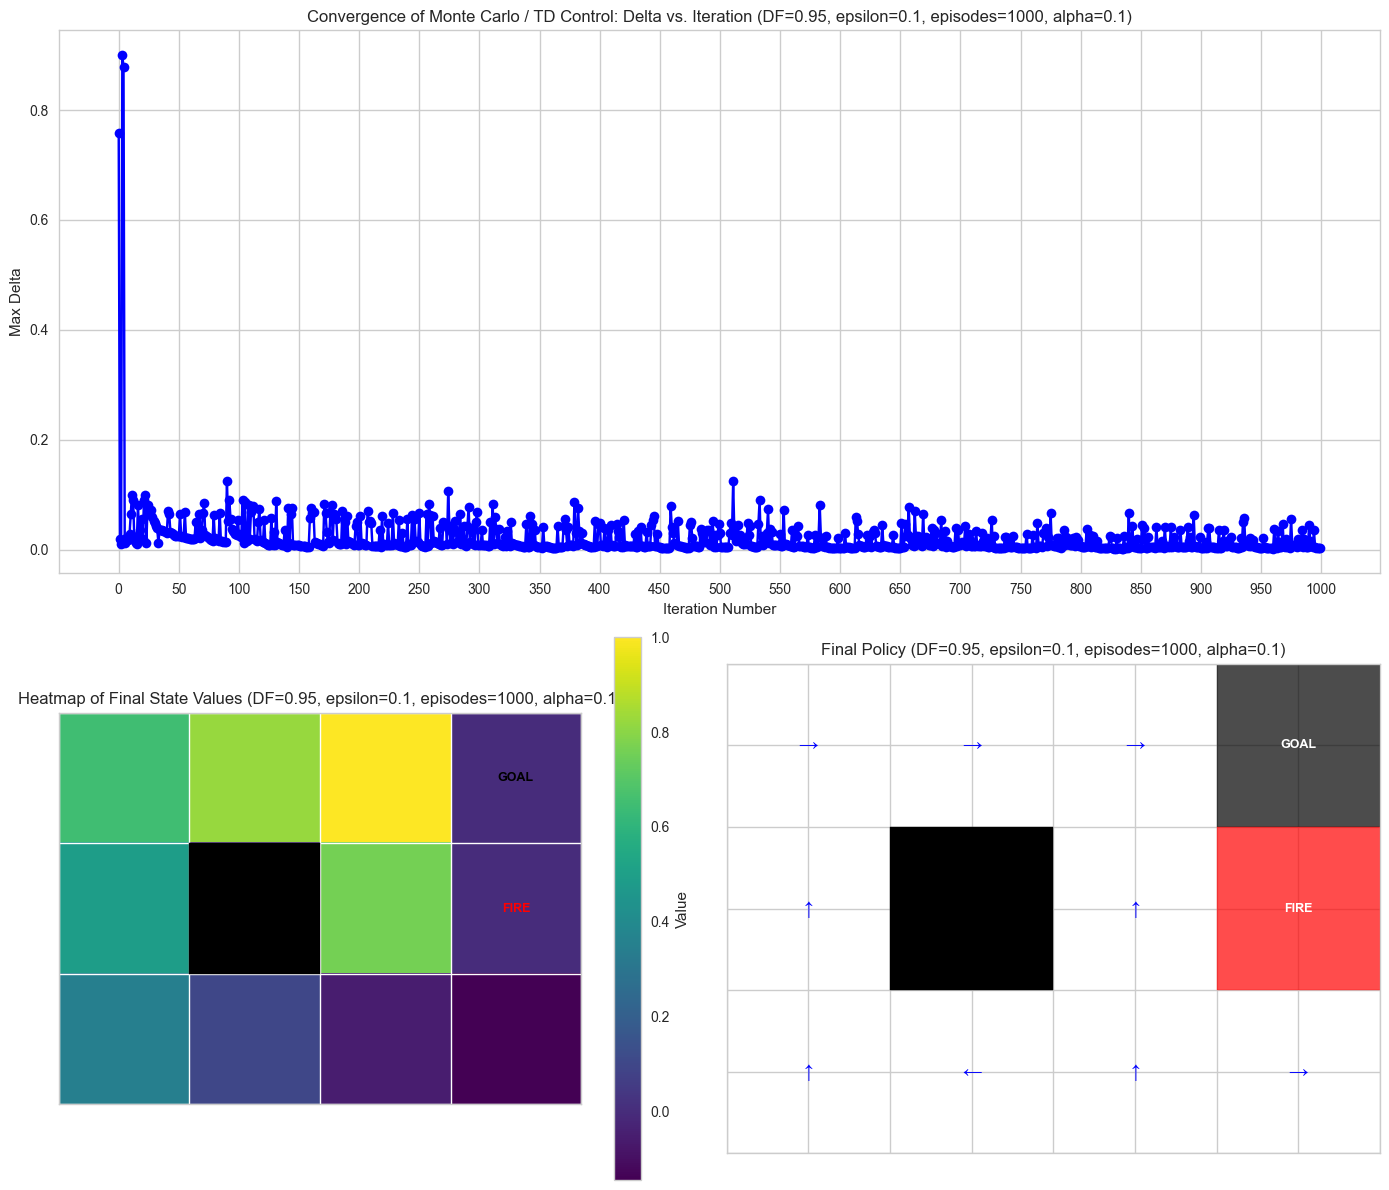

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.1
  Num_Episodes: 10000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



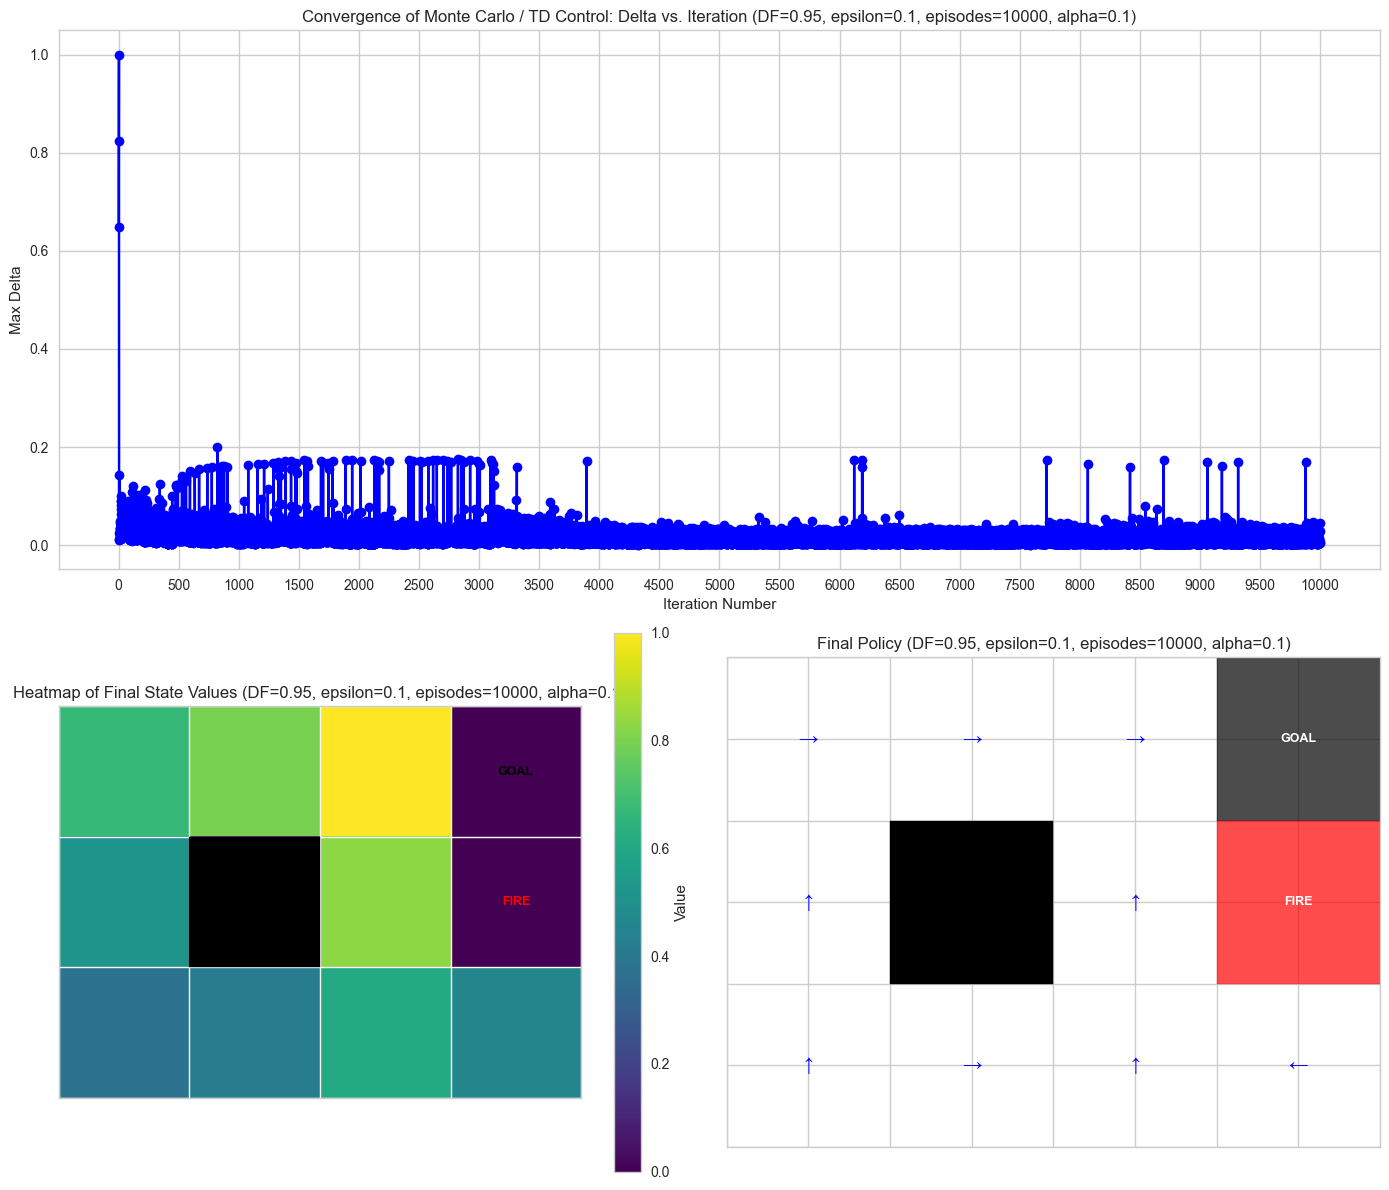

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.05
  Num_Episodes: 1000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



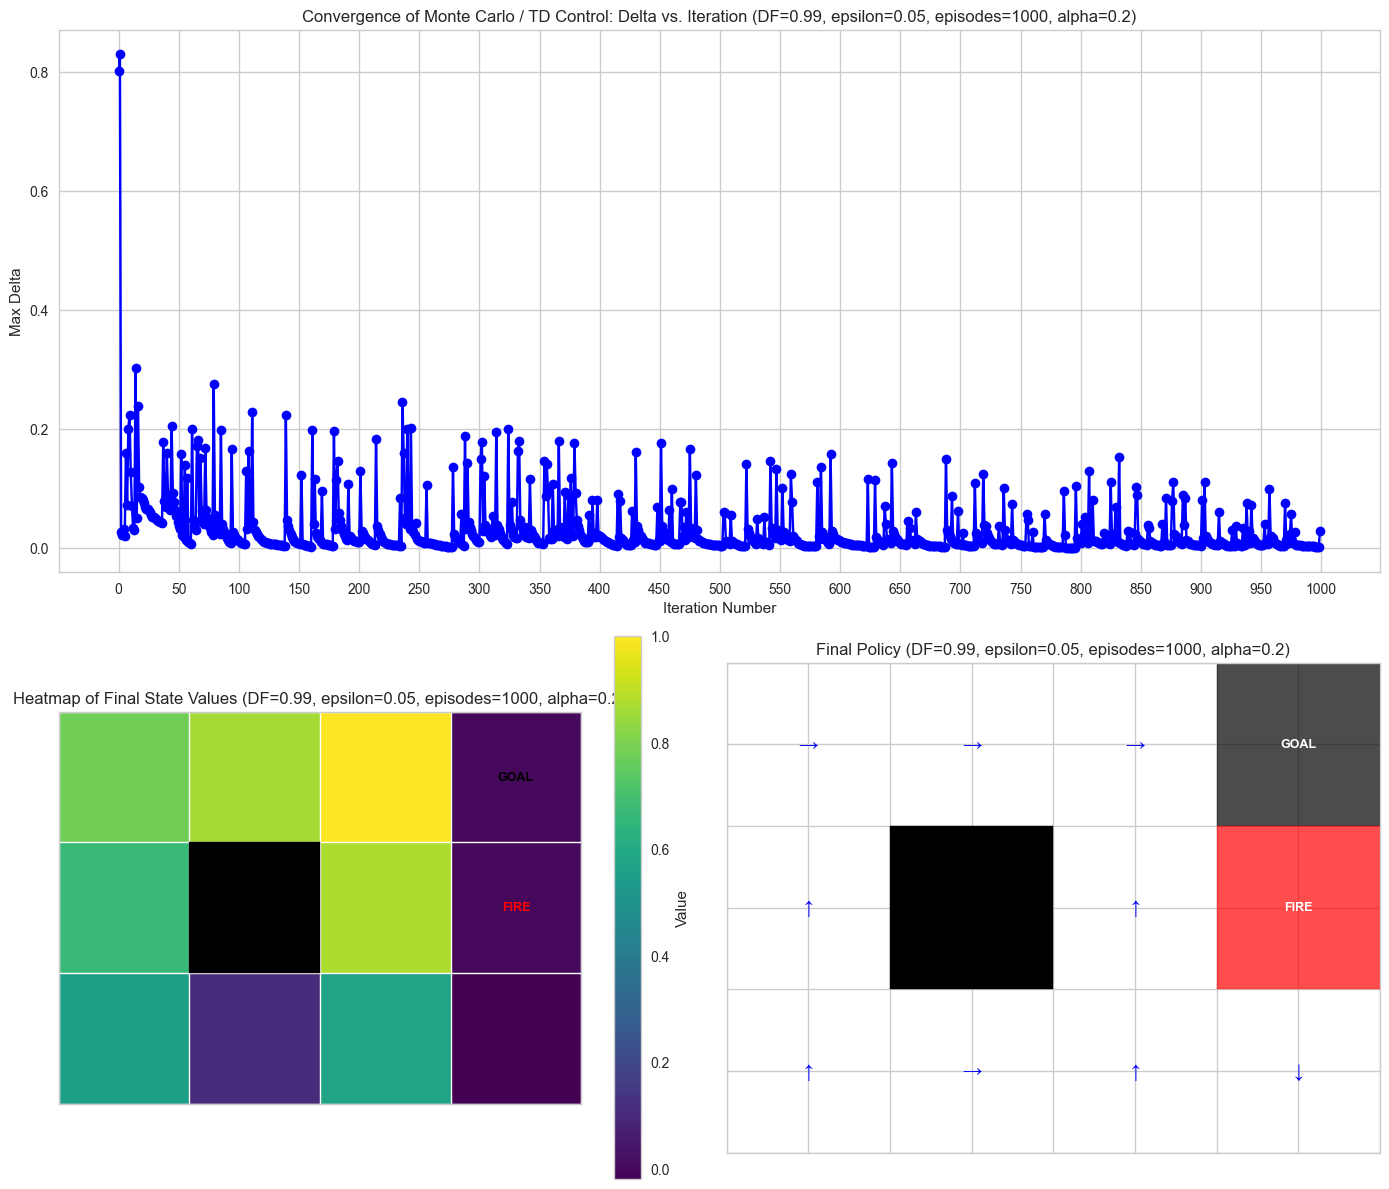

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.05
  Num_Episodes: 10000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



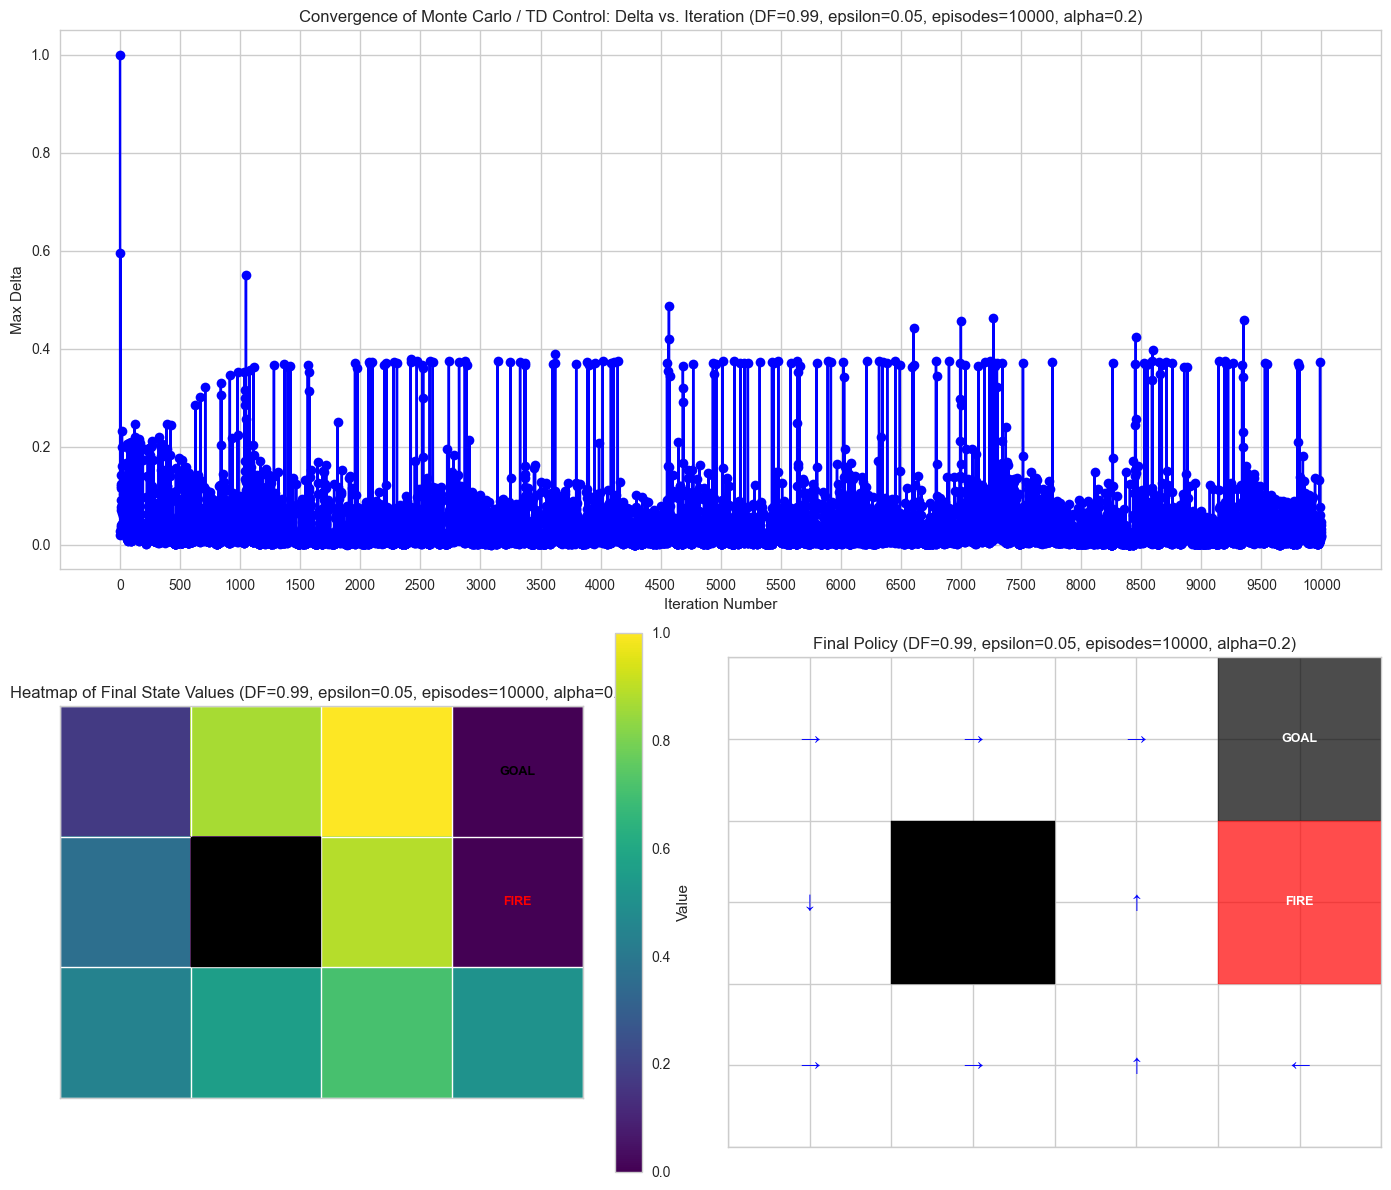

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.05
  Num_Episodes: 1000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



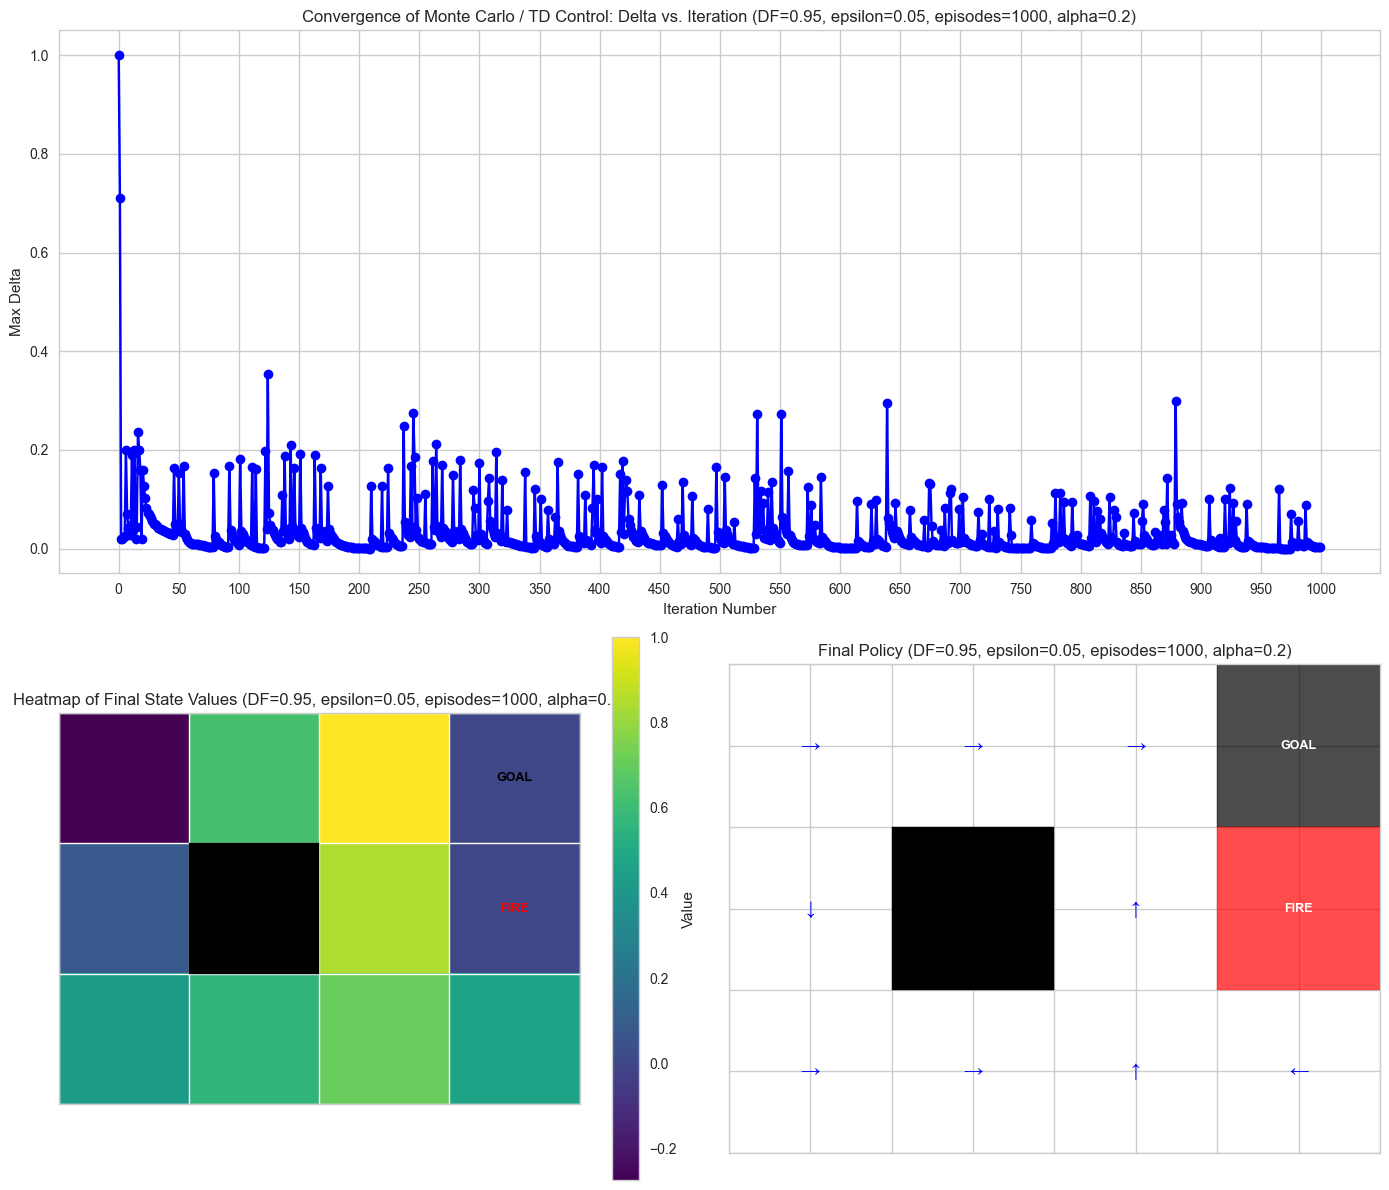

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.05
  Num_Episodes: 10000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



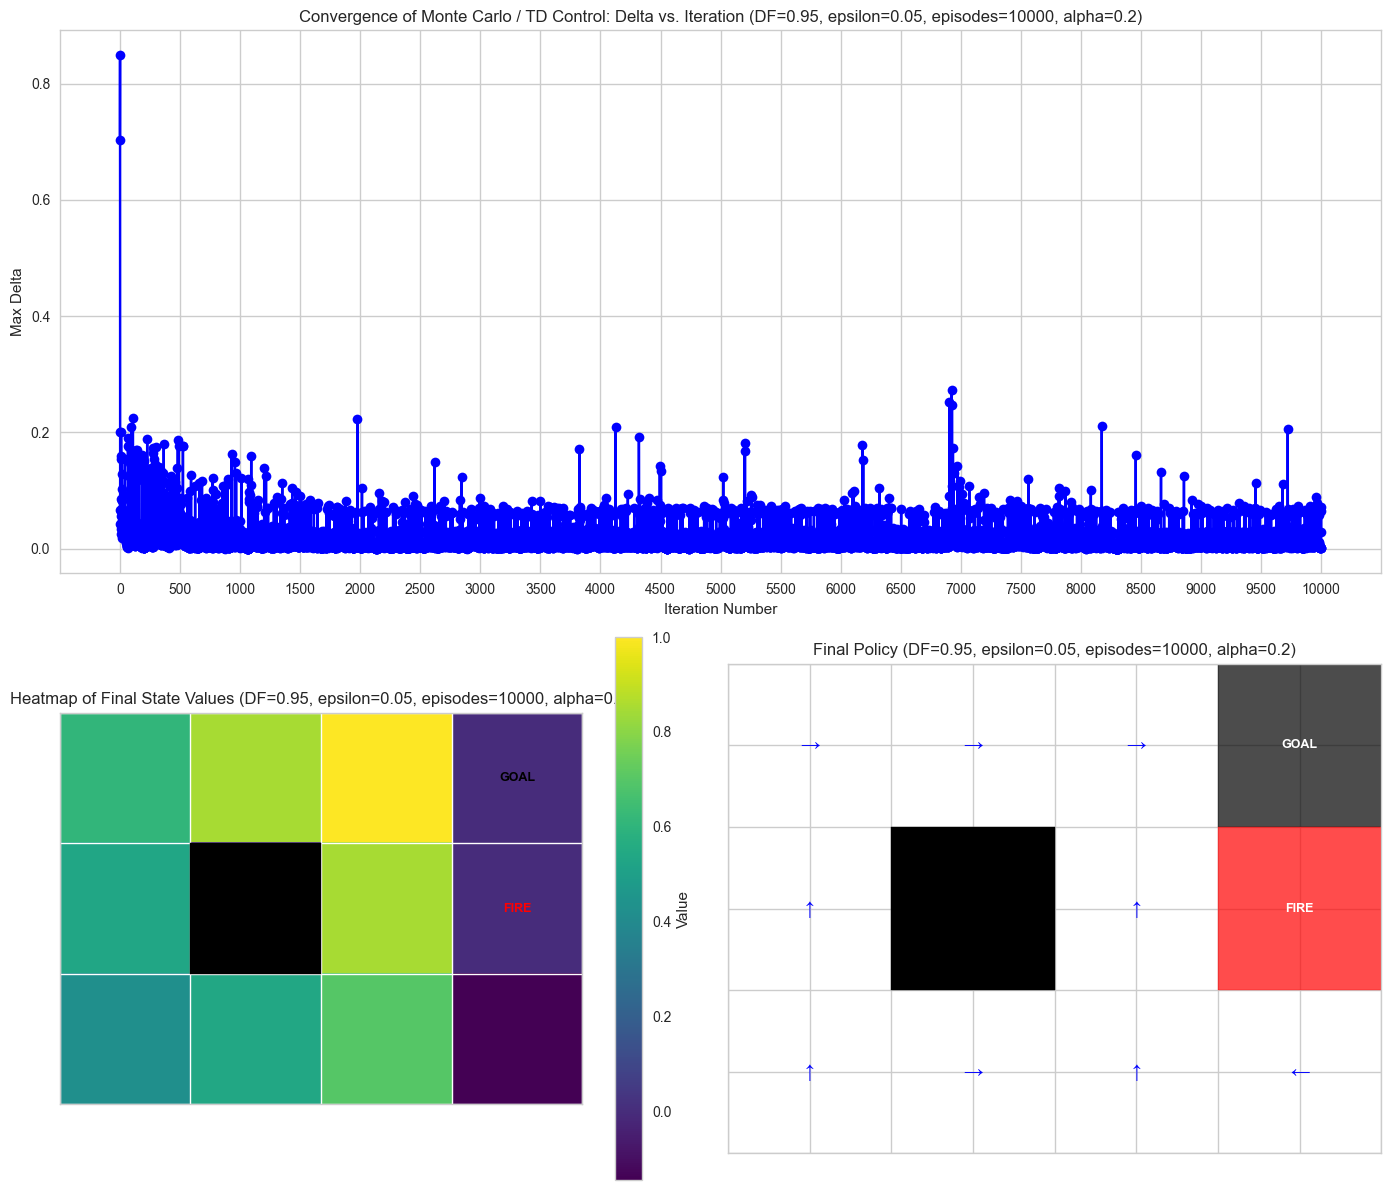

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.1
  Num_Episodes: 1000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



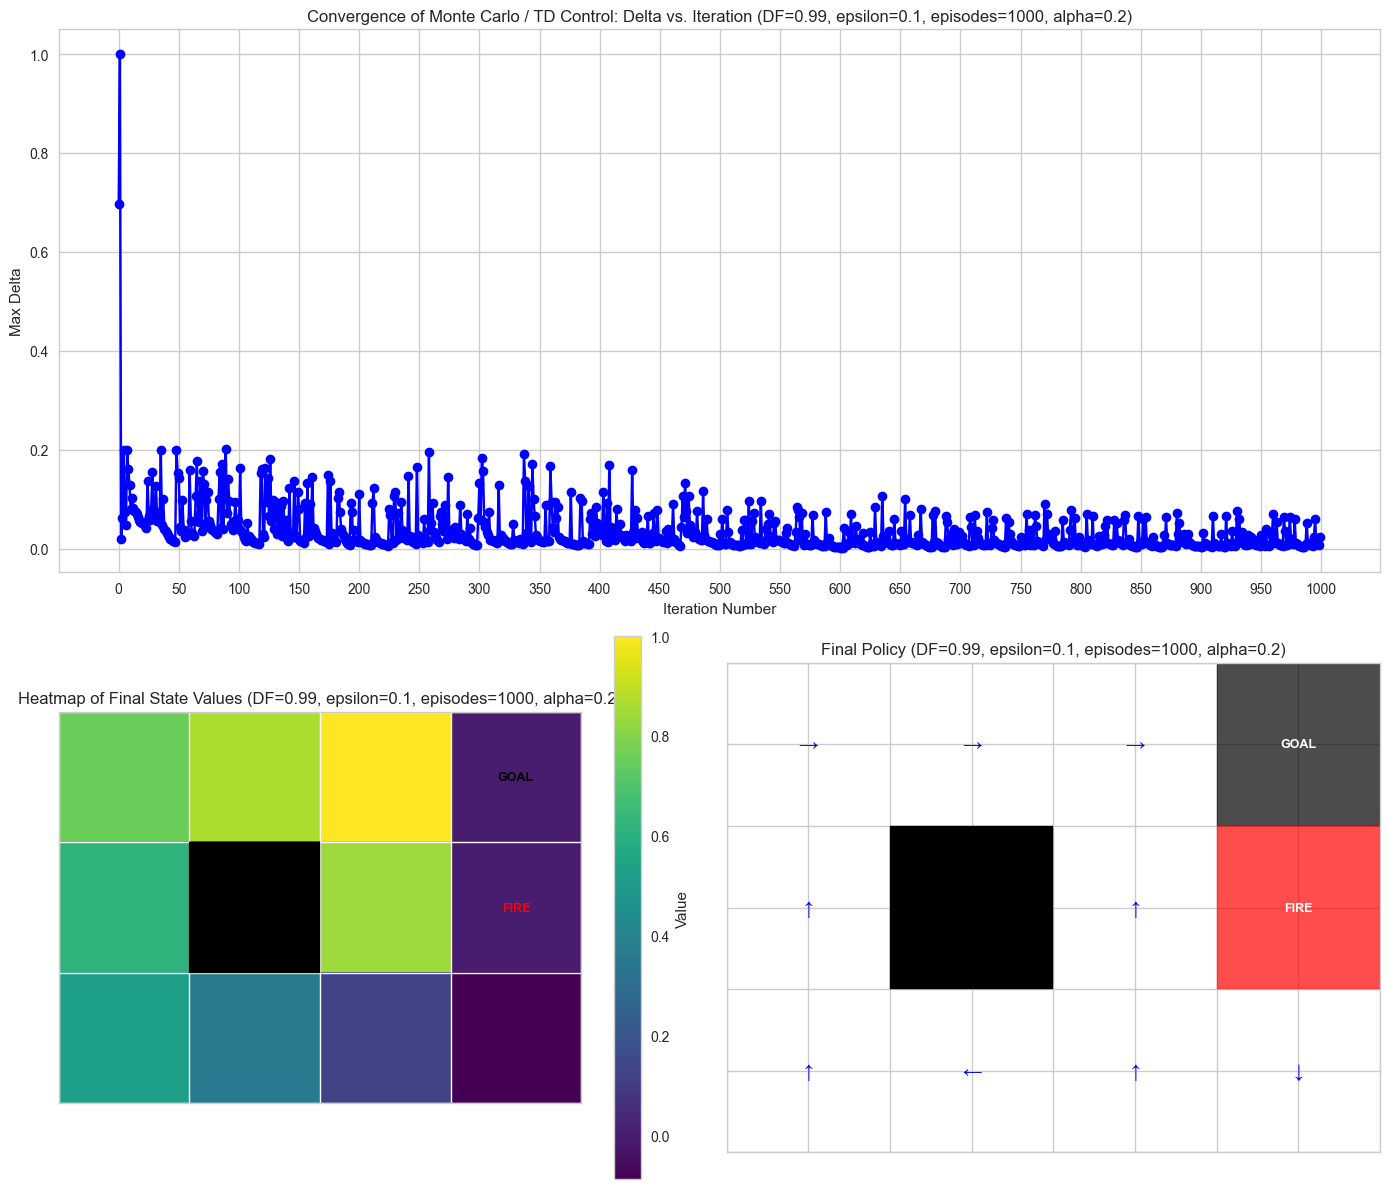

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.1
  Num_Episodes: 10000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



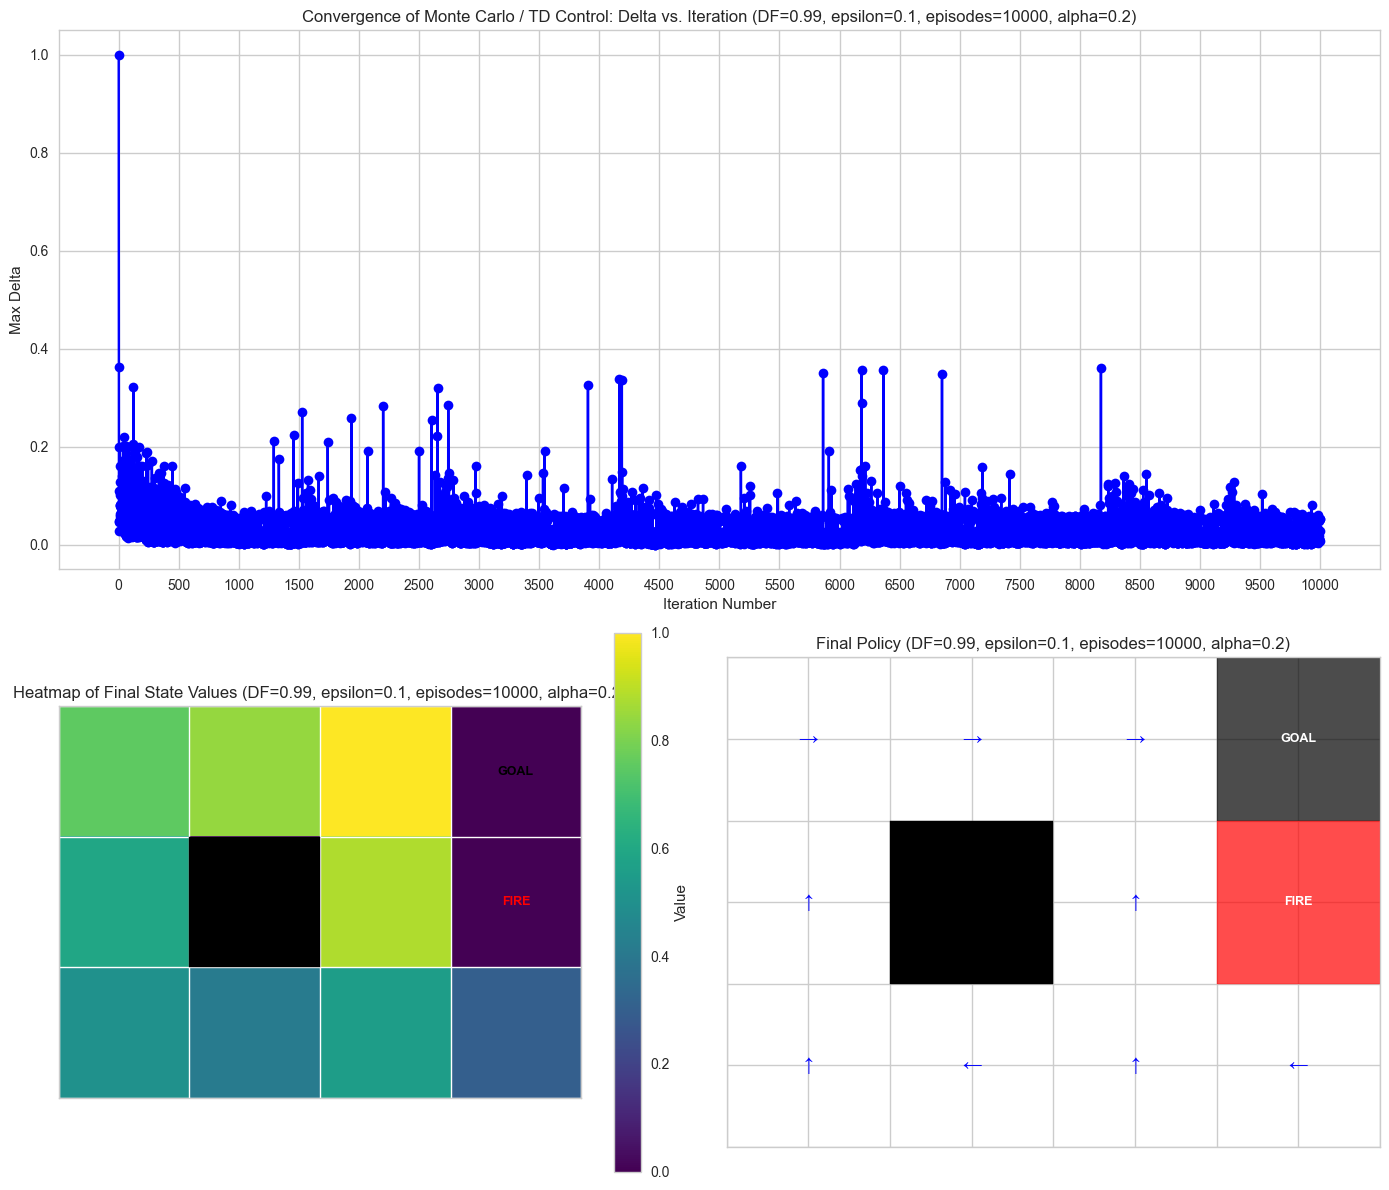

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.1
  Num_Episodes: 1000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



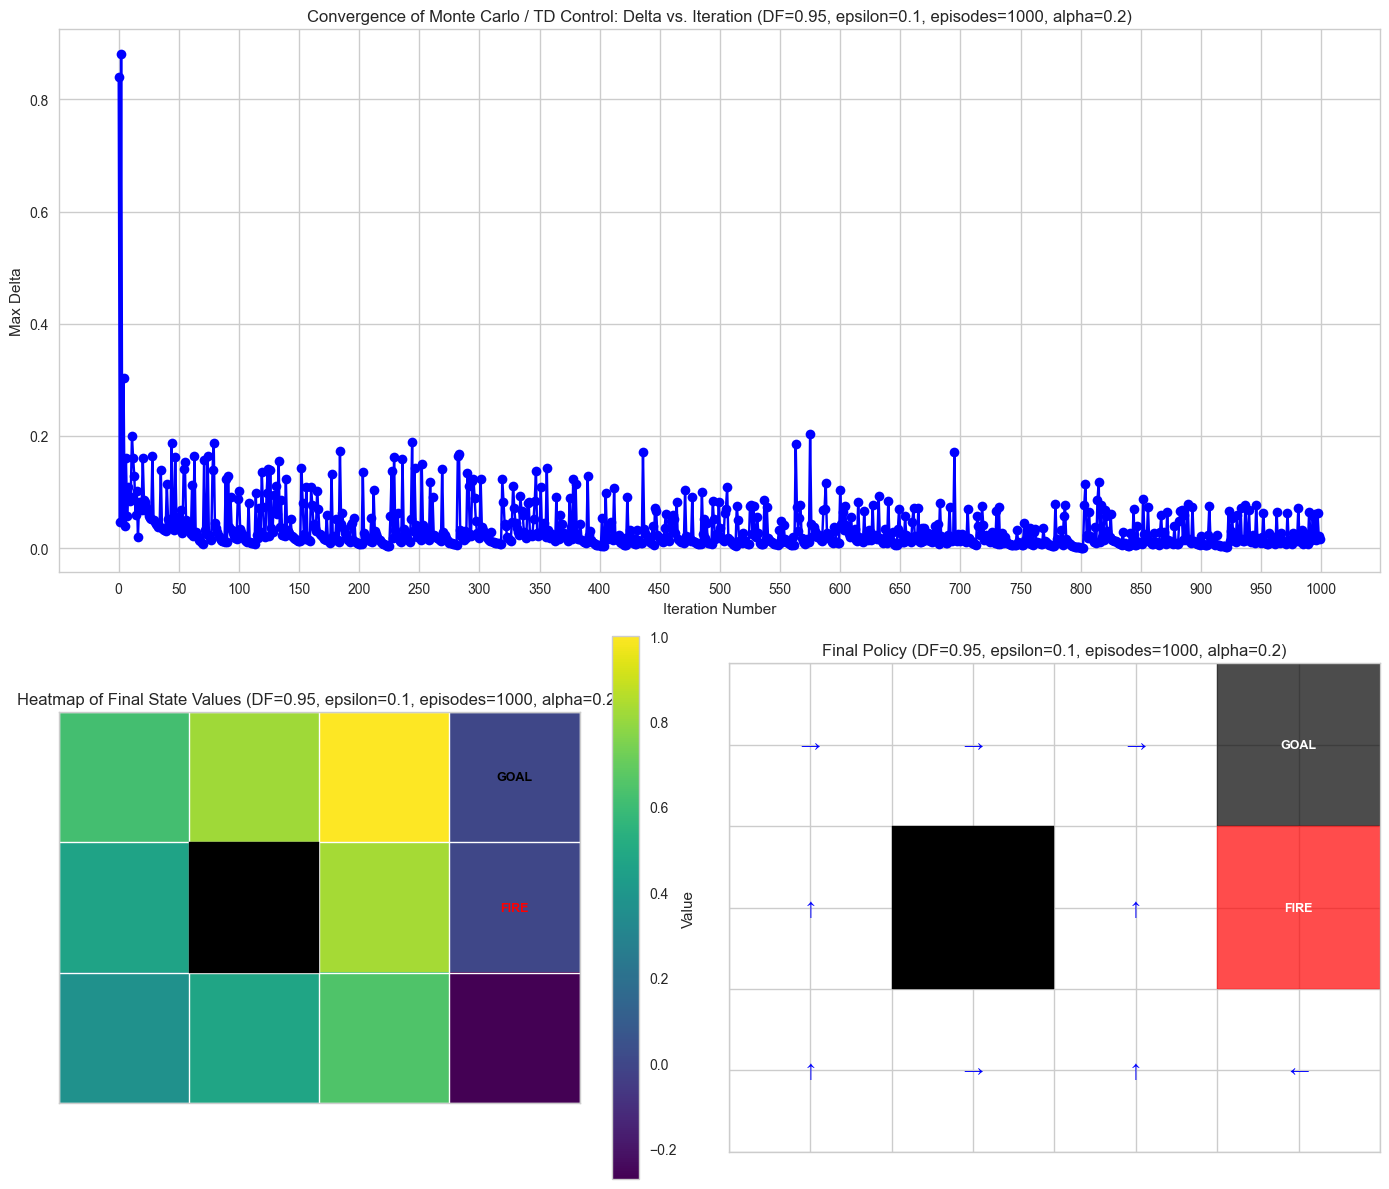

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.1
  Num_Episodes: 10000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



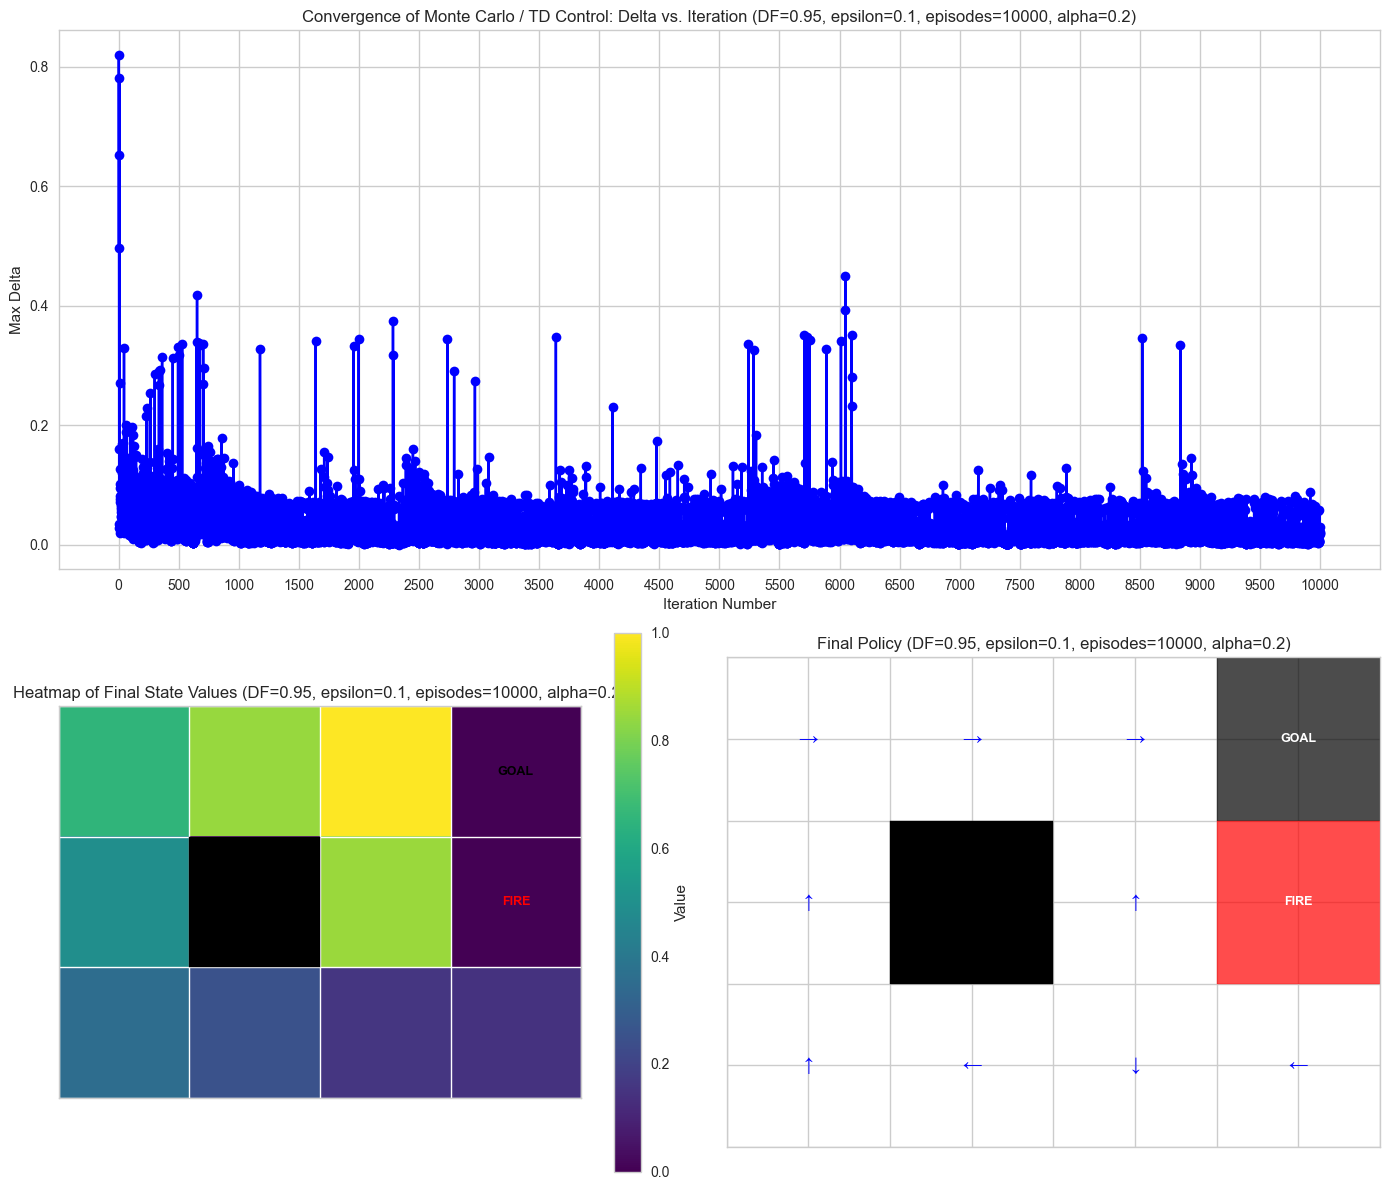

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.05
  Num_Episodes: 1000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



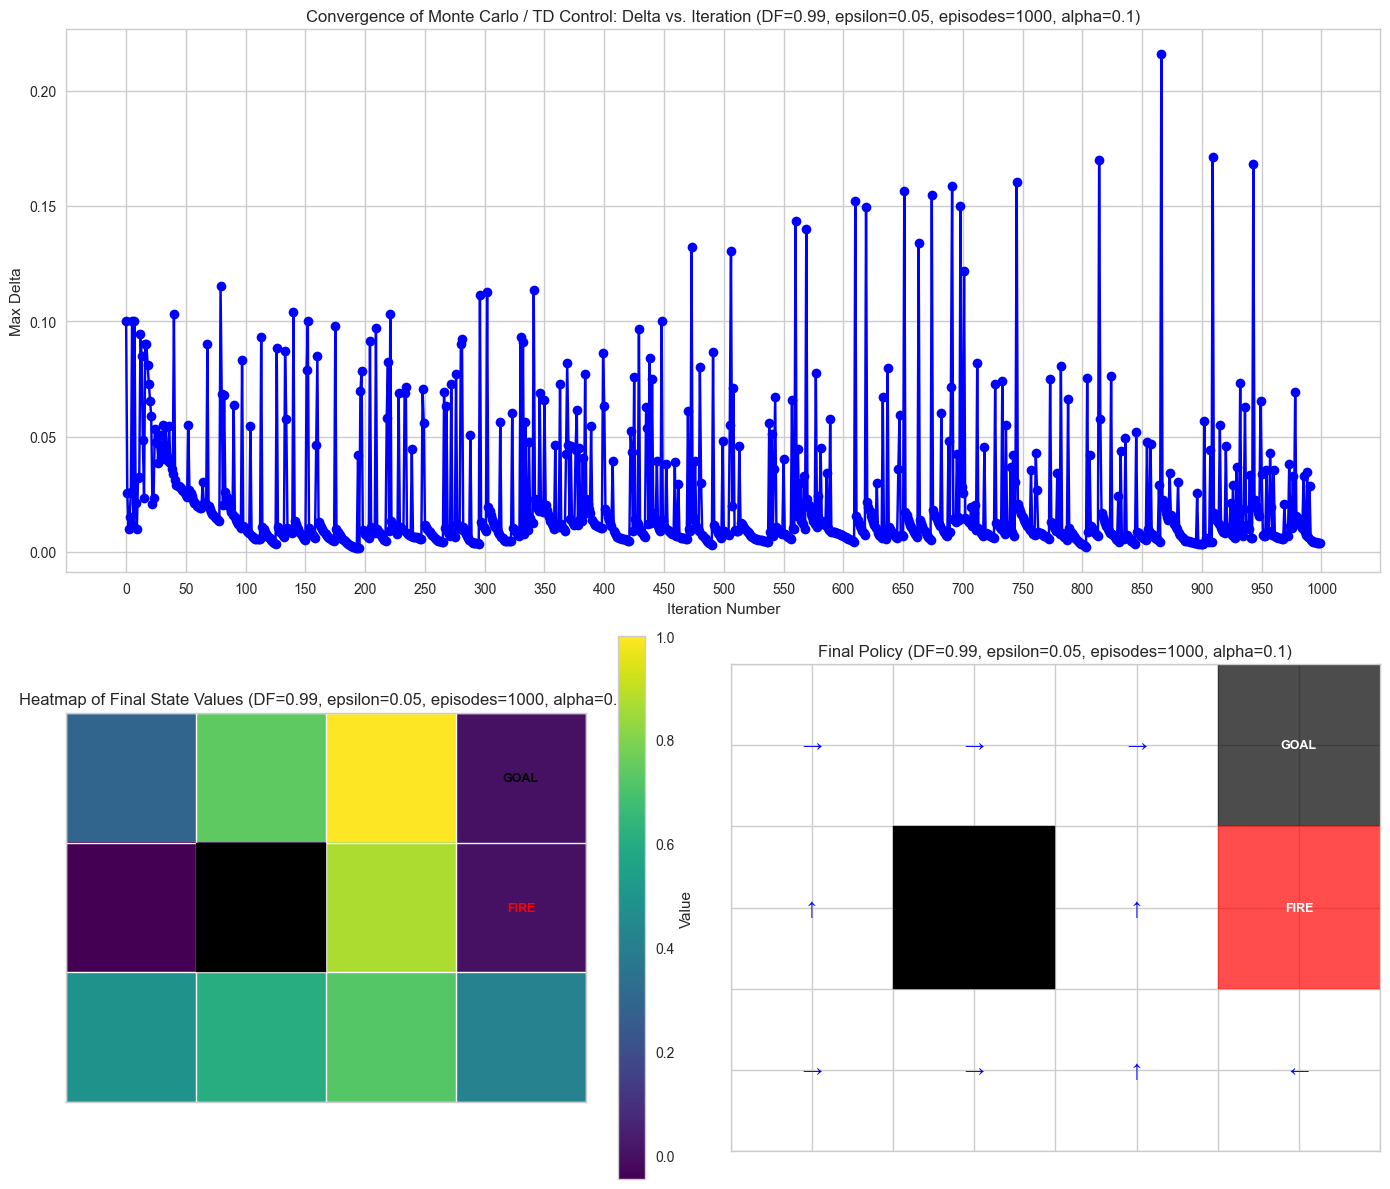

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.05
  Num_Episodes: 10000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



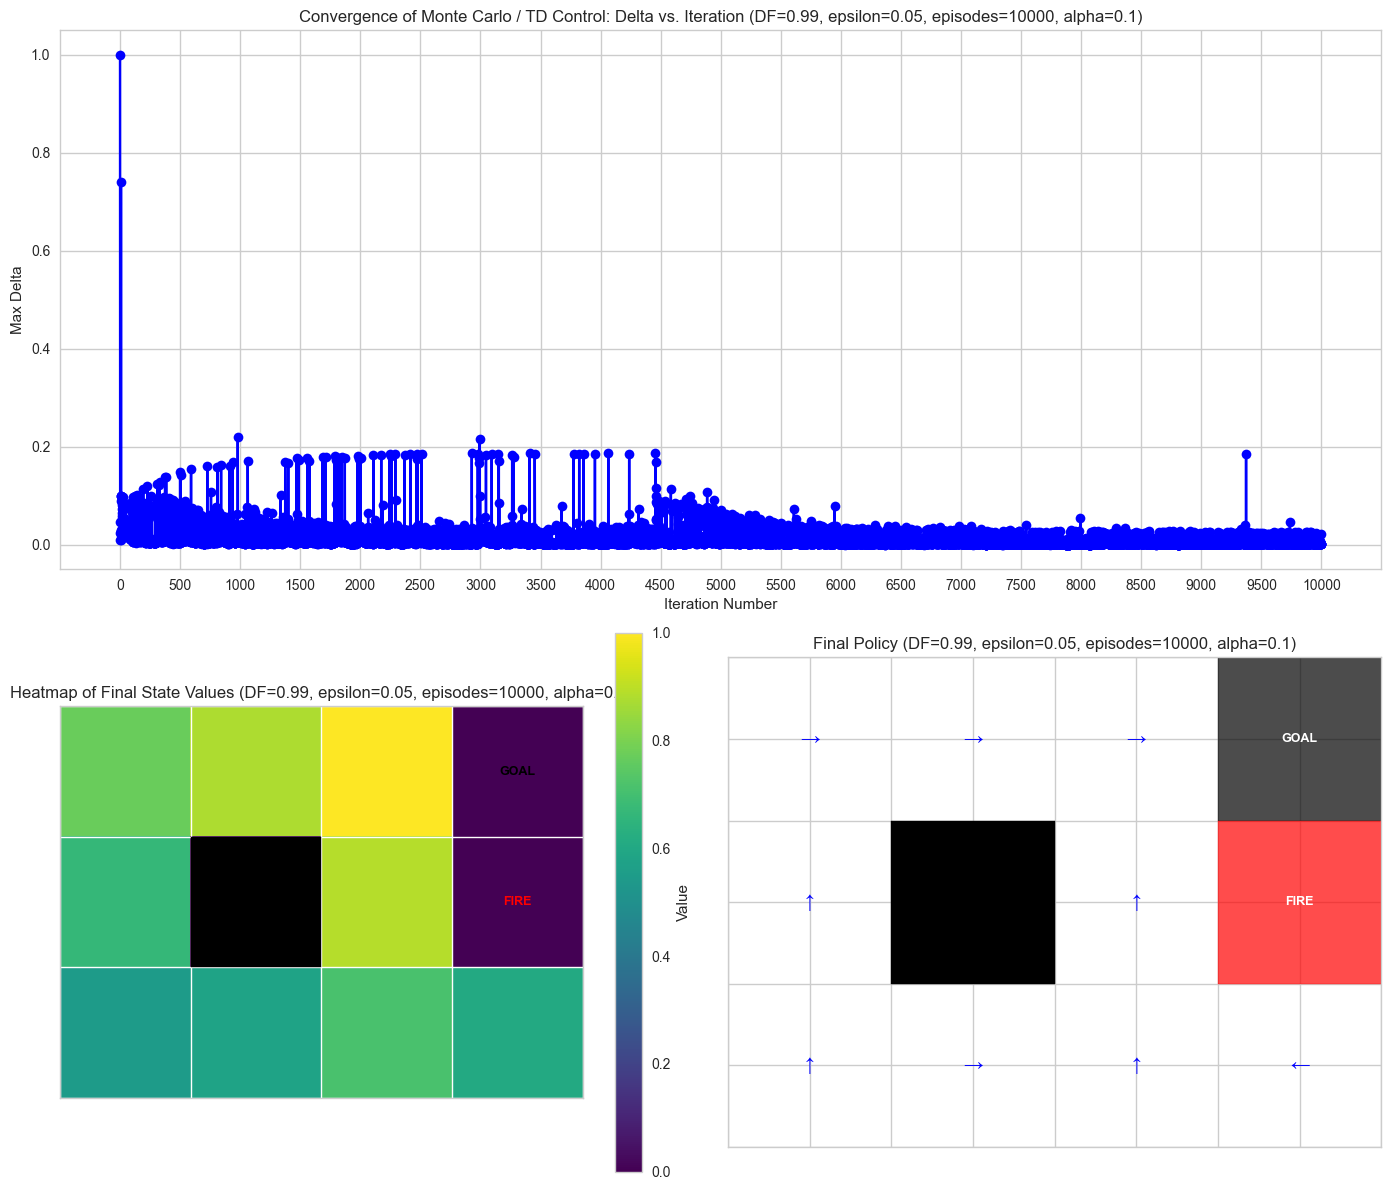

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.05
  Num_Episodes: 1000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



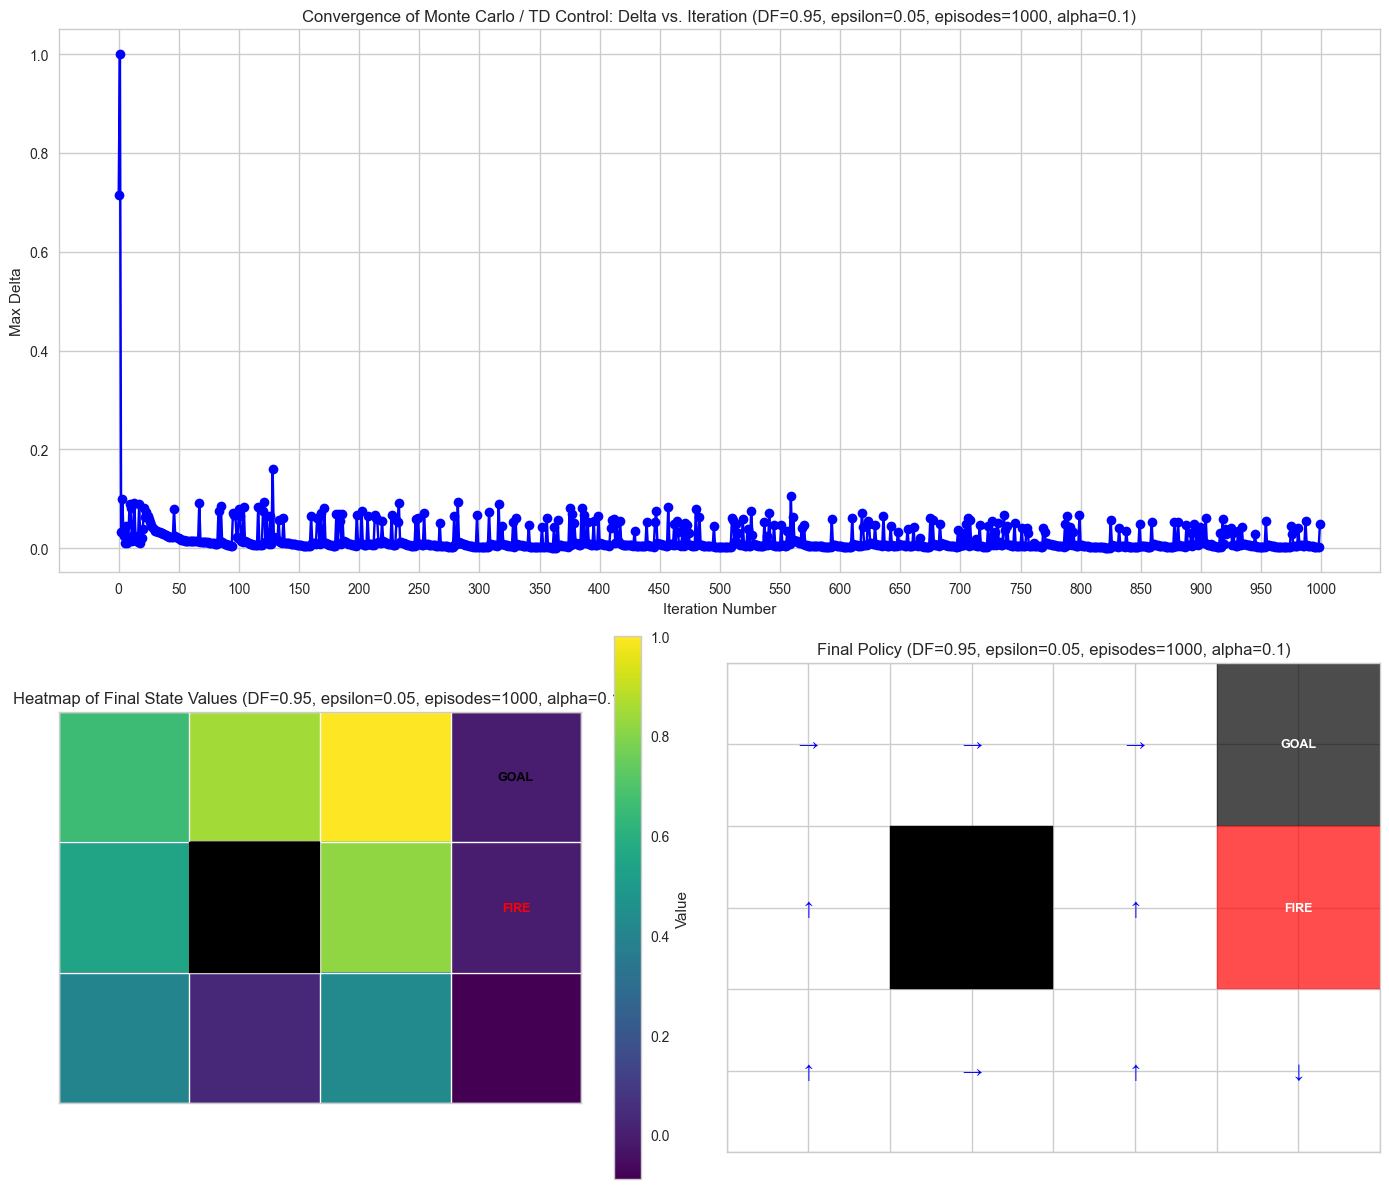

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.05
  Num_Episodes: 10000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



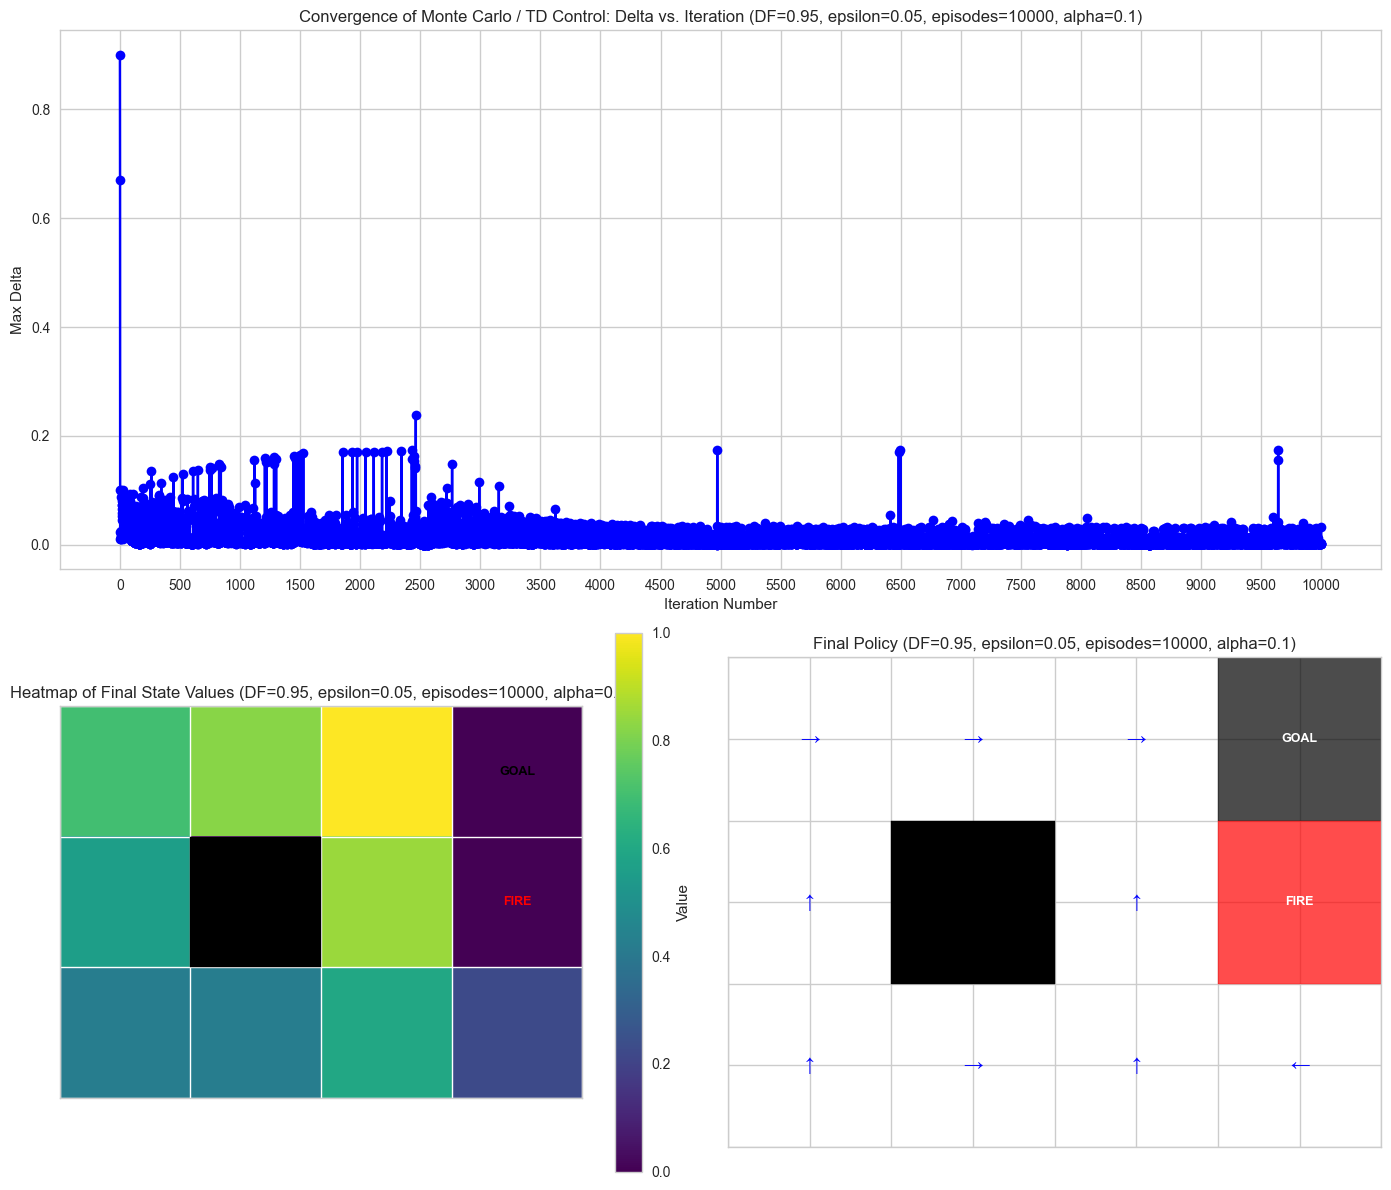

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.1
  Num_Episodes: 1000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



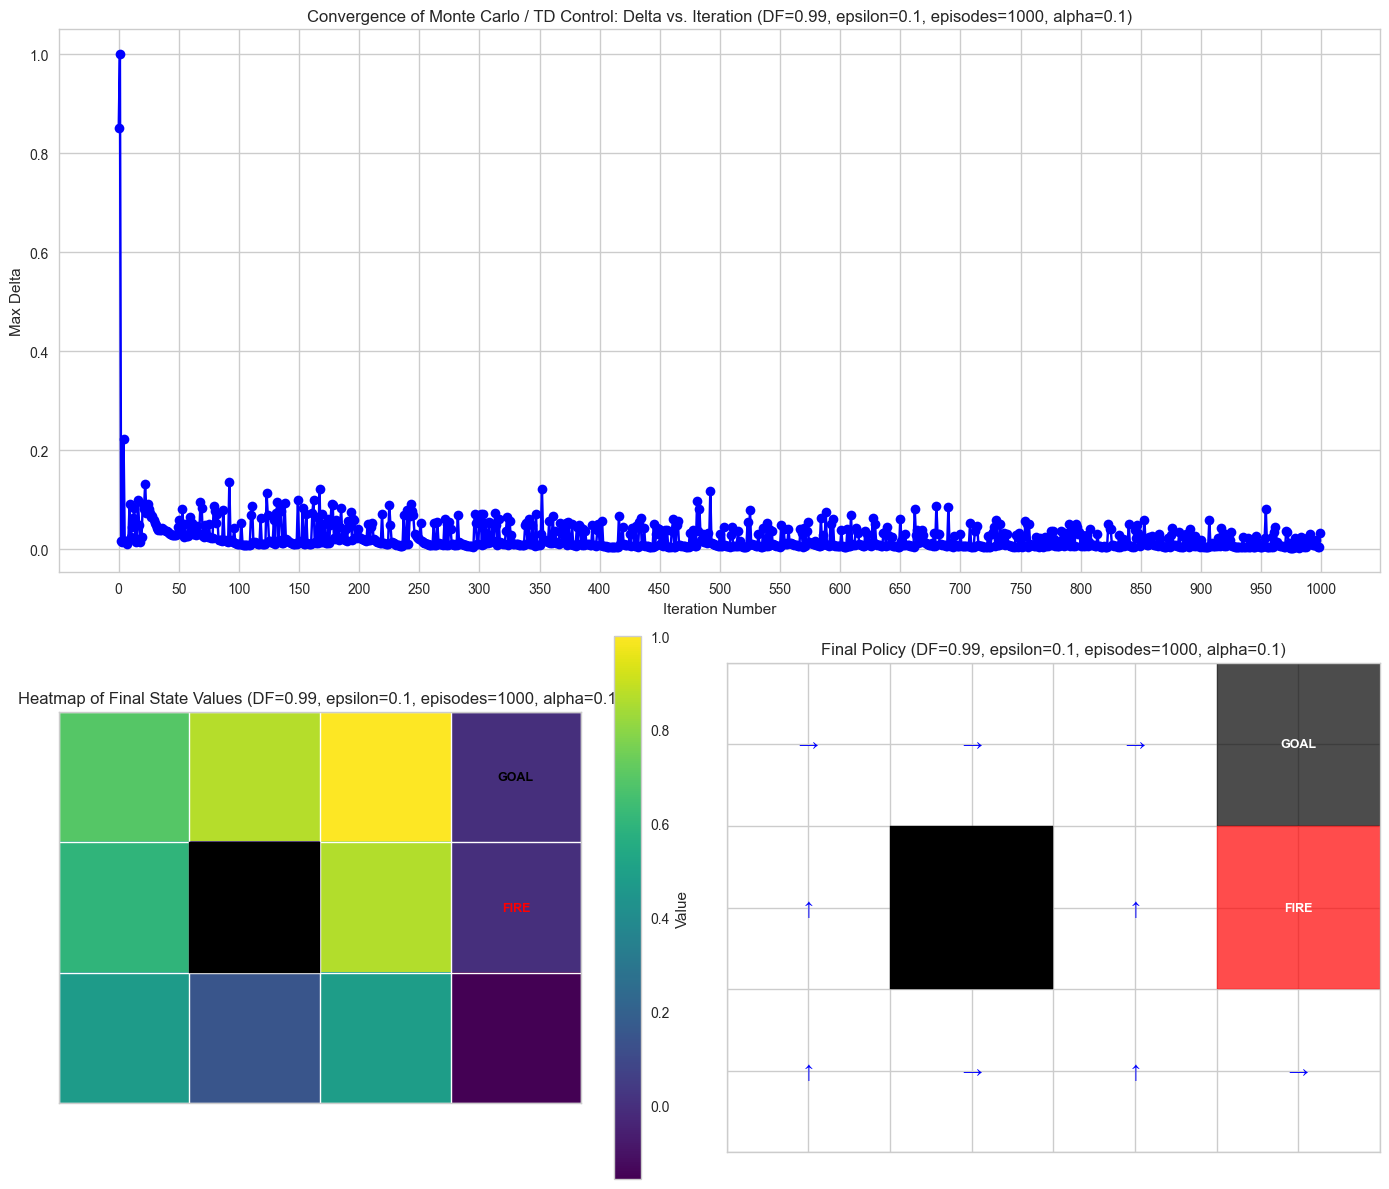

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.1
  Num_Episodes: 10000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



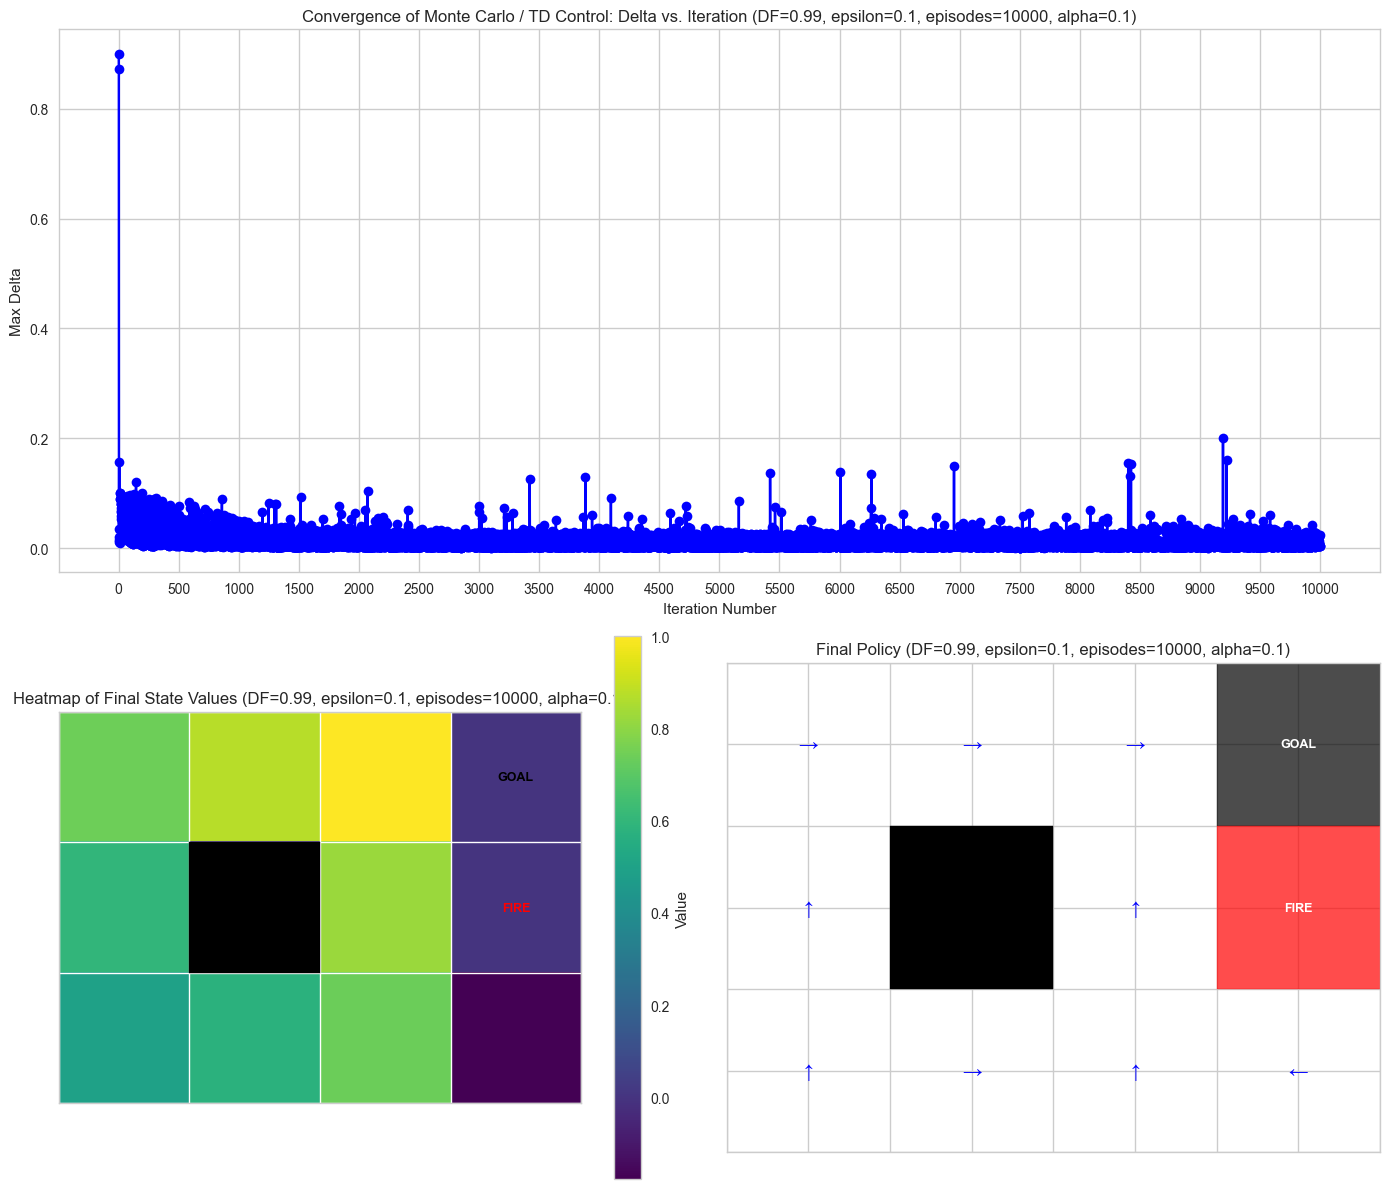

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.1
  Num_Episodes: 1000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



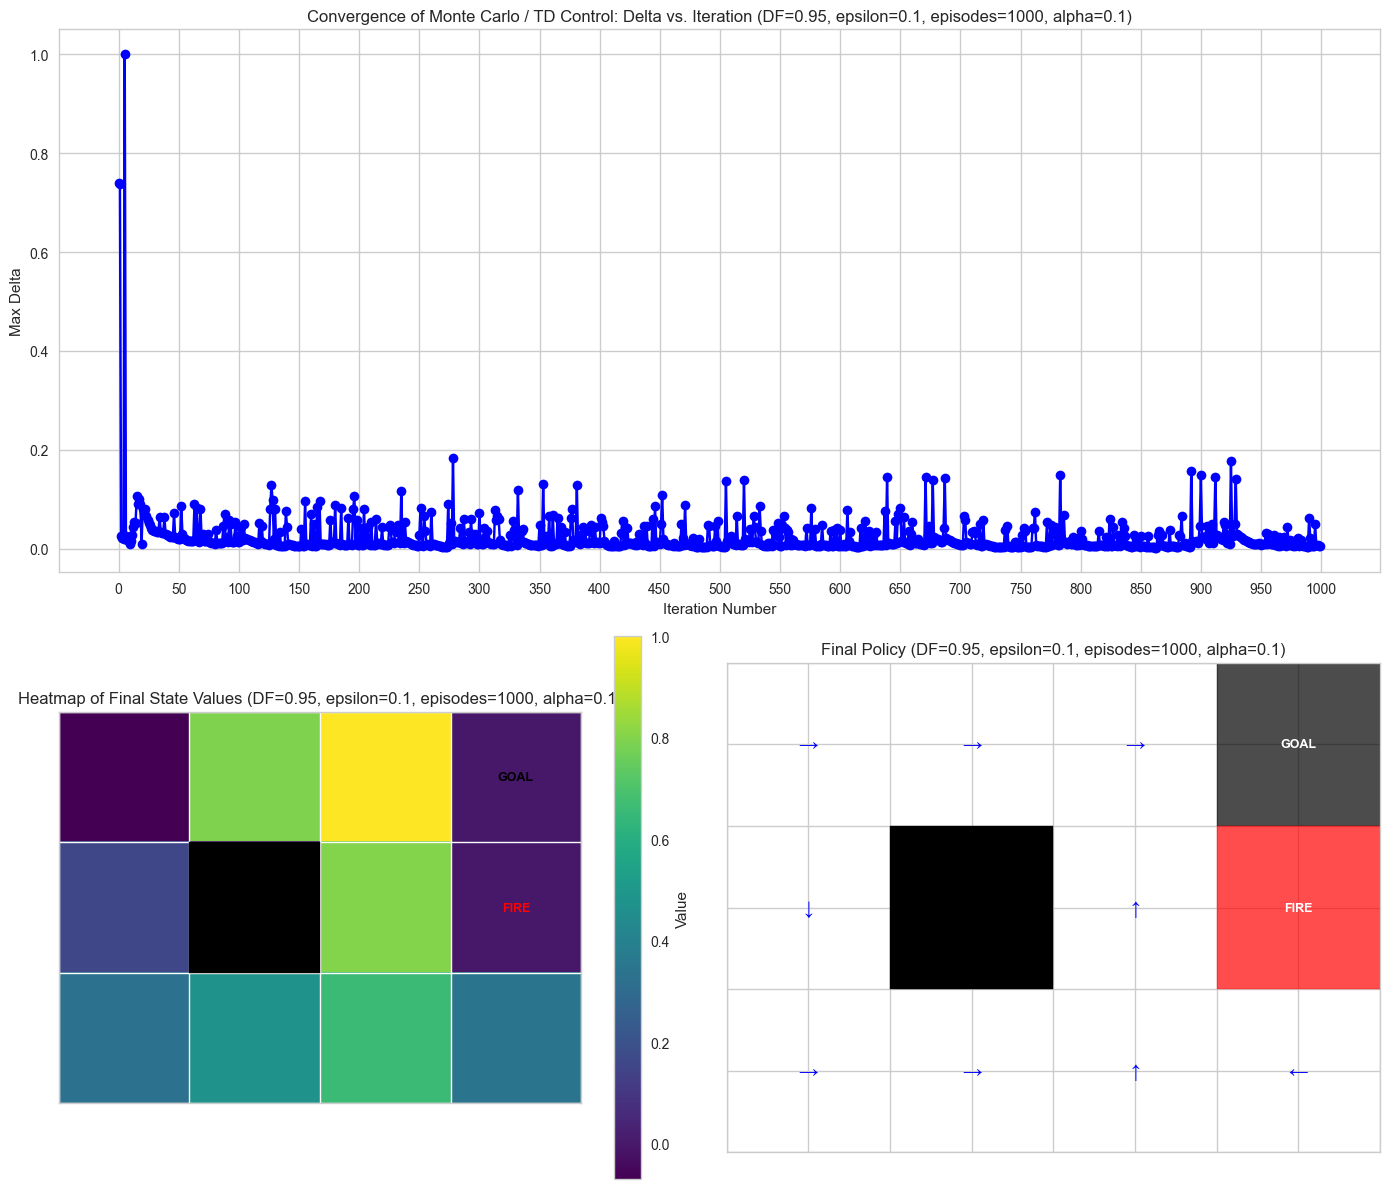

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.1
  Num_Episodes: 10000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



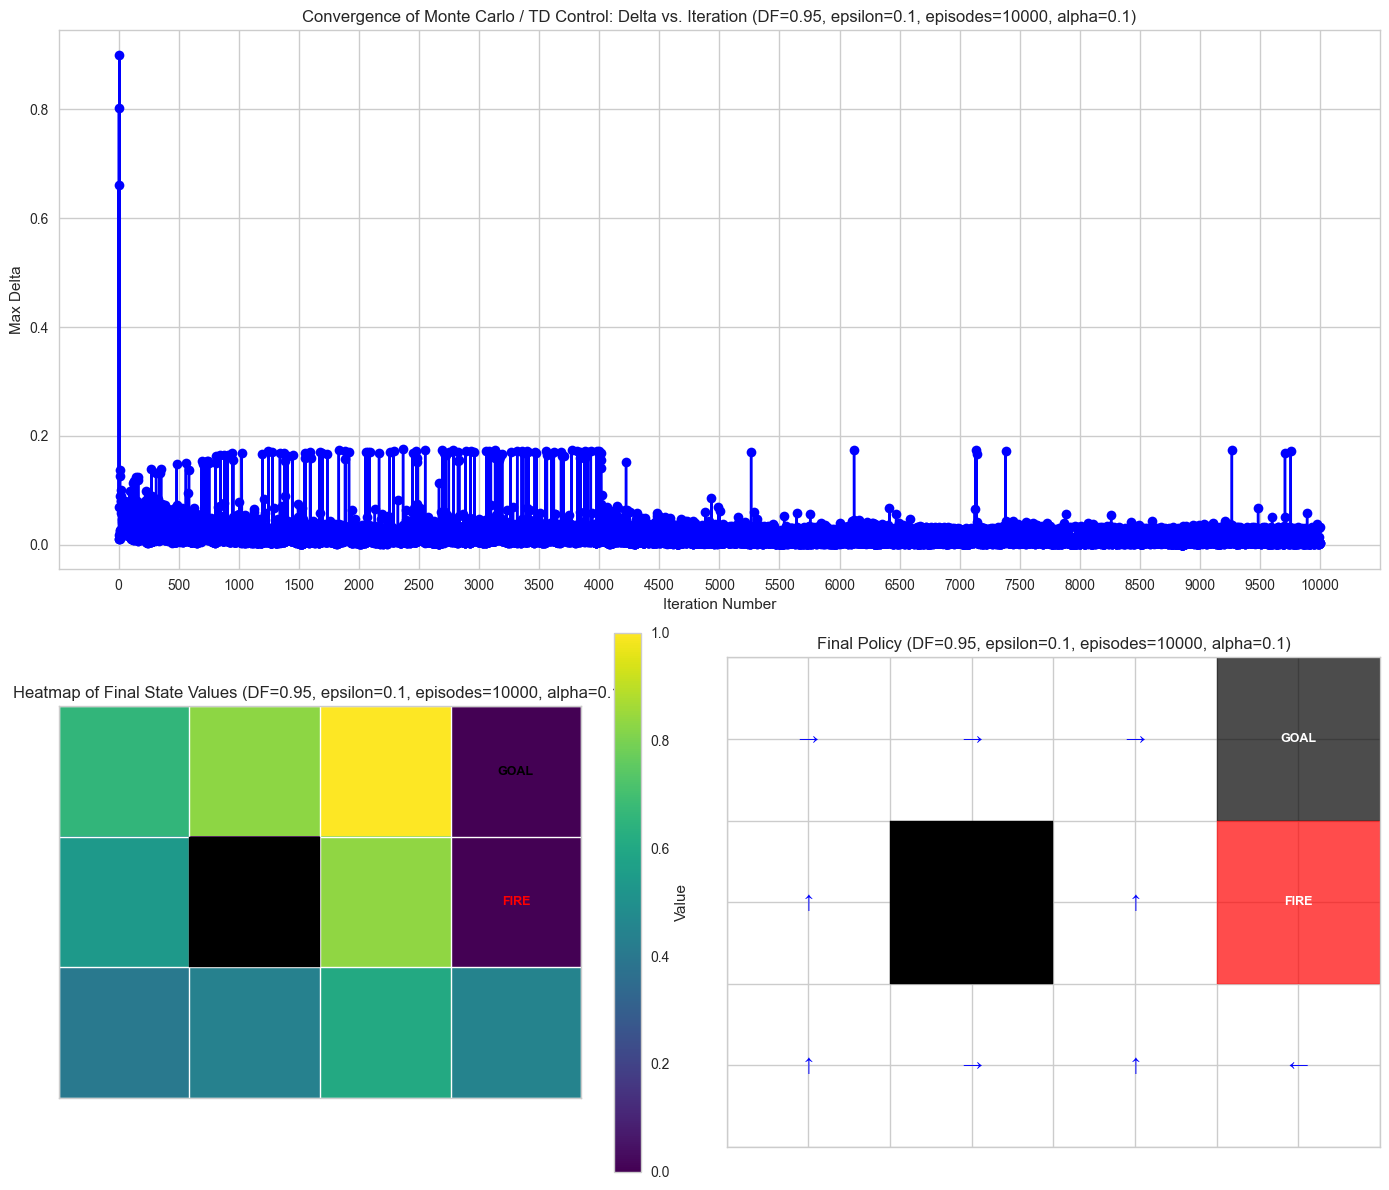

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.2
  Num_Episodes: 1000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



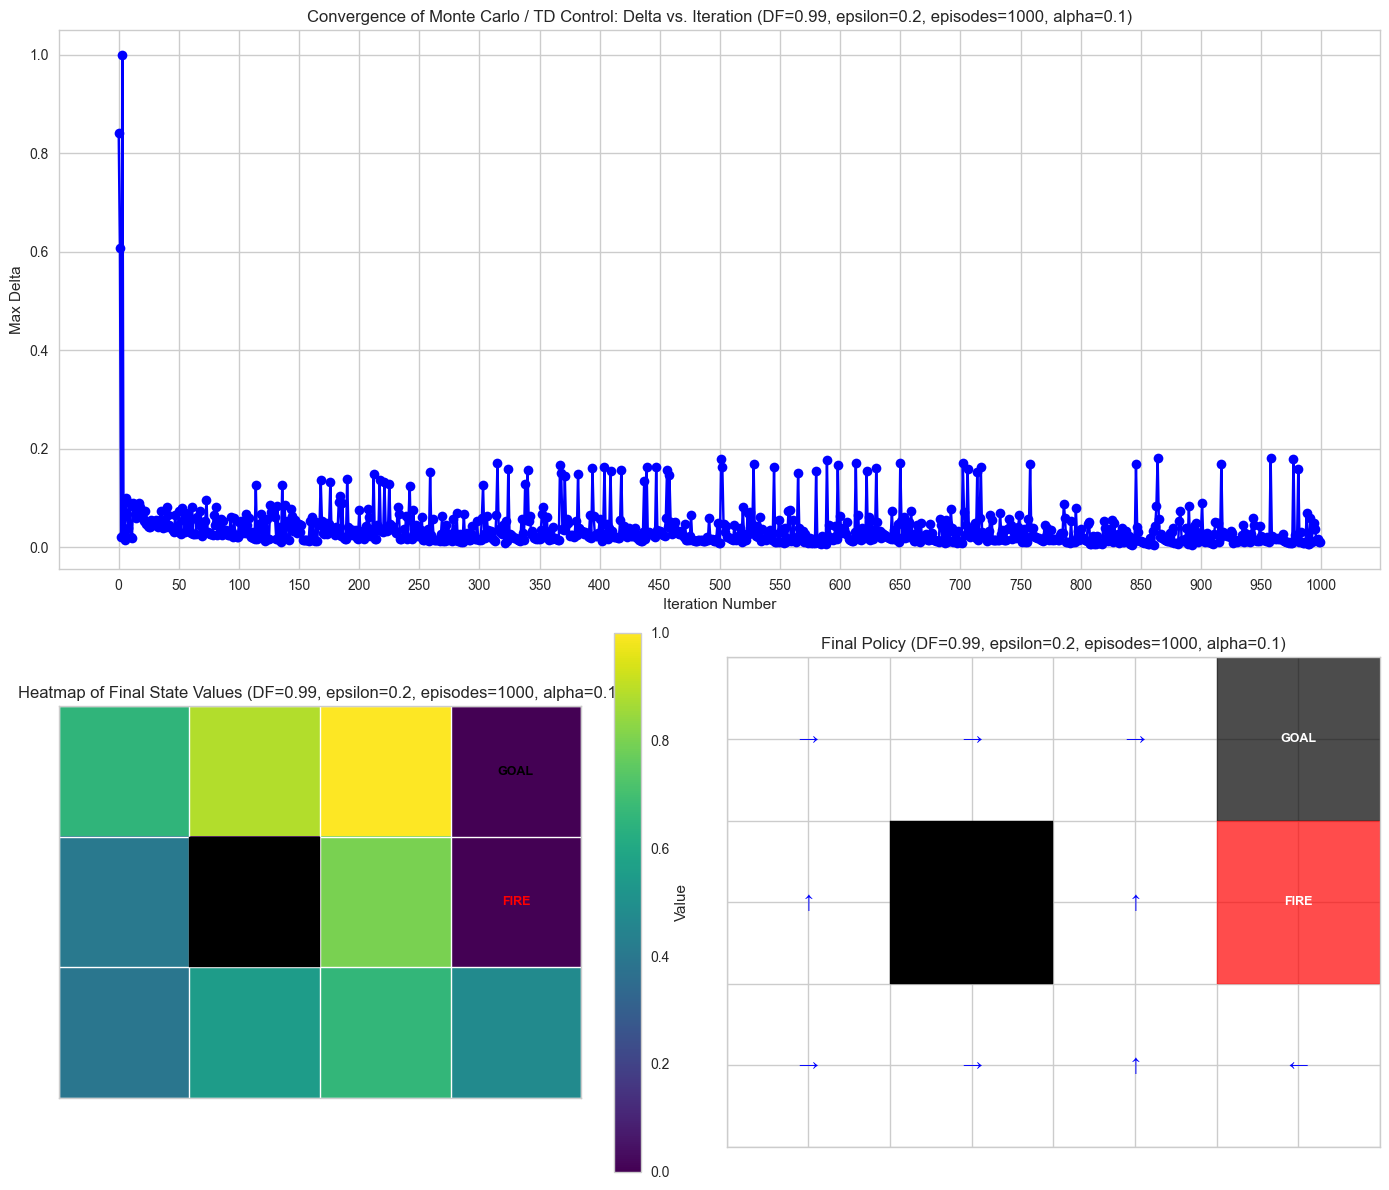

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.2
  Num_Episodes: 10000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



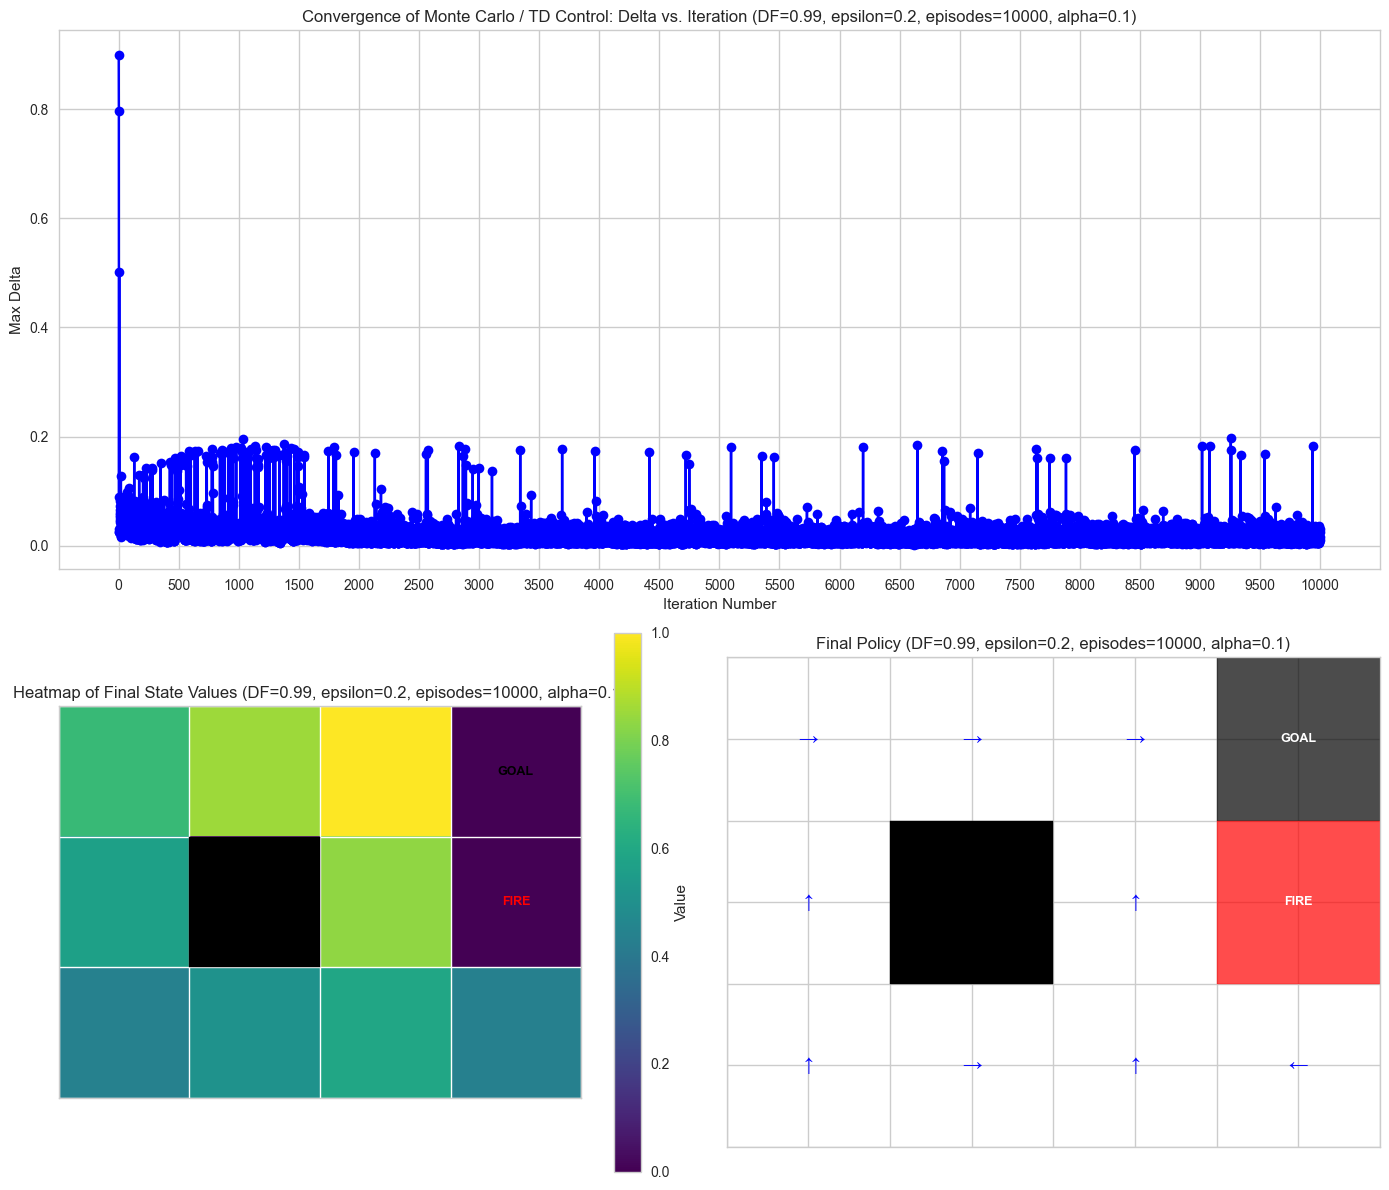

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.2
  Num_Episodes: 1000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



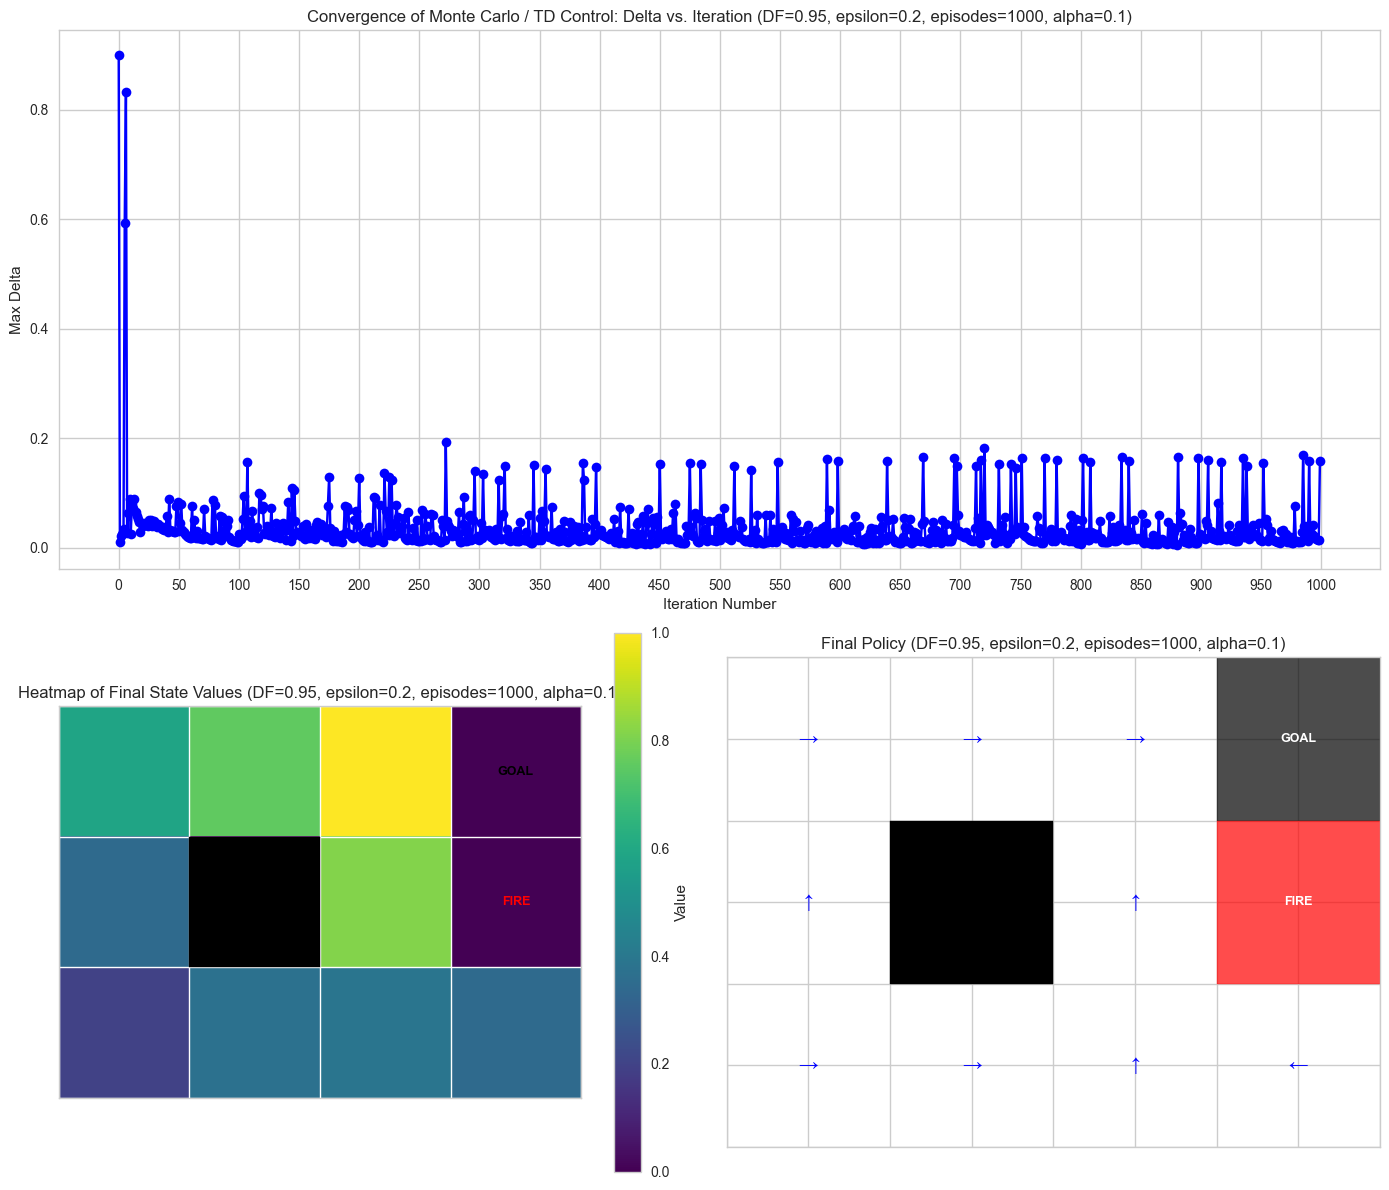

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.2
  Num_Episodes: 10000
  Alpha: 0.1
Displaying convergence curve, heatmap of final values, and final policy...



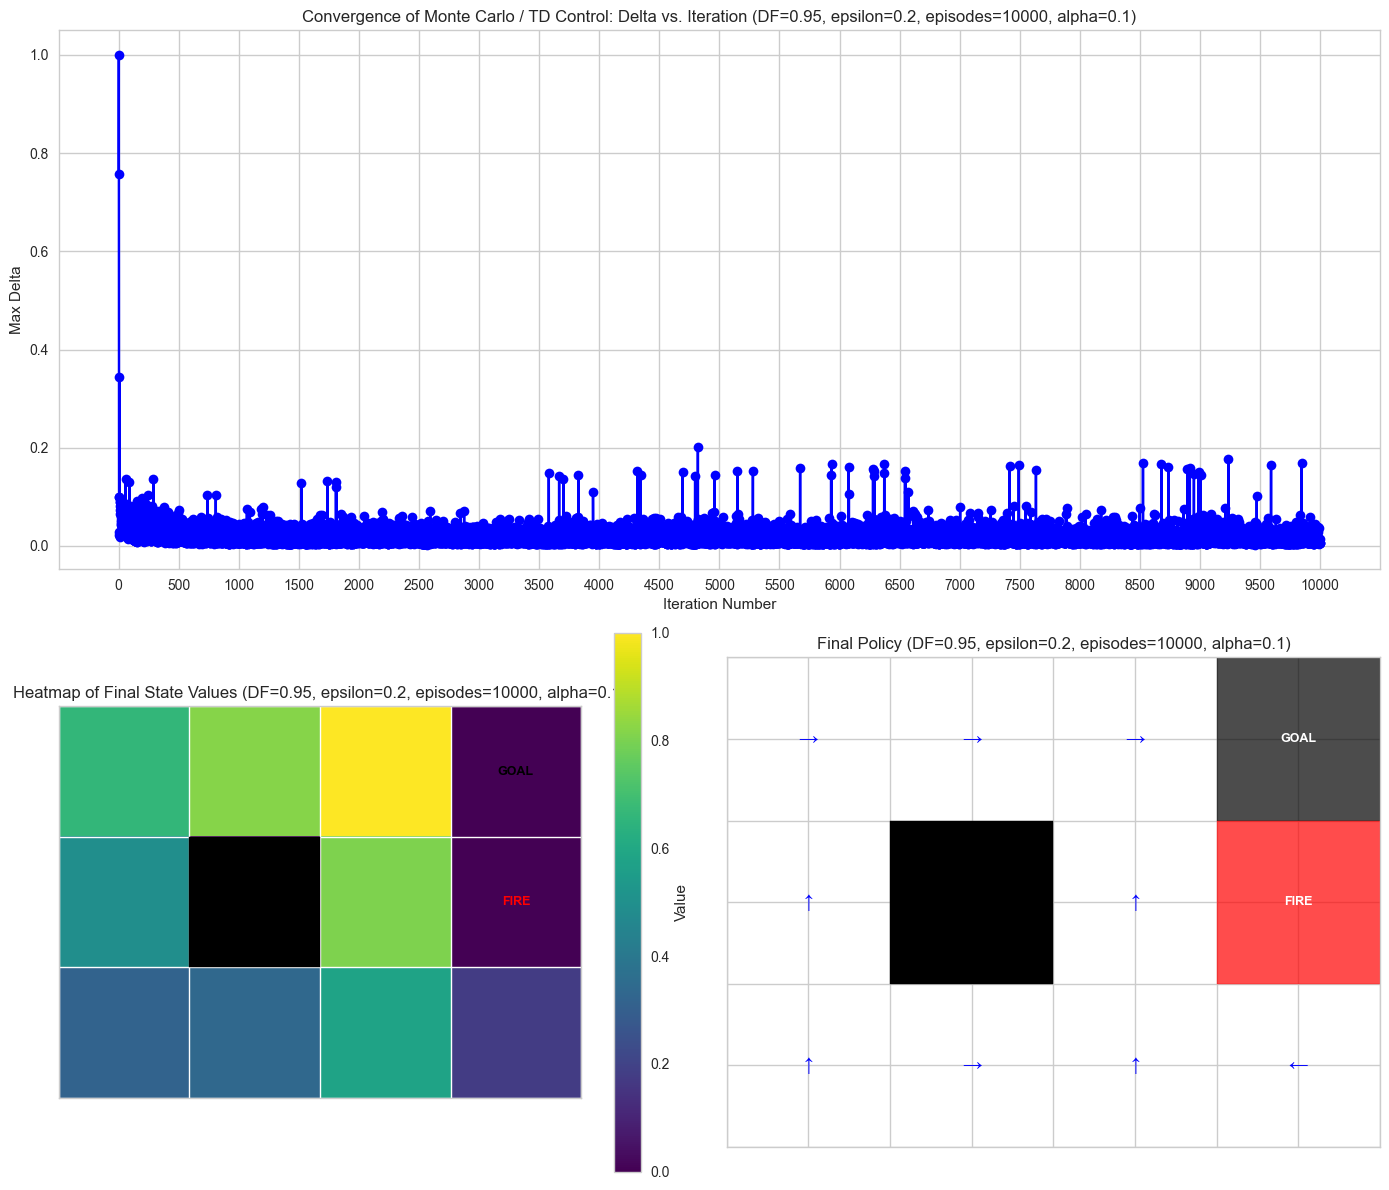

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.05
  Num_Episodes: 1000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



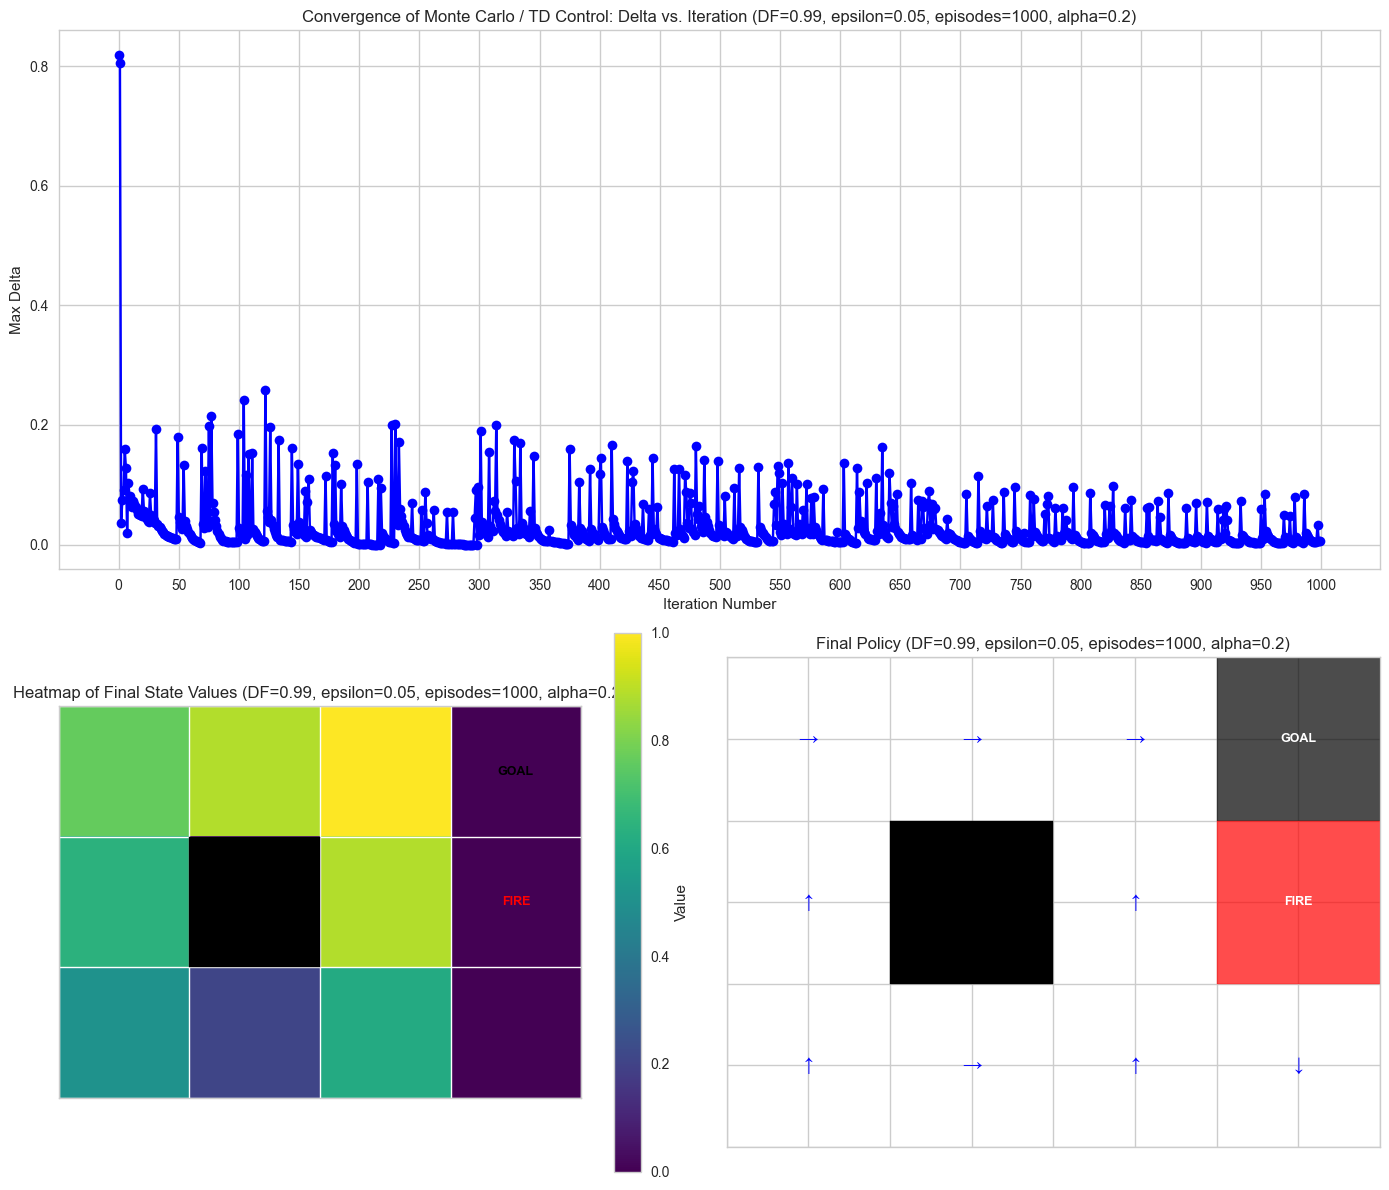

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.05
  Num_Episodes: 10000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



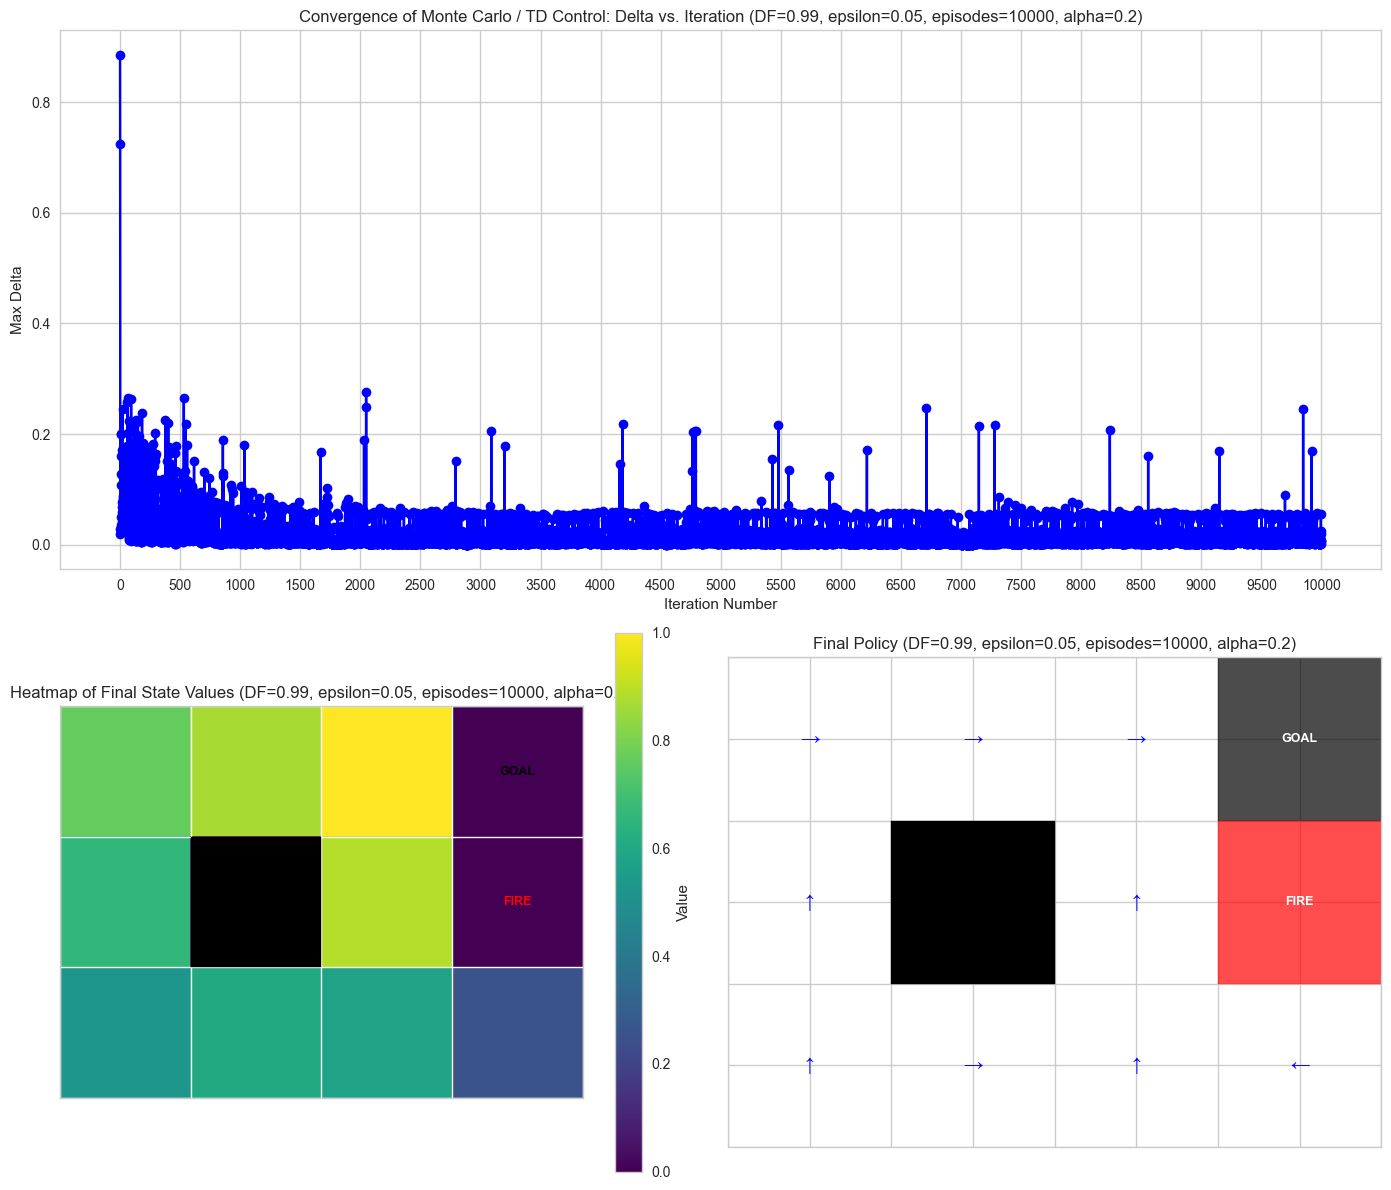

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.05
  Num_Episodes: 1000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



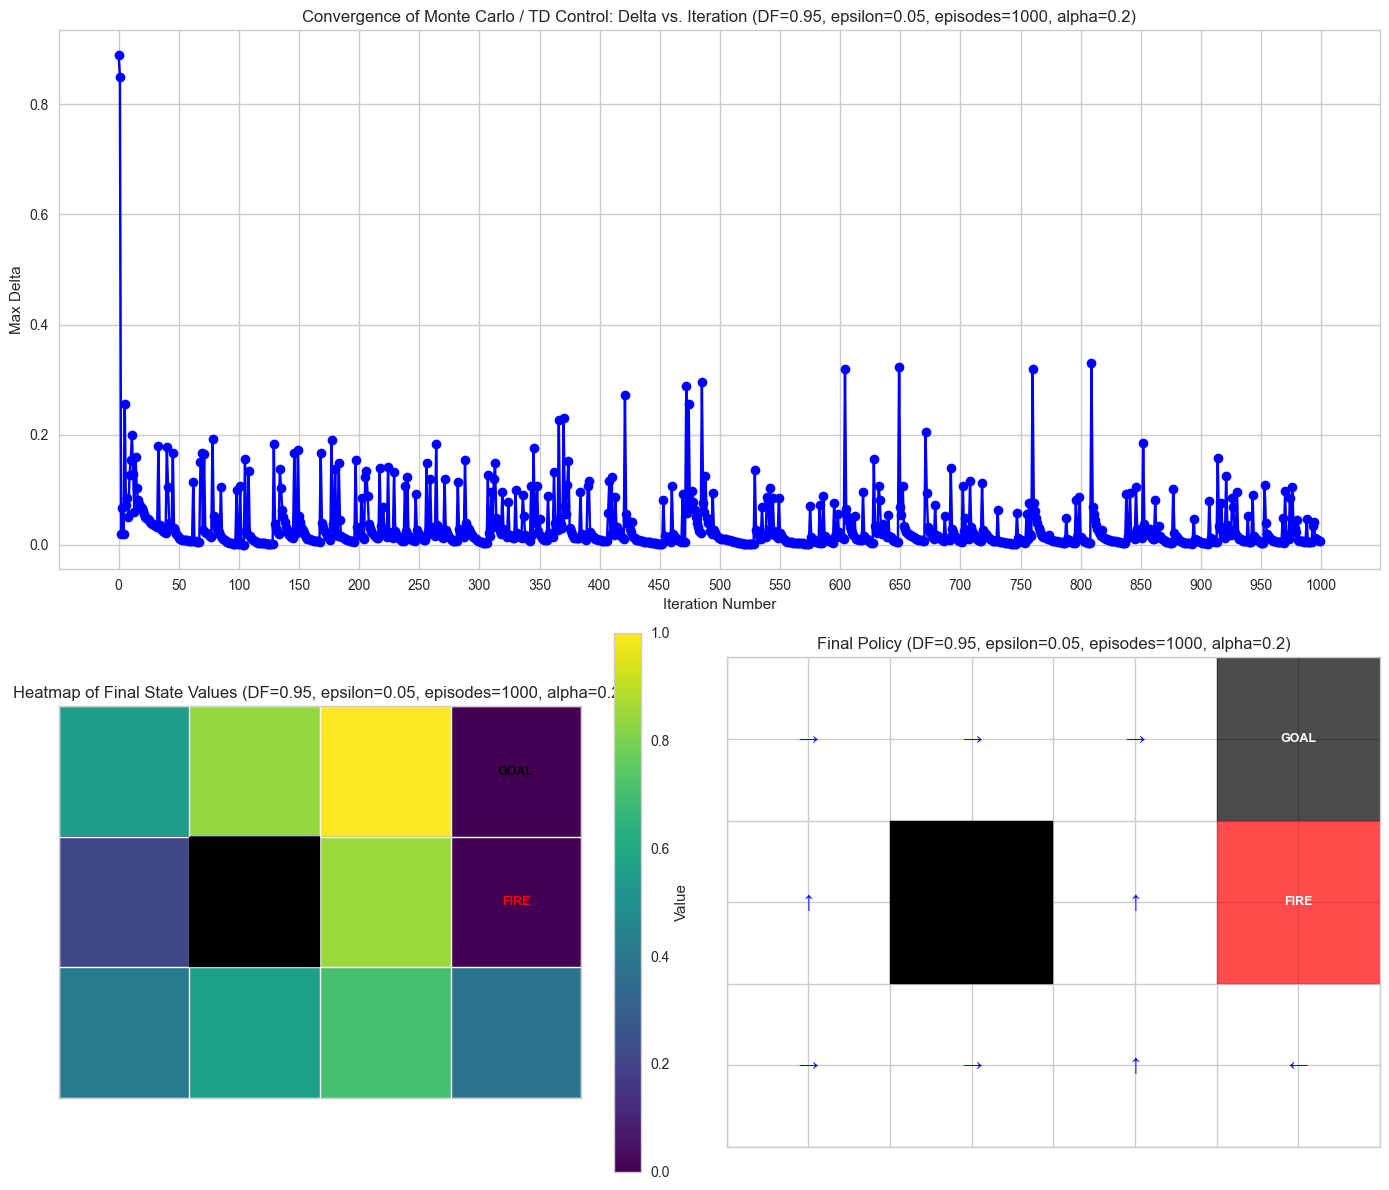

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.05
  Num_Episodes: 10000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



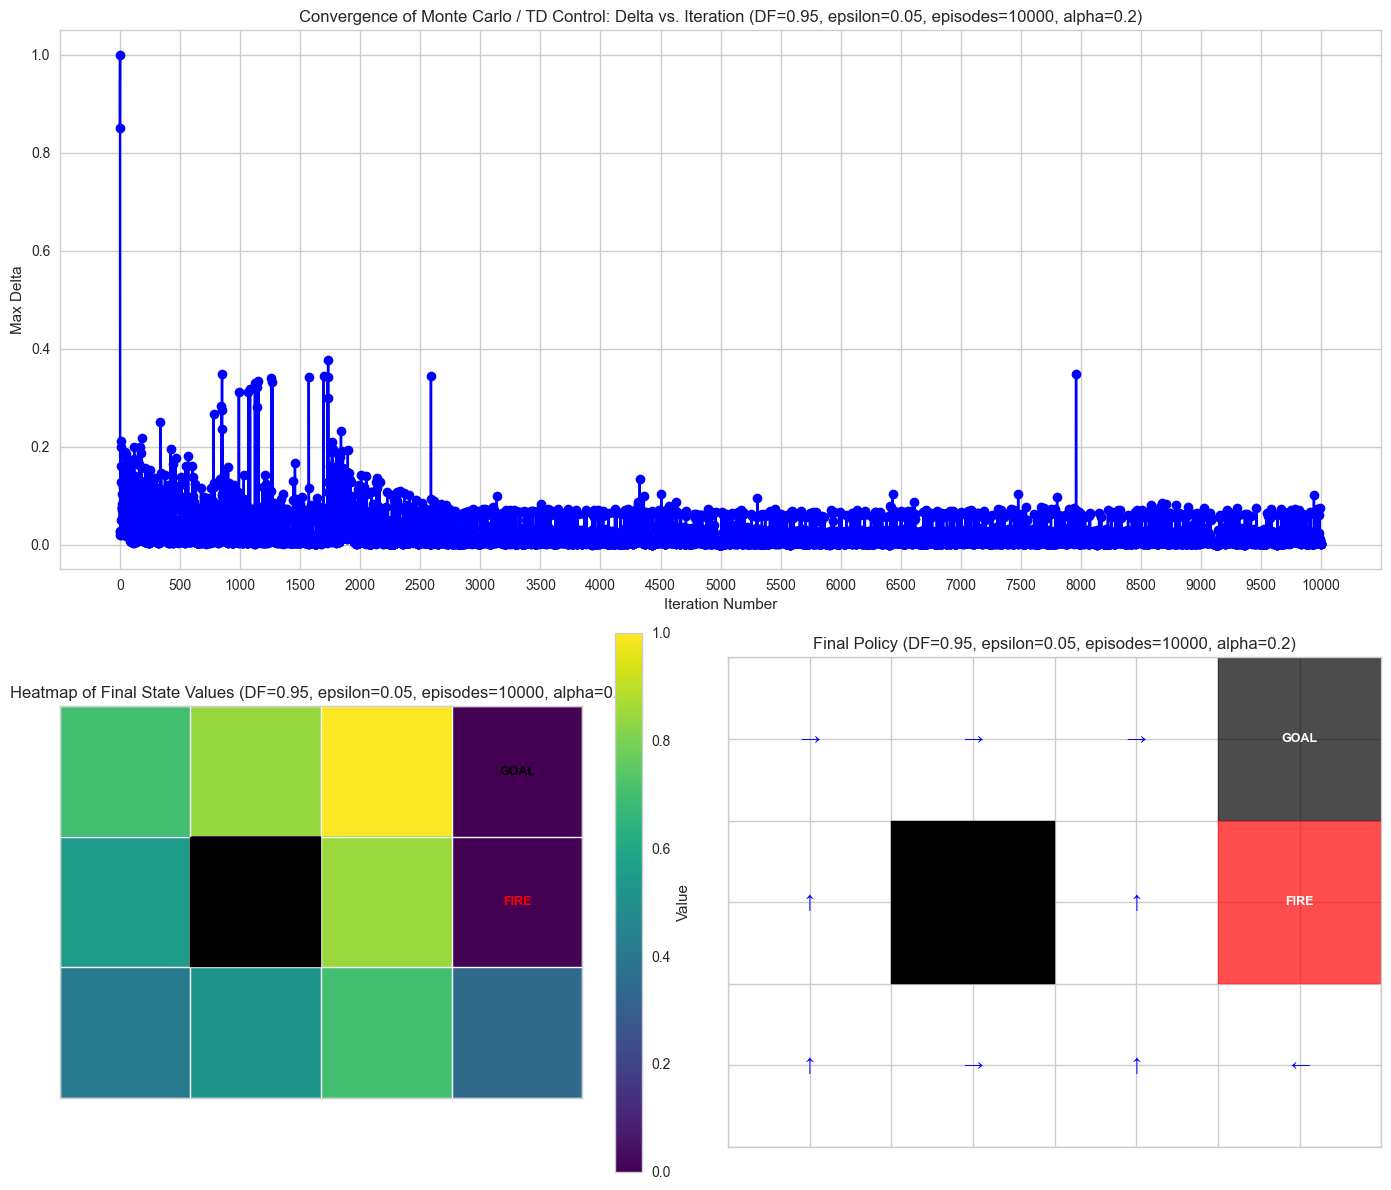

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.1
  Num_Episodes: 1000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



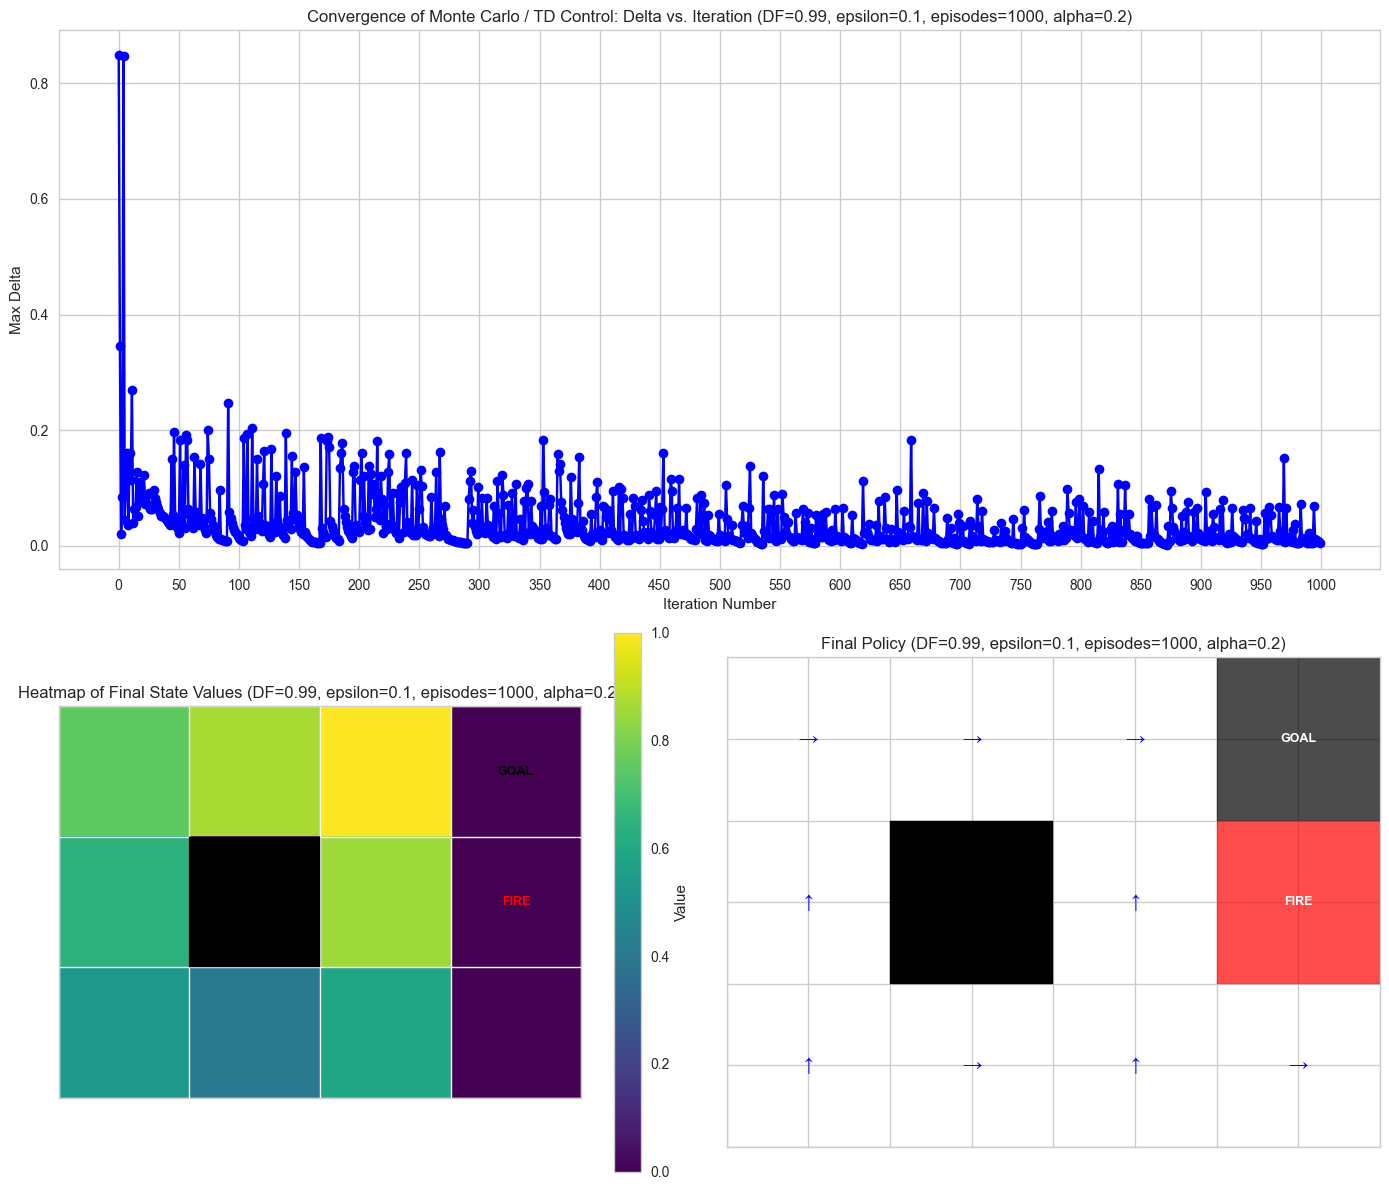

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.1
  Num_Episodes: 10000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



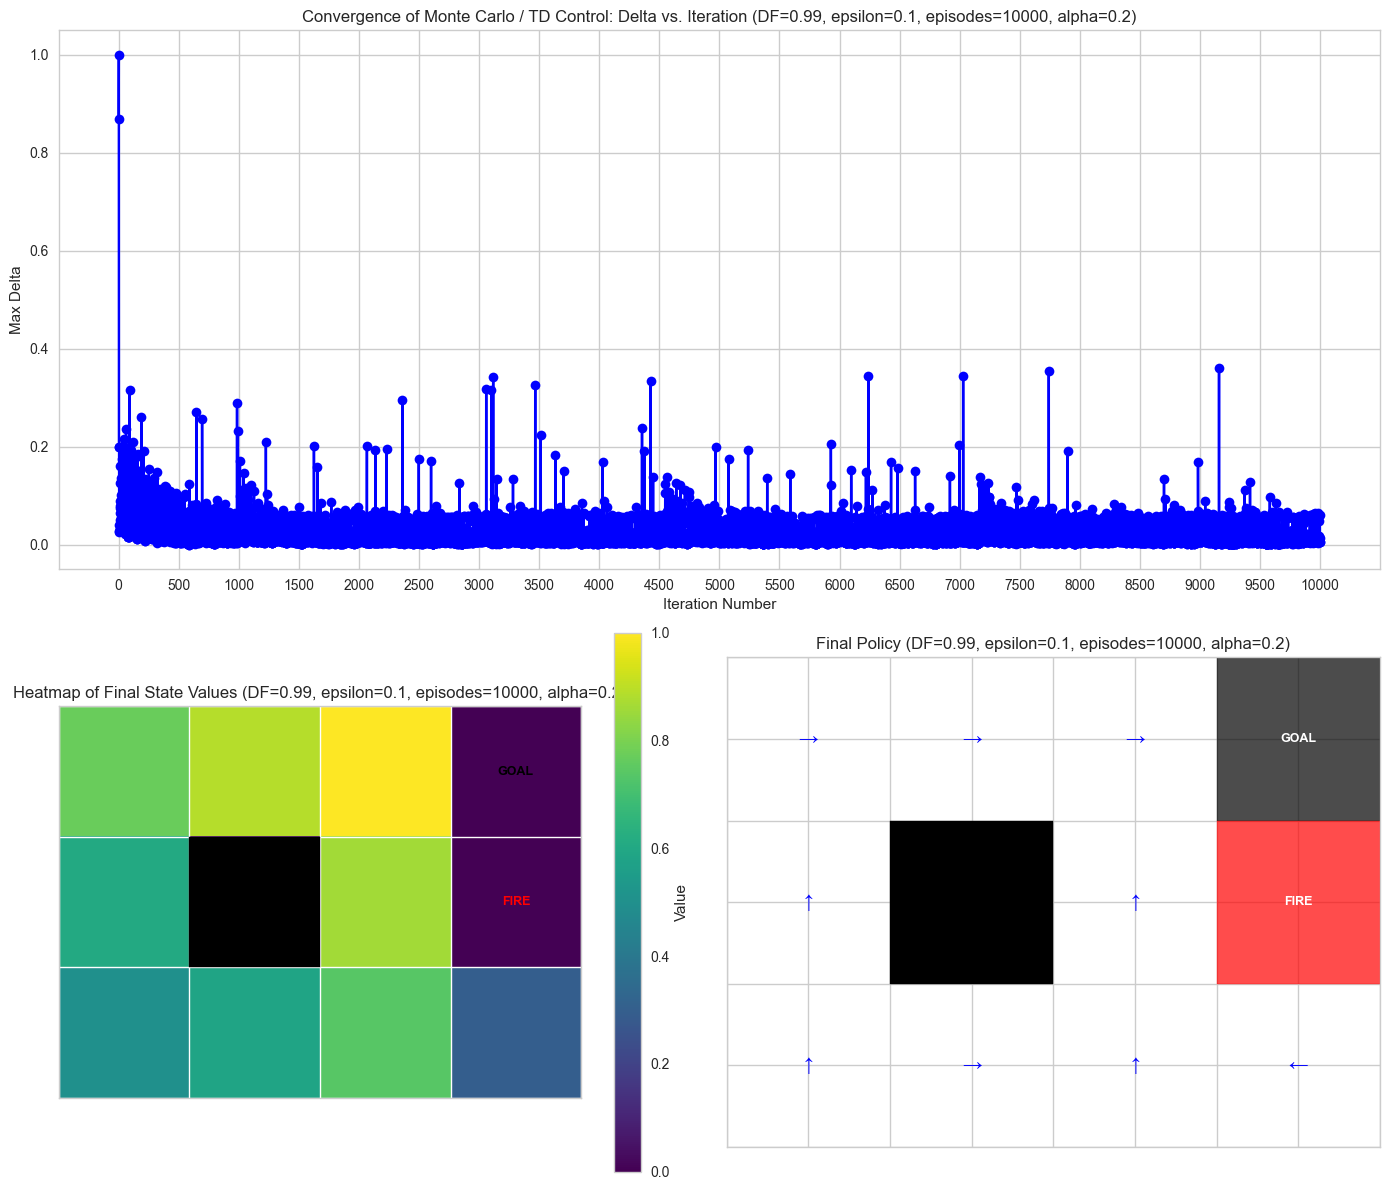

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.1
  Num_Episodes: 1000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



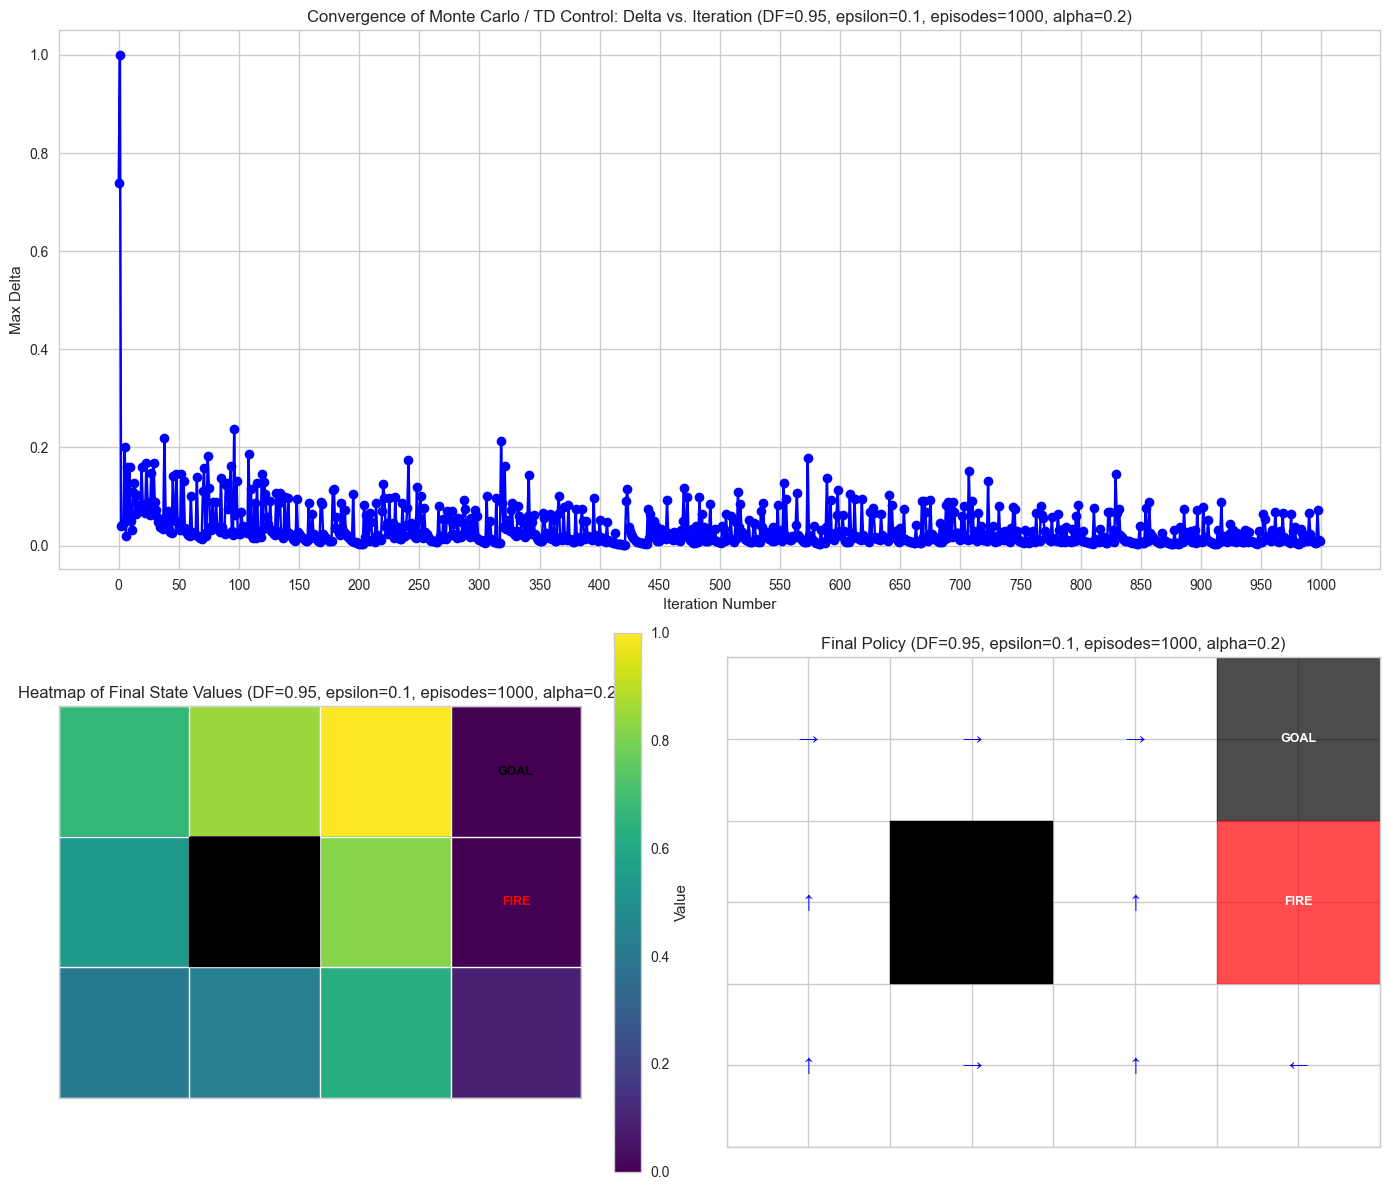

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.1
  Num_Episodes: 10000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



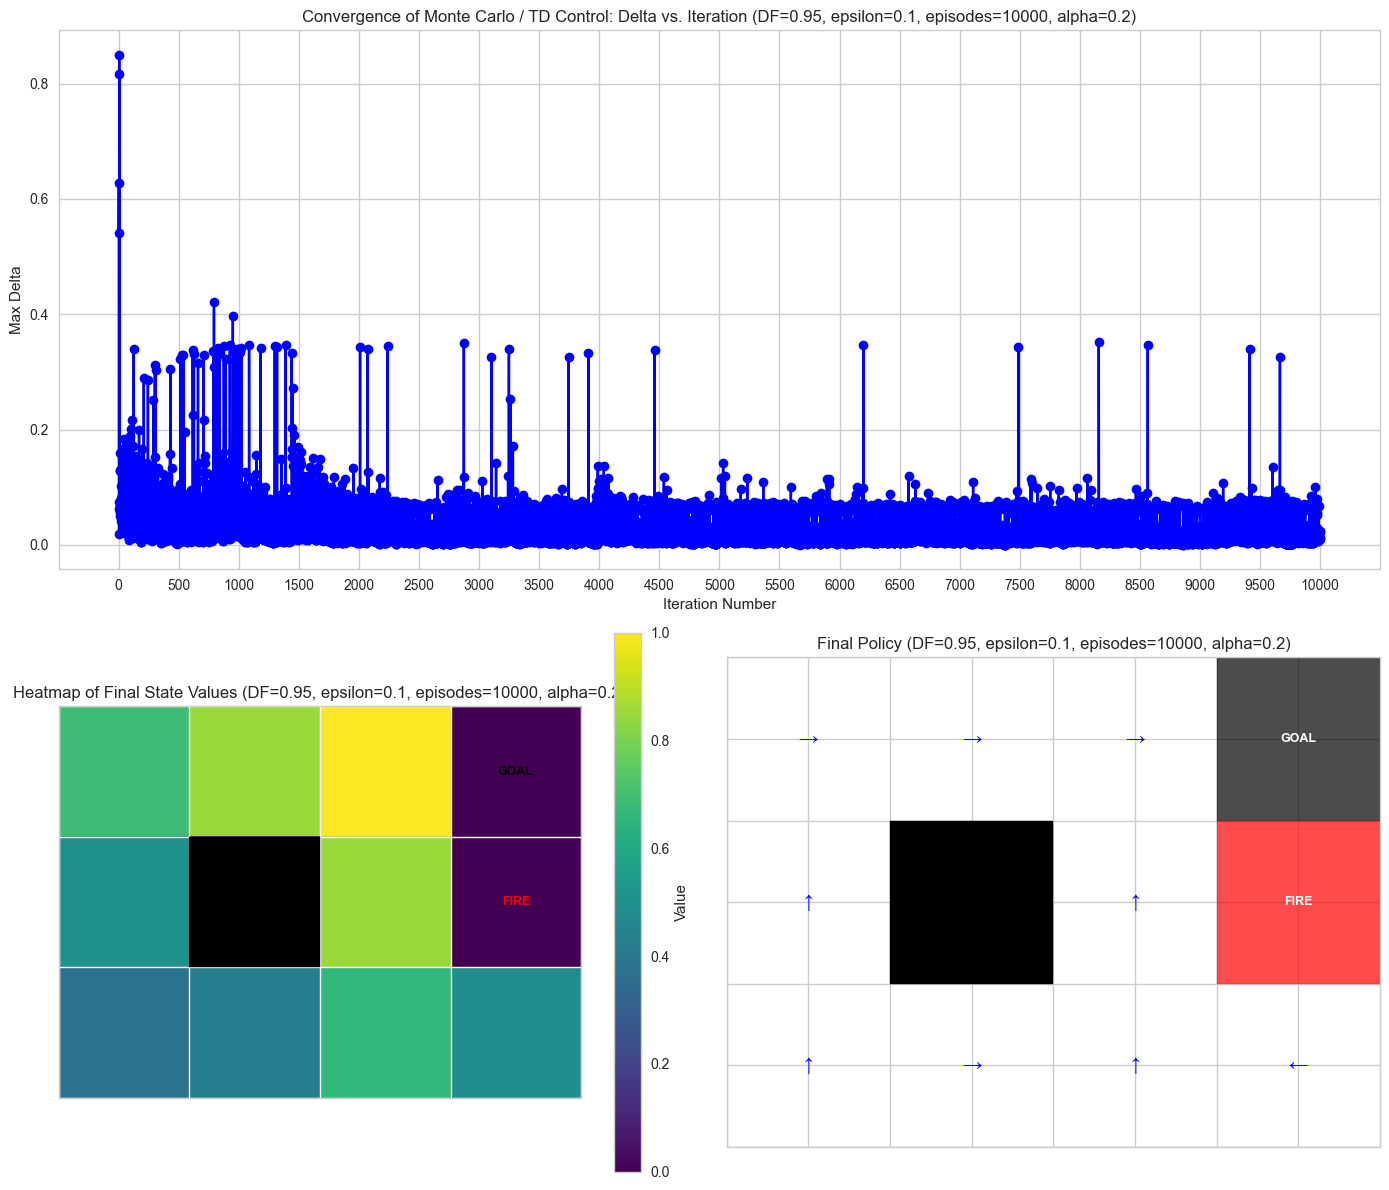

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.2
  Num_Episodes: 1000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



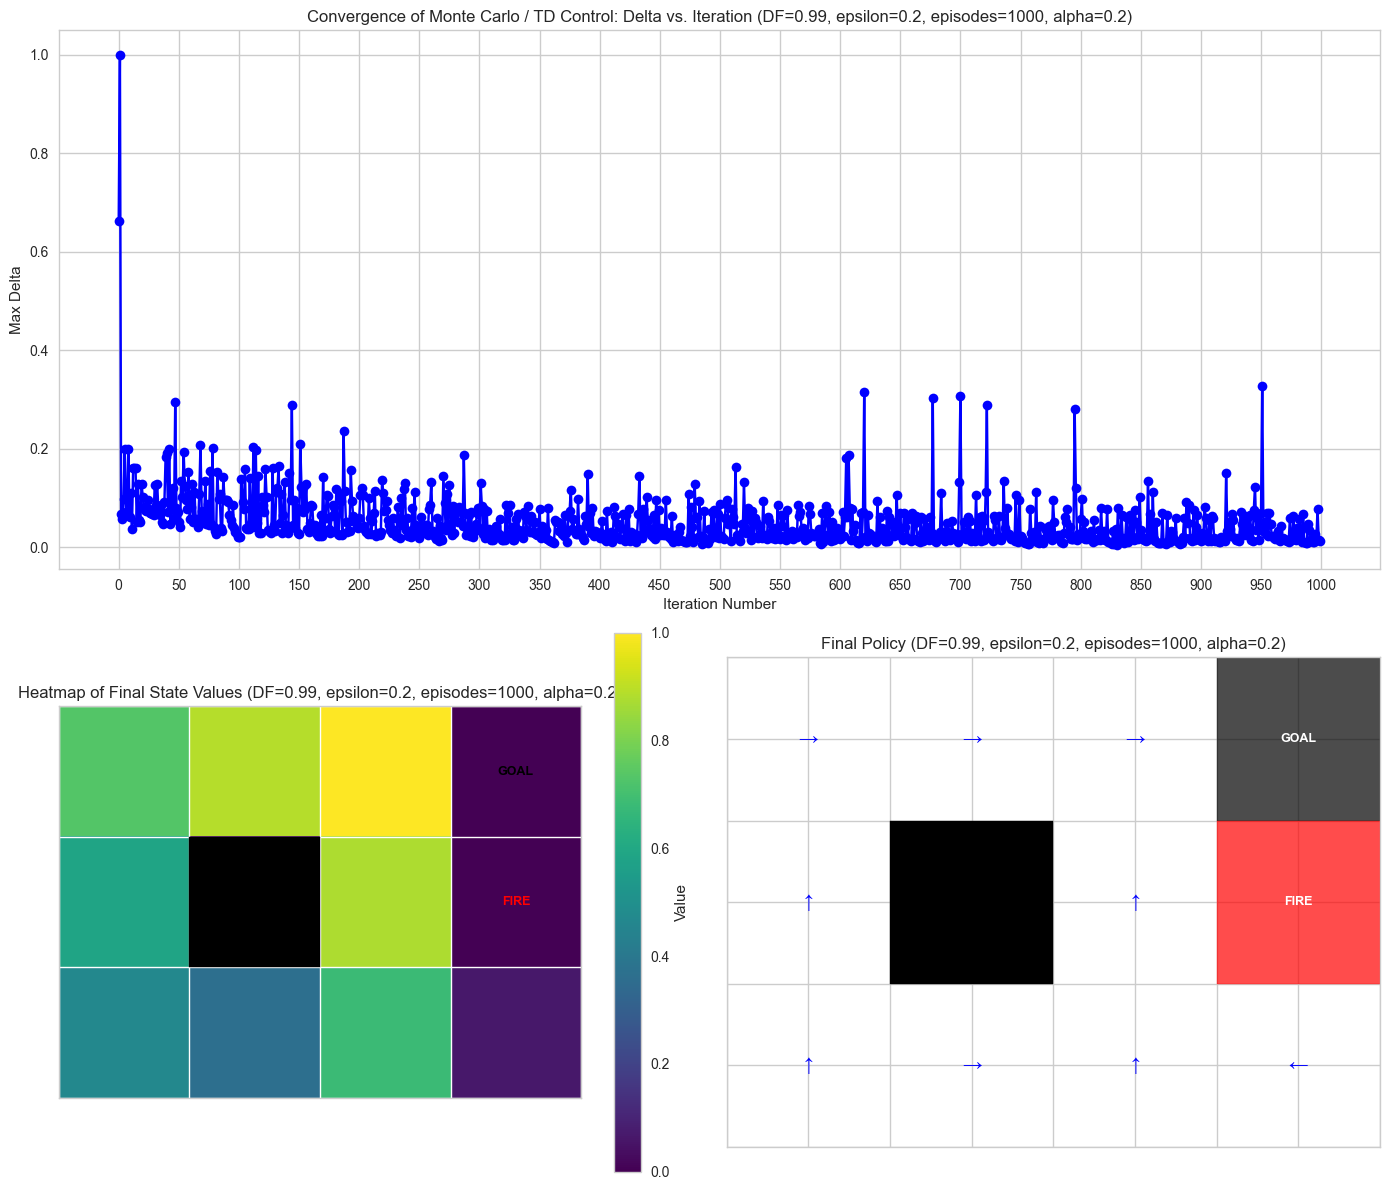

Analyzing experiment with parameters:
  Discount Factor: 0.99
  Epsilon: 0.2
  Num_Episodes: 10000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



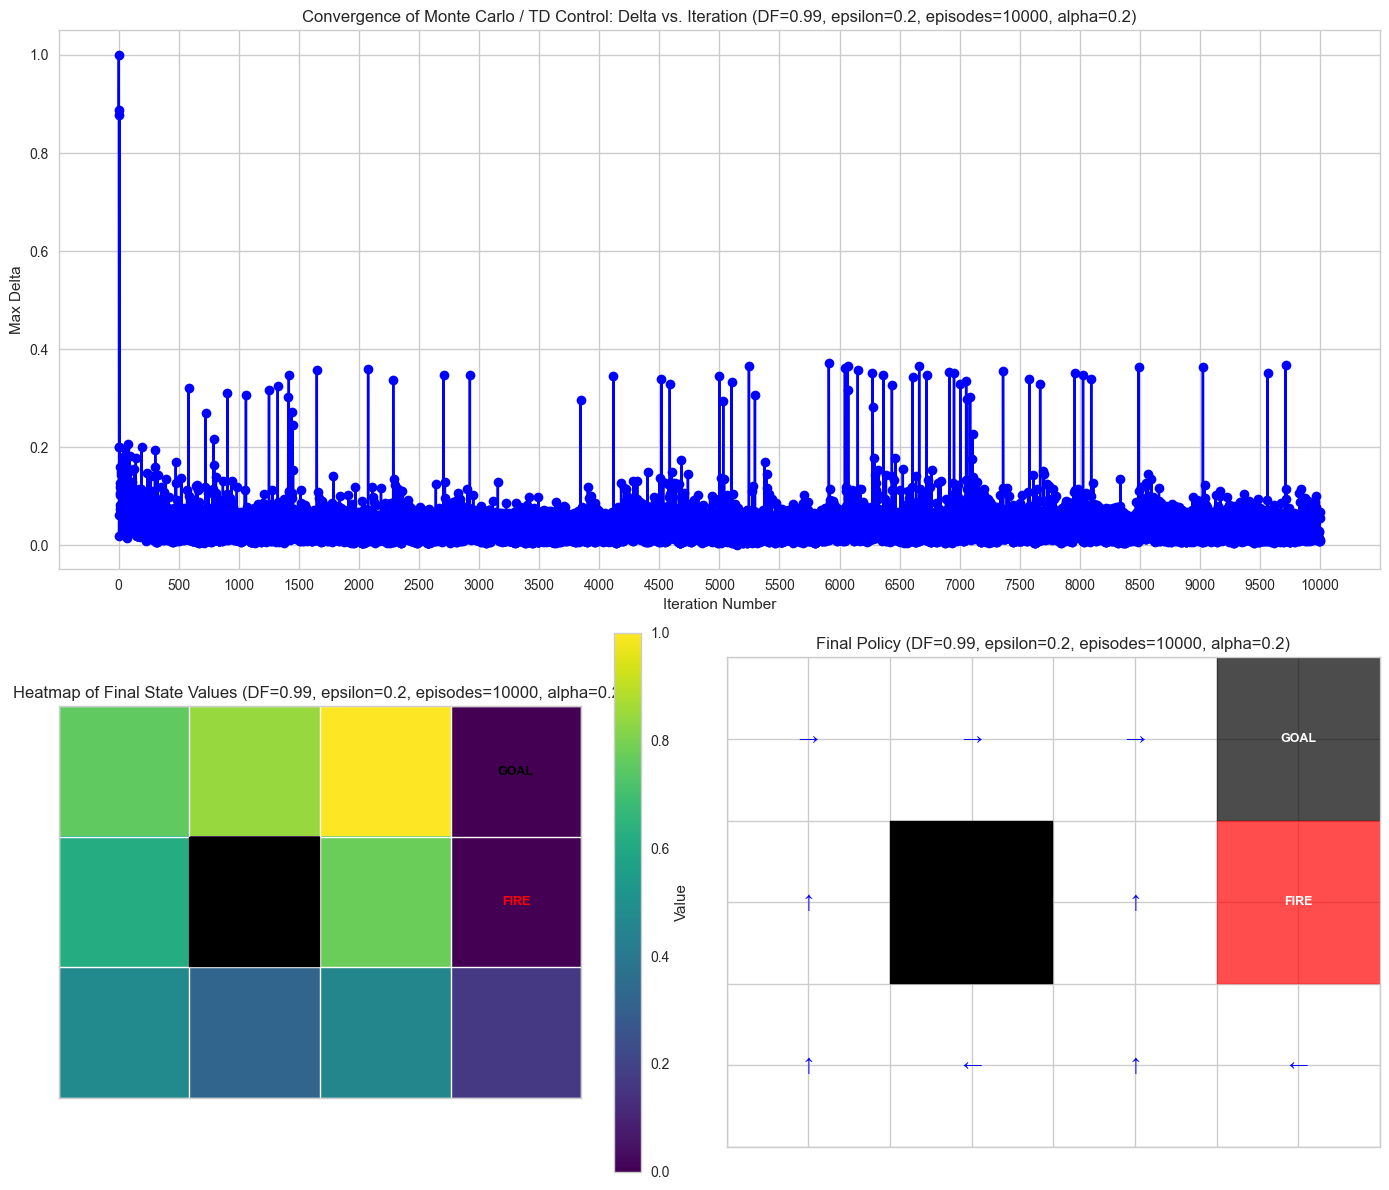

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.2
  Num_Episodes: 1000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



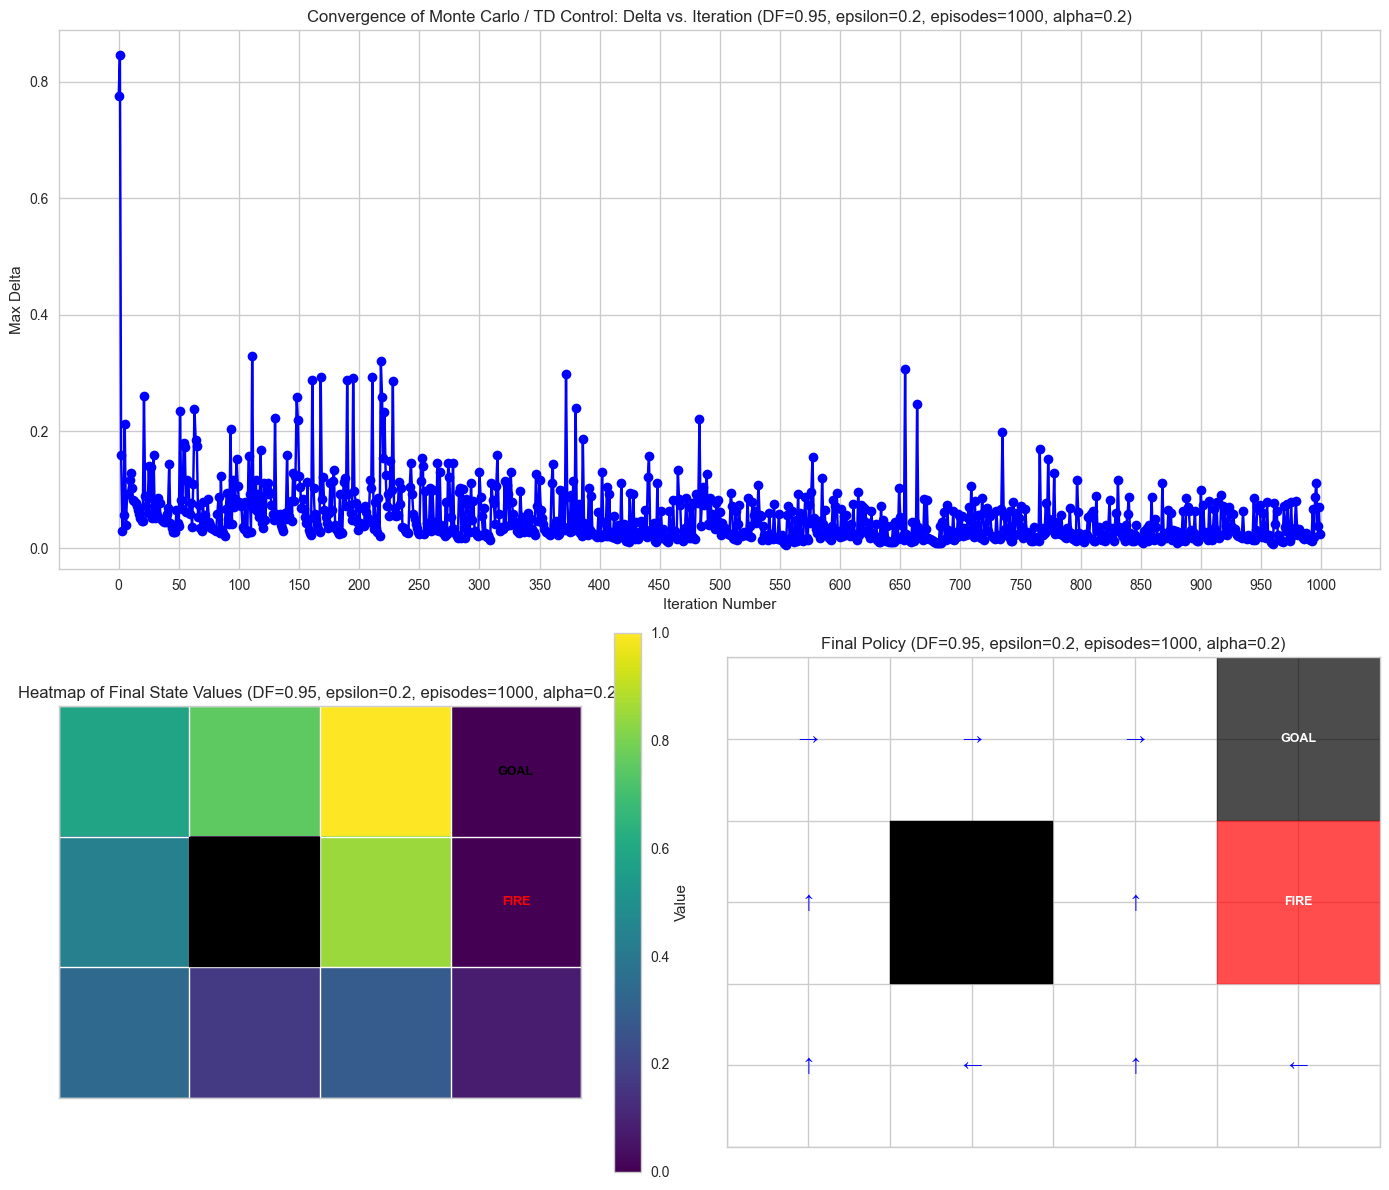

Analyzing experiment with parameters:
  Discount Factor: 0.95
  Epsilon: 0.2
  Num_Episodes: 10000
  Alpha: 0.2
Displaying convergence curve, heatmap of final values, and final policy...



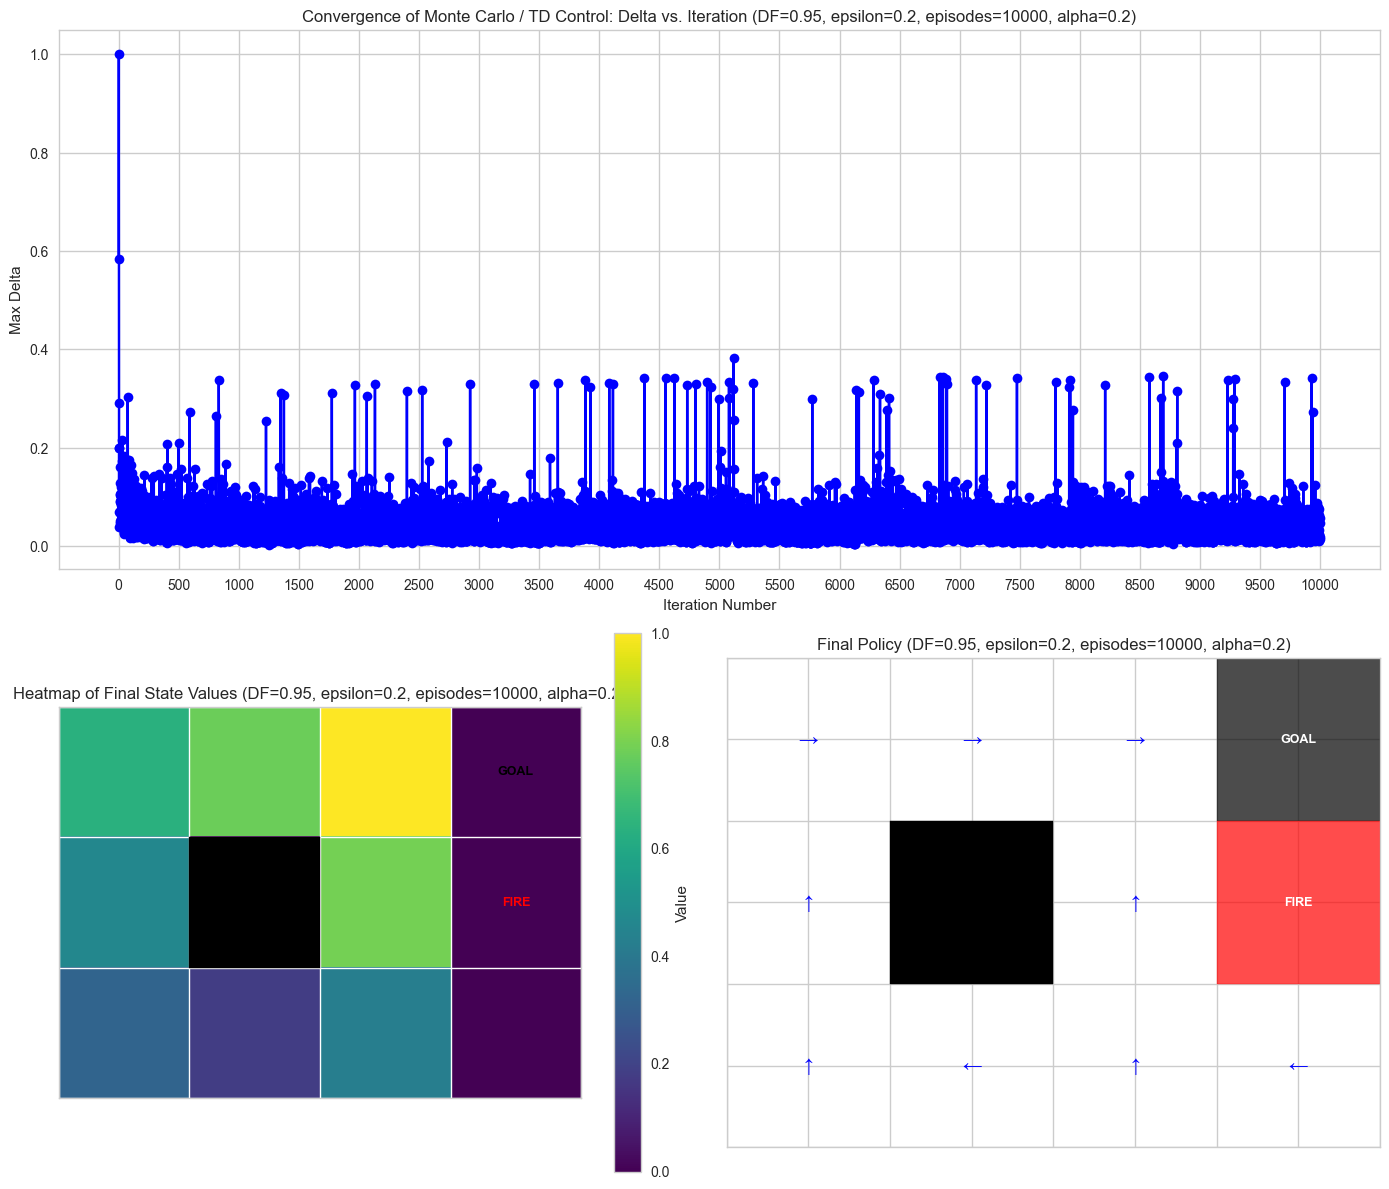

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from copy import deepcopy

# Map cardinal directions to arrow symbols
ARROW_MAP = {
    'up': '↑',
    'down': '↓',
    'left': '←',
    'right': '→'
}

def plot_run(gridworld, iteration_info, run_params=None):
    """
    Plots a single figure with three subplots:
      1) Convergence curve (delta vs. iteration) in the top half,
      2) Heatmap of final state values (with blocked/danger/goal cells) in the bottom left,
      3) Final policy visualization (with arrow symbols) in the bottom right.
    """
    if run_params is None:
        run_params = {}

    # Build the parameter string based on available keys
    param_list = []
    if 'discount_factor' in run_params:
        param_list.append(f"DF={run_params['discount_factor']}")
    if 'tolerance' in run_params:
        param_list.append(f"tol={run_params['tolerance']}")
    if 'noise' in run_params:
        param_list.append(f"noise={run_params['noise']}")
    if 'epsilon' in run_params:
        param_list.append(f"epsilon={run_params['epsilon']}")
    if 'num_episodes' in run_params:
        param_list.append(f"episodes={run_params['num_episodes']}")
    if 'alpha' in run_params:
        param_list.append(f"alpha={run_params['alpha']}")

    param_str = "(" + ", ".join(param_list) + ")"

    # Determine plot title: if we have 'tolerance', call it Value Iteration; otherwise, Monte Carlo/TD Control
    method_name = "Value Iteration" if 'tolerance' in run_params else "Monte Carlo / TD Control"

    grid_height = gridworld._height
    grid_width = gridworld._width

    # Extract data for the convergence curve
    iterations = [info['iteration'] for info in iteration_info]
    deltas = [info['delta'] for info in iteration_info]
    final_policy = iteration_info[-1]['policy']
    heatmap_values = np.array(iteration_info[-1]['grid_values']).reshape((grid_height, grid_width))

    # Create a figure with a gridspec layout:
    # - Top half: convergence curve spanning both columns.
    # - Bottom half: left: heatmap; right: final policy.
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    # -------------------------------
    # Convergence Curve (Top, spanning 2 columns)
    # -------------------------------
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(iterations, deltas, marker='o', linestyle='-', color='blue', label='Delta')
    if 'tolerance' in run_params:
        ax0.axhline(y=run_params['tolerance'], color='red', linestyle='--',
                    label=f"Tolerance = {run_params['tolerance']}")
        ax0.legend()
    ax0.set_xlabel('Iteration Number')
    ax0.set_ylabel('Max Delta')
    ax0.set_title(f'Convergence of {method_name}: Delta vs. Iteration {param_str}')
    ax0.locator_params(axis='x', nbins=25)
    ax0.grid(True)

    # -------------------------------
    # Heatmap of Final State Values (Bottom Left)
    # -------------------------------
    ax1 = fig.add_subplot(gs[1, 0])
    im = ax1.imshow(heatmap_values, cmap='viridis', interpolation='nearest',
                    extent=[0, grid_width, grid_height, 0], origin='upper', aspect='equal')
    ax1.set_title(f'Heatmap of Final State Values {param_str}')
    cbar = fig.colorbar(im, ax=ax1)
    cbar.set_label('Value')

    state_index = 0
    for row in range(grid_height):
        for col in range(grid_width):
            if state_index in gridworld._blocked_cells:
                ax1.add_patch(plt.Rectangle((col, row), 1, 1, color='black', zorder=2))
            elif state_index in gridworld._danger_cells:
                ax1.text(col + 0.5, row + 0.5, 'FIRE', color='red',
                         ha='center', va='center', fontsize=9, fontweight='bold', zorder=3)
            elif state_index == gridworld._goal_cell:
                ax1.text(col + 0.5, row + 0.5, 'GOAL', color='black',
                         ha='center', va='center', fontsize=9, fontweight='bold', zorder=3)
            state_index += 1

    ax1.set_xticks(np.arange(0, grid_width+1, 1))
    ax1.set_yticks(np.arange(0, grid_height+1, 1))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.grid(which='major', color='white', linewidth=1)

    # -------------------------------
    # Final Policy Visualization (Bottom Right)
    # -------------------------------
    ax2 = fig.add_subplot(gs[1, 1])
    # Create a transparent background
    ax2.imshow(np.ones((grid_height, grid_width)), cmap='gray', alpha=0,
               extent=[0, grid_width, grid_height, 0], origin='upper', aspect='equal')
    ax2.set_title(f'Final Policy {param_str}')

    state_index = 0
    for row in range(grid_height):
        for col in range(grid_width):
            if state_index in gridworld._blocked_cells:
                ax2.add_patch(plt.Rectangle((col, row), 1, 1, color='black', zorder=2))
            elif state_index in gridworld._danger_cells:
                ax2.add_patch(plt.Rectangle((col, row), 1, 1, color='red', alpha=0.7, zorder=2))
                ax2.text(col + 0.5, row + 0.5, 'FIRE', ha='center', va='center',
                         color='white', fontsize=9, fontweight='bold', zorder=3)
            elif state_index == gridworld._goal_cell:
                ax2.add_patch(plt.Rectangle((col, row), 1, 1, color='black', alpha=0.7, zorder=2))
                ax2.text(col + 0.5, row + 0.5, 'GOAL', ha='center', va='center',
                         color='white', fontsize=9, fontweight='bold', zorder=3)
            else:
                arrow_char = ARROW_MAP.get(final_policy[state_index], '?')
                ax2.text(col + 0.5, row + 0.5, arrow_char, ha='center', va='center',
                         color='blue', fontsize=14, zorder=3)
            state_index += 1

    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    plt.tight_layout()
    plt.show()


# -------------------------------------------------
# Plot Experiment Results
# -------------------------------------------------
for experiment_gridworld, experiment_iteration_info, run_params in experiments:
    print("===================================================")
    print("Analyzing experiment with parameters:")
    if run_params.get('discount_factor', None):
        print(f"  Discount Factor: {run_params['discount_factor']}")
    if run_params.get('tolerance', None):
        print(f"  Tolerance: {run_params['tolerance']}")
    if run_params.get('noise', None):
        print(f"  Noise: {run_params['noise']}")
    if run_params.get('epsilon', None):
        print(f"  Epsilon: {run_params['epsilon']}")
    if run_params.get('num_episodes', None):
        print(f"  Num_Episodes: {run_params['num_episodes']}")
    if run_params.get('alpha', None):
        print(f"  Alpha: {run_params['alpha']}")
    print("Displaying convergence curve, heatmap of final values, and final policy...\n")
    plot_run(experiment_gridworld, experiment_iteration_info, run_params)